In [ ]:
from google.colab import files

uploaded = files.upload()

Saving multimodal_only_samples.zip to multimodal_only_samples.zip


In [ ]:
import zipfile
import os

zip_path = "multimodal_only_samples.zip"
extract_path = "/content/fakeddit_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped files:")
os.listdir(extract_path)

Unzipped files:


['multimodal_only_samples']

In [ ]:
import pandas as pd

train_df = pd.read_csv('/content/fakeddit_data/multimodal_only_samples/multimodal_train.tsv', sep='\t')
val_df = pd.read_csv('/content/fakeddit_data/multimodal_only_samples/multimodal_validate.tsv', sep='\t')
test_df = pd.read_csv('/content/fakeddit_data/multimodal_only_samples/multimodal_test_public.tsv', sep='\t')

print("Original dataset sizes:")
print(f"Training samples:   {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples:       {len(test_df)}")

Original dataset sizes:
Training samples:   564000
Validation samples: 59342
Test samples:       59319


In [ ]:
train_df = train_df.sample(n=50000, random_state=42)
val_df = val_df.sample(n=8000, random_state=42)
test_df = test_df.sample(n=8000, random_state=42)

In [ ]:
columns = ["clean_title", "image_url", "2_way_label"]
train_df = train_df[columns].dropna()
val_df   = val_df[columns].dropna()
test_df  = test_df[columns].dropna()

In [ ]:
for df in [train_df, val_df, test_df]:
    df.rename(columns={"clean_title": "text", "image_url": "image_url", "2_way_label": "label"}, inplace=True)

In [ ]:
train_df.head()

,text,image_url,label
91547,feeling lucky,http://i.imgur.com/Zu6Sx.jpg,0
424990,cutouts,https://31.media.tumblr.com/d7100866f676a6a376...,0
495536,my ceiling looks like an sd card,https://preview.redd.it/zqg8c8fteqe31.jpg?widt...,0
200727,join the raaf,https://external-preview.redd.it/q9DNAI6S1OC2v...,0
186353,hangover,http://i.imgur.com/wLCYVSv.jpg,0


Analyzing class distribution in datasets...

Training Dataset Distribution:


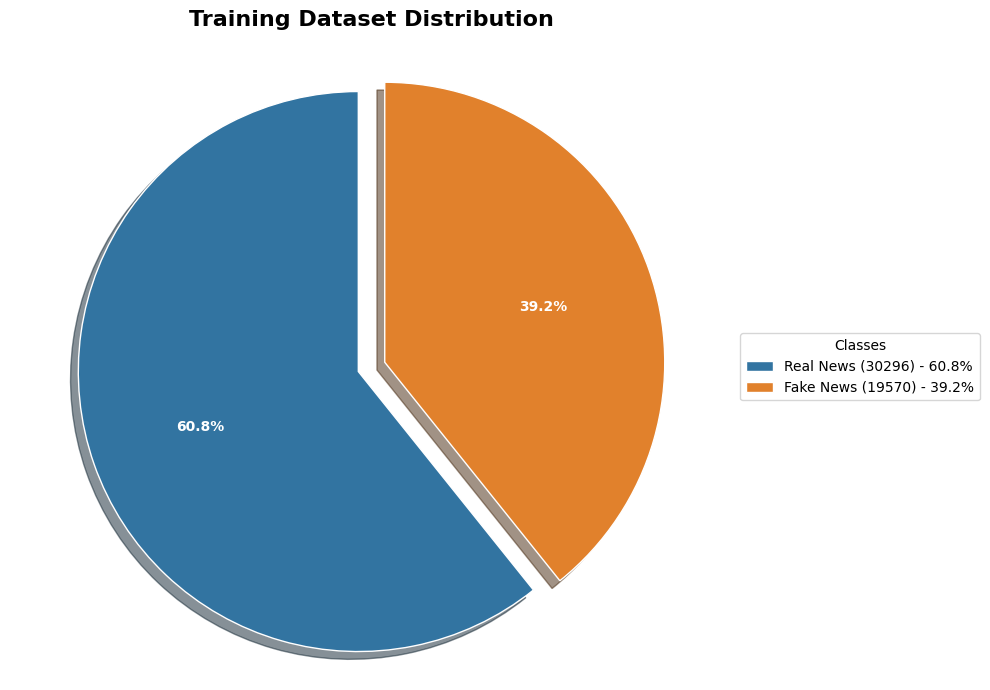


=== Training Dataset Distribution Summary ===
Real News: 30296 instances (60.8%)
Fake News: 19570 instances (39.2%)
Total: 49866 instances

Validation Dataset Distribution:


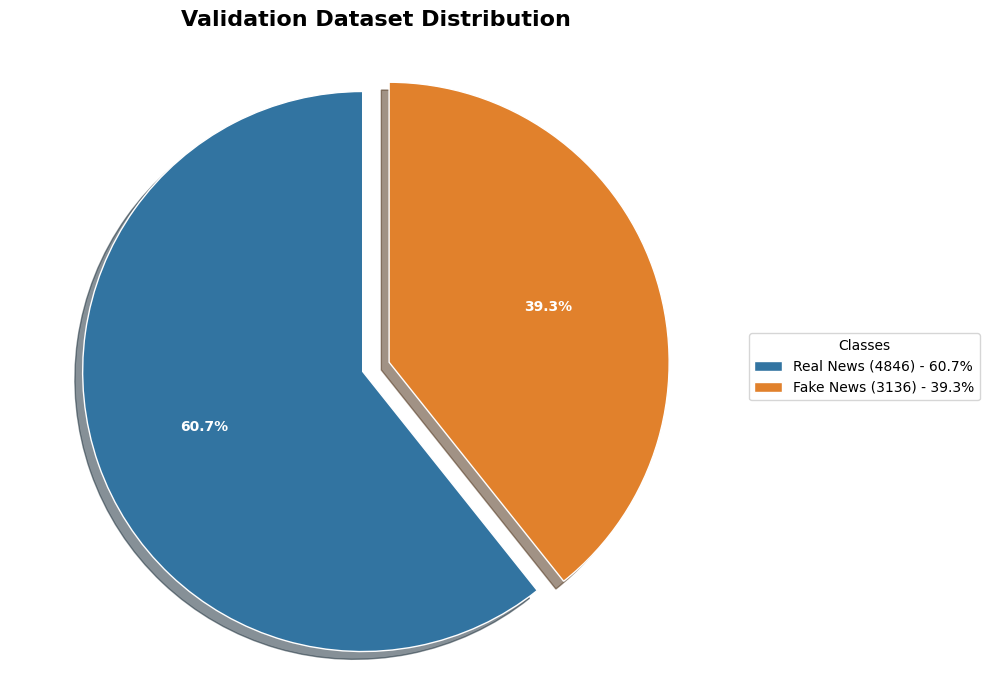


=== Validation Dataset Distribution Summary ===
Real News: 4846 instances (60.7%)
Fake News: 3136 instances (39.3%)
Total: 7982 instances

Test Dataset Distribution:


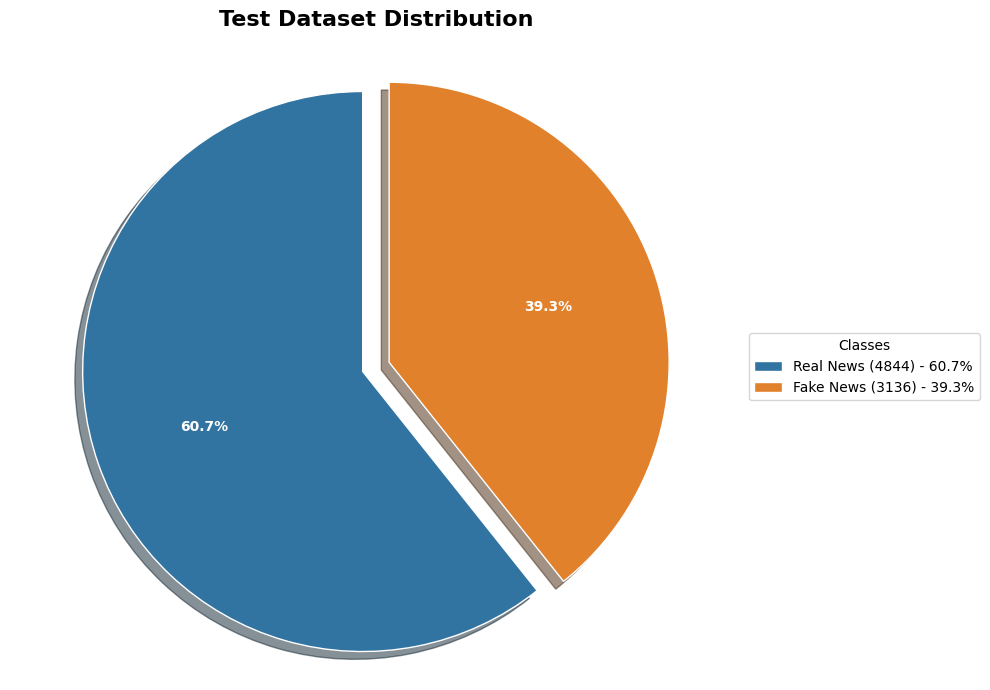


=== Test Dataset Distribution Summary ===
Real News: 4844 instances (60.7%)
Fake News: 3136 instances (39.3%)
Total: 7980 instances

Generating combined distribution visualization...


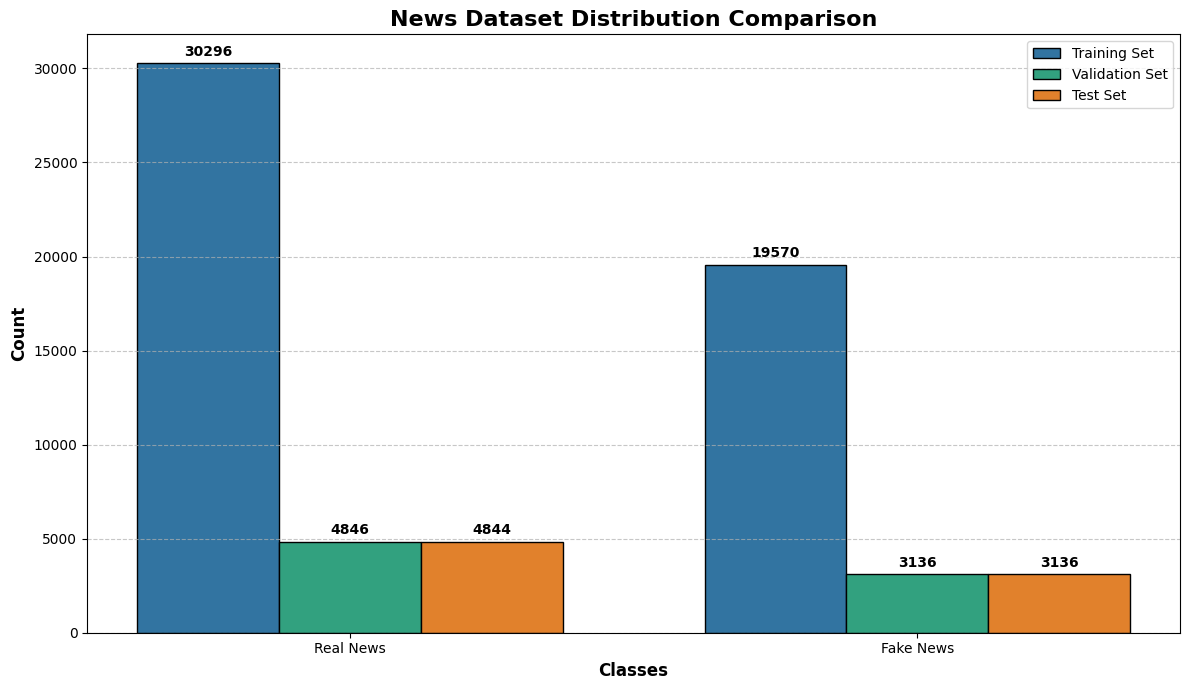


=== Dataset Balance Summary ===
Total dataset size: 65828 instances
Training set: 49866 instances (75.8%)
Validation set: 7982 instances (12.1%)
Test set: 7980 instances (12.1%)

=== Class Distribution Within Sets ===
           Training %  Validation %  Testing %
Real News        60.8          60.7       60.7
Fake News        39.2          39.3       39.3

=== Class Imbalance Analysis ===
Training set imbalance ratio: 1.55:1
Validation set imbalance ratio: 1.55:1
Testing set imbalance ratio: 1.54:1


In [ ]:
def plot_dataset_distribution(dataframe, title="Dataset Distribution"):
    """
    Generate a pie chart showing the distribution of classes in a pandas DataFrame.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        DataFrame containing the dataset with a 'label' column
    title : str
        Title for the plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import Counter

    labels = dataframe['label'].values
    label_counts = Counter(labels)

    class_names = {0: "Real News", 1: "Fake News"}
    pie_labels = []
    sizes = []

    for label_idx in sorted(label_counts.keys()):
        count = label_counts[label_idx]
        label = class_names.get(label_idx, f"Class {label_idx}")

        pie_labels.append(f"{label} ({count})")
        sizes.append(count)

    total = sum(sizes)
    percentages = [(size / total) * 100 for size in sizes]
    pie_labels = [f"{pie_labels[i]} - {percentages[i]:.1f}%" for i in range(len(pie_labels))]

    plt.figure(figsize=(10, 7))
    colors = ['#3274A1', '#E1812C']

    wedges, texts, autotexts = plt.pie(
        sizes,
        labels=None,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        explode=[0.05] * len(sizes),
        shadow=True,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    plt.legend(
        wedges,
        pie_labels,
        title="Classes",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1)
    )

    plt.title(title, fontsize=16, fontweight='bold', pad=20)

    plt.axis('equal')
    plt.tight_layout()

    safe_title = title.replace(" ", "_").lower()
    plt.savefig(f'{safe_title}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n=== {title} Summary ===")
    for i, (label, count, percentage) in enumerate(zip(pie_labels, sizes, percentages)):
        print(f"{label.split(' (')[0]}: {count} instances ({percentage:.1f}%)")
    print(f"Total: {total} instances")

    return label_counts

def plot_combined_distribution(train_df, val_df, test_df):
    """
    Generate a bar chart comparing the distribution across train, validation and test sets
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    class_names = {0: "Real News", 1: "Fake News"}

    train_counts = train_df['label'].value_counts().sort_index()
    val_counts = val_df['label'].value_counts().sort_index()
    test_counts = test_df['label'].value_counts().sort_index()

    all_indices = sorted(set(
        list(train_counts.index) +
        list(val_counts.index) +
        list(test_counts.index)
    ))
    df_dict = {
        'Training': pd.Series(train_counts).reindex(all_indices).fillna(0).astype(int),
        'Validation': pd.Series(val_counts).reindex(all_indices).fillna(0).astype(int),
        'Testing': pd.Series(test_counts).reindex(all_indices).fillna(0).astype(int)
    }

    counts_df = pd.DataFrame(df_dict)
    counts_df.index = [class_names.get(idx, f"Class {idx}") for idx in counts_df.index]

    fig, ax = plt.subplots(figsize=(12, 7))
    bar_width = 0.25
    r = np.arange(len(counts_df.index))

    train_bars = ax.bar(r - bar_width, counts_df['Training'], width=bar_width, label='Training Set', color='#3274A1', edgecolor='black')
    val_bars = ax.bar(r, counts_df['Validation'], width=bar_width, label='Validation Set', color='#32A17F', edgecolor='black')
    test_bars = ax.bar(r + bar_width, counts_df['Testing'], width=bar_width, label='Test Set', color='#E1812C', edgecolor='black')

    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom',
                       fontweight='bold')

    add_labels(train_bars)
    add_labels(val_bars)
    add_labels(test_bars)

    ax.set_xlabel('Classes', fontweight='bold', fontsize=12)
    ax.set_ylabel('Count', fontweight='bold', fontsize=12)
    ax.set_title('News Dataset Distribution Comparison', fontweight='bold', fontsize=16)
    ax.set_xticks(r)
    ax.set_xticklabels(counts_df.index)

    ax.legend()
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.savefig('news_dataset_distribution_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n=== Dataset Balance Summary ===")
    total_rows = len(train_df) + len(val_df) + len(test_df)
    print(f"Total dataset size: {total_rows} instances")
    print(f"Training set: {len(train_df)} instances ({len(train_df)/total_rows*100:.1f}%)")
    print(f"Validation set: {len(val_df)} instances ({len(val_df)/total_rows*100:.1f}%)")
    print(f"Test set: {len(test_df)} instances ({len(test_df)/total_rows*100:.1f}%)")

    print("\n=== Class Distribution Within Sets ===")
    train_perc = train_df['label'].value_counts(normalize=True).sort_index() * 100
    val_perc = val_df['label'].value_counts(normalize=True).sort_index() * 100
    test_perc = test_df['label'].value_counts(normalize=True).sort_index() * 100

    distribution_df = pd.DataFrame({
        'Training %': train_perc,
        'Validation %': val_perc,
        'Testing %': test_perc
    }).round(1)

    distribution_df.index = [class_names.get(idx, f"Class {idx}") for idx in distribution_df.index]

    print(distribution_df)

import pandas as pd
print("Analyzing class distribution in datasets...")

print("\nTraining Dataset Distribution:")
train_counts = plot_dataset_distribution(train_df, title="Training Dataset Distribution")

print("\nValidation Dataset Distribution:")
val_counts = plot_dataset_distribution(val_df, title="Validation Dataset Distribution")

print("\nTest Dataset Distribution:")
test_counts = plot_dataset_distribution(test_df, title="Test Dataset Distribution")

print("\nGenerating combined distribution visualization...")
plot_combined_distribution(train_df, val_df, test_df)

print("\n=== Class Imbalance Analysis ===")
for name, df in [("Training", train_df), ("Validation", val_df), ("Testing", test_df)]:
    class_ratio = df['label'].value_counts().values
    if len(class_ratio) > 1:
        imbalance_ratio = max(class_ratio) / min(class_ratio)
        print(f"{name} set imbalance ratio: {imbalance_ratio:.2f}:1")

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-j3rzyoj2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-j3rzyoj2
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import requests
from io import BytesIO
import clip
from transformers import pipeline
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

In [ ]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

class FakedditURLDataset(Dataset):
    def __init__(self, dataframe, preprocess):
        self.df = dataframe
        self.preprocess = preprocess

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        url = row["image_url"]
        text = row["text"]
        label = int(row["label"])

        # Load image from URL
        try:
            response = requests.get(url, timeout=5)
            image = Image.open(BytesIO(response.content)).convert("RGB")
            image = self.preprocess(image)
        except:
            image = Image.new("RGB", (224, 224), (255, 255, 255))
            image = self.preprocess(image)

        try:
            if len(text.split()) > 75:
                summary = summarizer(text, max_length=60, min_length=30, do_sample=False)[0]["summary_text"]
            else:
                summary = text
        except Exception as e:
            print(f"Summarization failed for sample {idx}: {e}")
            summary = text[:300]

        tokenized_text = clip.tokenize([summary], truncate=True)[0]

        return image, tokenized_text, torch.tensor(label)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

train_dataset = FakedditURLDataset(train_df, preprocess)
val_dataset   = FakedditURLDataset(val_df, preprocess)
test_dataset  = FakedditURLDataset(test_df, preprocess)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256)
test_loader  = DataLoader(test_dataset, batch_size=256)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 102MiB/s]


In [ ]:
import torch.nn as nn

class FakeNewsClassifier(nn.Module):
    def __init__(self, embed_dim=512):
        super(FakeNewsClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 2)
        )

    def forward(self, image_feat, text_feat):
        x = torch.cat((image_feat, text_feat), dim=1)
        return self.classifier(x)

In [ ]:
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")

Number of batches in train_loader: 195
Number of batches in val_loader: 32


In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm
def evaluate_model(model, data_loader, clip_model, device, return_metrics=False):
    """
    Evaluate the model on a given data loader.

    Args:
        model: The model to evaluate.
        data_loader: The data loader for the evaluation data.
        clip_model: The CLIP model for encoding images and text.
        device: The device to use for computation (e.g., "cuda" or "cpu").
        return_metrics: Whether to return loss and accuracy metrics.

    Returns:
        If return_metrics is True, returns a tuple containing the average loss and accuracy.
        Otherwise, returns None.
    """
    model.eval()
    loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, texts, labels in data_loader:
            images, texts, labels = images.to(device), texts.to(device), labels.to(device)

            image_features = clip_model.encode_image(images).float()
            text_features = clip_model.encode_text(texts).float()

            outputs = model(image_features, text_features)
            loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = loss / len(data_loader)
    accuracy = 100 * correct / total

    if return_metrics:
        return avg_loss, accuracy
    else:
        print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("Starting training...")

model = FakeNewsClassifier(embed_dim=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(5):
    print(f"\n=== Epoch {epoch+1} ===")

    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Training")

    for batch_idx, (images, texts, labels) in enumerate(progress_bar):
        images, texts, labels = images.to(device), texts.to(device), labels.to(device)

        with torch.no_grad():
            image_features = clip_model.encode_image(images).float()
            text_features = clip_model.encode_text(texts).float()

        outputs = model(image_features, text_features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        batch_correct = (predicted == labels).sum().item()
        batch_total = labels.size(0)
        batch_accuracy = 100 * batch_correct / batch_total

        epoch_loss += loss.item()
        correct += batch_correct
        total += batch_total

        progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{batch_accuracy:.2f}%")

        print(f"Batch {batch_idx+1}: Loss = {loss.item():.4f}, Accuracy = {batch_accuracy:.2f}%")

    avg_train_loss = epoch_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    model.eval()
    val_loss, val_accuracy = evaluate_model(model, val_loader, clip_model, device, return_metrics=True)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Training   - Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

print("\nTraining completed!")

Starting training...

=== Epoch 1 ===


Training:   1%|          | 1/195 [00:17<58:05, 17.97s/it, acc=43.36%, loss=0.8071]

Batch 1: Loss = 0.8071, Accuracy = 43.36%


Training:   1%|          | 2/195 [00:31<49:15, 15.31s/it, acc=57.03%, loss=0.7011]

Batch 2: Loss = 0.7011, Accuracy = 57.03%


Training:   2%|▏         | 3/195 [00:45<47:00, 14.69s/it, acc=58.98%, loss=0.6947]

Batch 3: Loss = 0.6947, Accuracy = 58.98%


Training:   2%|▏         | 4/195 [01:00<47:28, 14.92s/it, acc=66.41%, loss=0.6872]

Batch 4: Loss = 0.6872, Accuracy = 66.41%


Training:   3%|▎         | 5/195 [01:14<46:02, 14.54s/it, acc=60.94%, loss=0.7461]

Batch 5: Loss = 0.7461, Accuracy = 60.94%


Training:   3%|▎         | 6/195 [01:29<46:40, 14.82s/it, acc=69.14%, loss=0.6388]

Batch 6: Loss = 0.6388, Accuracy = 69.14%


Training:   4%|▎         | 7/195 [01:45<47:03, 15.02s/it, acc=65.23%, loss=0.6607]

Batch 7: Loss = 0.6607, Accuracy = 65.23%


Training:   4%|▍         | 8/195 [01:59<45:39, 14.65s/it, acc=67.19%, loss=0.6537]

Batch 8: Loss = 0.6537, Accuracy = 67.19%


Training:   5%|▍         | 9/195 [02:14<45:45, 14.76s/it, acc=68.36%, loss=0.6521]

Batch 9: Loss = 0.6521, Accuracy = 68.36%


Training:   5%|▌         | 10/195 [02:28<44:56, 14.58s/it, acc=72.27%, loss=0.5855]

Batch 10: Loss = 0.5855, Accuracy = 72.27%


Training:   6%|▌         | 11/195 [02:46<48:27, 15.80s/it, acc=72.27%, loss=0.5593]

Batch 11: Loss = 0.5593, Accuracy = 72.27%


Training:   6%|▌         | 12/195 [03:01<47:31, 15.58s/it, acc=73.05%, loss=0.5428]

Batch 12: Loss = 0.5428, Accuracy = 73.05%


Training:   7%|▋         | 13/195 [03:18<47:43, 15.73s/it, acc=71.88%, loss=0.5612]

Batch 13: Loss = 0.5612, Accuracy = 71.88%


Training:   7%|▋         | 14/195 [03:30<44:35, 14.78s/it, acc=76.56%, loss=0.5192]

Batch 14: Loss = 0.5192, Accuracy = 76.56%


Training:   8%|▊         | 15/195 [03:48<46:57, 15.65s/it, acc=66.41%, loss=0.6113]

Batch 15: Loss = 0.6113, Accuracy = 66.41%


Training:   8%|▊         | 16/195 [04:01<44:17, 14.85s/it, acc=71.48%, loss=0.5156]

Batch 16: Loss = 0.5156, Accuracy = 71.48%


Training:   9%|▊         | 17/195 [04:13<41:42, 14.06s/it, acc=76.17%, loss=0.5252]

Batch 17: Loss = 0.5252, Accuracy = 76.17%


Training:   9%|▉         | 18/195 [04:29<43:18, 14.68s/it, acc=72.66%, loss=0.5240]

Batch 18: Loss = 0.5240, Accuracy = 72.66%


Training:  10%|▉         | 19/195 [04:43<42:27, 14.47s/it, acc=78.12%, loss=0.4574]

Batch 19: Loss = 0.4574, Accuracy = 78.12%


Training:  10%|█         | 20/195 [04:57<41:30, 14.23s/it, acc=72.66%, loss=0.5515]

Batch 20: Loss = 0.5515, Accuracy = 72.66%


Training:  11%|█         | 21/195 [05:11<41:09, 14.19s/it, acc=73.83%, loss=0.5013]

Batch 21: Loss = 0.5013, Accuracy = 73.83%


Training:  11%|█▏        | 22/195 [05:26<41:19, 14.33s/it, acc=72.27%, loss=0.5410]

Batch 22: Loss = 0.5410, Accuracy = 72.27%


Training:  12%|█▏        | 23/195 [05:38<39:34, 13.81s/it, acc=78.12%, loss=0.4780]

Batch 23: Loss = 0.4780, Accuracy = 78.12%


Training:  12%|█▏        | 24/195 [05:52<39:33, 13.88s/it, acc=73.44%, loss=0.5421]

Batch 24: Loss = 0.5421, Accuracy = 73.44%


Training:  13%|█▎        | 25/195 [06:07<40:07, 14.16s/it, acc=79.69%, loss=0.4456]

Batch 25: Loss = 0.4456, Accuracy = 79.69%


Training:  13%|█▎        | 26/195 [06:22<40:50, 14.50s/it, acc=74.22%, loss=0.5169]

Batch 26: Loss = 0.5169, Accuracy = 74.22%


Training:  14%|█▍        | 27/195 [06:36<39:32, 14.12s/it, acc=69.92%, loss=0.5625]

Batch 27: Loss = 0.5625, Accuracy = 69.92%


Training:  14%|█▍        | 28/195 [06:49<38:32, 13.85s/it, acc=76.95%, loss=0.4888]

Batch 28: Loss = 0.4888, Accuracy = 76.95%


Training:  15%|█▍        | 29/195 [07:04<39:12, 14.17s/it, acc=77.73%, loss=0.4251]

Batch 29: Loss = 0.4251, Accuracy = 77.73%


Training:  15%|█▌        | 30/195 [07:17<38:09, 13.88s/it, acc=76.17%, loss=0.5166]

Batch 30: Loss = 0.5166, Accuracy = 76.17%


Training:  16%|█▌        | 31/195 [07:31<38:17, 14.01s/it, acc=76.17%, loss=0.4986]

Batch 31: Loss = 0.4986, Accuracy = 76.17%


Training:  16%|█▋        | 32/195 [07:45<37:38, 13.86s/it, acc=76.95%, loss=0.4578]

Batch 32: Loss = 0.4578, Accuracy = 76.95%


Training:  17%|█▋        | 33/195 [07:59<37:30, 13.89s/it, acc=76.95%, loss=0.4941]

Batch 33: Loss = 0.4941, Accuracy = 76.95%


Training:  17%|█▋        | 34/195 [08:13<37:28, 13.97s/it, acc=74.61%, loss=0.5003]

Batch 34: Loss = 0.5003, Accuracy = 74.61%


Training:  18%|█▊        | 35/195 [08:27<37:28, 14.05s/it, acc=78.91%, loss=0.4653]

Batch 35: Loss = 0.4653, Accuracy = 78.91%


Training:  18%|█▊        | 36/195 [08:41<37:28, 14.14s/it, acc=78.52%, loss=0.4706]

Batch 36: Loss = 0.4706, Accuracy = 78.52%


Training:  19%|█▉        | 37/195 [08:57<38:23, 14.58s/it, acc=77.34%, loss=0.4964]

Batch 37: Loss = 0.4964, Accuracy = 77.34%


Training:  19%|█▉        | 38/195 [09:11<37:38, 14.38s/it, acc=81.25%, loss=0.4153]

Batch 38: Loss = 0.4153, Accuracy = 81.25%


Training:  20%|██        | 39/195 [09:25<37:31, 14.43s/it, acc=79.30%, loss=0.4224]

Batch 39: Loss = 0.4224, Accuracy = 79.30%


Training:  21%|██        | 40/195 [09:38<36:10, 14.00s/it, acc=82.81%, loss=0.4243]

Batch 40: Loss = 0.4243, Accuracy = 82.81%


Training:  21%|██        | 41/195 [09:53<36:11, 14.10s/it, acc=76.95%, loss=0.4881]

Batch 41: Loss = 0.4881, Accuracy = 76.95%


Training:  22%|██▏       | 42/195 [10:07<35:41, 14.00s/it, acc=78.91%, loss=0.4501]

Batch 42: Loss = 0.4501, Accuracy = 78.91%


Training:  22%|██▏       | 43/195 [10:21<36:09, 14.27s/it, acc=82.42%, loss=0.4219]

Batch 43: Loss = 0.4219, Accuracy = 82.42%


Training:  23%|██▎       | 44/195 [10:37<36:59, 14.70s/it, acc=83.20%, loss=0.4105]

Batch 44: Loss = 0.4105, Accuracy = 83.20%


Training:  23%|██▎       | 45/195 [10:51<36:12, 14.48s/it, acc=80.86%, loss=0.4616]

Batch 45: Loss = 0.4616, Accuracy = 80.86%


Training:  24%|██▎       | 46/195 [11:05<35:30, 14.30s/it, acc=81.64%, loss=0.4233]

Batch 46: Loss = 0.4233, Accuracy = 81.64%


Training:  24%|██▍       | 47/195 [11:20<35:32, 14.41s/it, acc=81.25%, loss=0.4489]

Batch 47: Loss = 0.4489, Accuracy = 81.25%


Training:  25%|██▍       | 48/195 [11:35<35:46, 14.60s/it, acc=82.42%, loss=0.4204]

Batch 48: Loss = 0.4204, Accuracy = 82.42%


Training:  25%|██▌       | 49/195 [11:49<34:57, 14.37s/it, acc=83.20%, loss=0.3830]

Batch 49: Loss = 0.3830, Accuracy = 83.20%


Training:  26%|██▌       | 50/195 [12:03<34:57, 14.47s/it, acc=86.72%, loss=0.3568]

Batch 50: Loss = 0.3568, Accuracy = 86.72%


Training:  26%|██▌       | 51/195 [12:19<35:38, 14.85s/it, acc=89.45%, loss=0.3149]

Batch 51: Loss = 0.3149, Accuracy = 89.45%


Training:  27%|██▋       | 52/195 [12:33<34:38, 14.54s/it, acc=87.50%, loss=0.3420]

Batch 52: Loss = 0.3420, Accuracy = 87.50%


Training:  27%|██▋       | 53/195 [12:46<33:44, 14.26s/it, acc=81.25%, loss=0.4764]

Batch 53: Loss = 0.4764, Accuracy = 81.25%


Training:  28%|██▊       | 54/195 [13:01<34:03, 14.49s/it, acc=82.03%, loss=0.4316]

Batch 54: Loss = 0.4316, Accuracy = 82.03%


Training:  28%|██▊       | 55/195 [13:15<33:20, 14.29s/it, acc=84.38%, loss=0.3770]

Batch 55: Loss = 0.3770, Accuracy = 84.38%


Training:  29%|██▊       | 56/195 [13:30<33:35, 14.50s/it, acc=85.94%, loss=0.3532]

Batch 56: Loss = 0.3532, Accuracy = 85.94%


Training:  29%|██▉       | 57/195 [13:45<33:42, 14.66s/it, acc=78.91%, loss=0.4192]

Batch 57: Loss = 0.4192, Accuracy = 78.91%


Training:  30%|██▉       | 58/195 [14:00<33:39, 14.74s/it, acc=82.42%, loss=0.3951]

Batch 58: Loss = 0.3951, Accuracy = 82.42%


Training:  30%|███       | 59/195 [14:14<32:52, 14.51s/it, acc=83.59%, loss=0.3774]

Batch 59: Loss = 0.3774, Accuracy = 83.59%


Training:  31%|███       | 60/195 [14:30<33:17, 14.80s/it, acc=81.64%, loss=0.4106]

Batch 60: Loss = 0.4106, Accuracy = 81.64%


Training:  31%|███▏      | 61/195 [14:44<32:50, 14.70s/it, acc=82.03%, loss=0.3860]

Batch 61: Loss = 0.3860, Accuracy = 82.03%


Training:  32%|███▏      | 62/195 [14:57<31:30, 14.22s/it, acc=83.20%, loss=0.3944]

Batch 62: Loss = 0.3944, Accuracy = 83.20%


Training:  32%|███▏      | 63/195 [15:12<31:53, 14.50s/it, acc=83.20%, loss=0.3948]

Batch 63: Loss = 0.3948, Accuracy = 83.20%


Training:  33%|███▎      | 64/195 [15:34<36:33, 16.75s/it, acc=85.55%, loss=0.3864]

Batch 64: Loss = 0.3864, Accuracy = 85.55%


Training:  33%|███▎      | 65/195 [15:51<36:01, 16.62s/it, acc=85.16%, loss=0.3681]

Batch 65: Loss = 0.3681, Accuracy = 85.16%


Training:  34%|███▍      | 66/195 [16:06<34:53, 16.22s/it, acc=83.98%, loss=0.3850]

Batch 66: Loss = 0.3850, Accuracy = 83.98%


Training:  34%|███▍      | 67/195 [16:20<33:13, 15.57s/it, acc=85.16%, loss=0.3620]

Batch 67: Loss = 0.3620, Accuracy = 85.16%


Training:  35%|███▍      | 68/195 [16:33<30:59, 14.64s/it, acc=85.16%, loss=0.3934]

Batch 68: Loss = 0.3934, Accuracy = 85.16%


Training:  35%|███▌      | 69/195 [16:46<30:19, 14.44s/it, acc=84.77%, loss=0.3777]

Batch 69: Loss = 0.3777, Accuracy = 84.77%


Training:  36%|███▌      | 70/195 [17:01<30:20, 14.56s/it, acc=85.94%, loss=0.3323]

Batch 70: Loss = 0.3323, Accuracy = 85.94%


Training:  36%|███▋      | 71/195 [17:14<29:12, 14.13s/it, acc=84.38%, loss=0.4071]

Batch 71: Loss = 0.4071, Accuracy = 84.38%


Training:  37%|███▋      | 72/195 [17:29<29:25, 14.35s/it, acc=82.81%, loss=0.3672]

Batch 72: Loss = 0.3672, Accuracy = 82.81%


Training:  37%|███▋      | 73/195 [17:46<30:30, 15.00s/it, acc=83.20%, loss=0.3872]

Batch 73: Loss = 0.3872, Accuracy = 83.20%


Training:  38%|███▊      | 74/195 [18:01<30:31, 15.14s/it, acc=89.06%, loss=0.3227]

Batch 74: Loss = 0.3227, Accuracy = 89.06%


Training:  38%|███▊      | 75/195 [18:14<28:38, 14.32s/it, acc=84.38%, loss=0.3936]

Batch 75: Loss = 0.3936, Accuracy = 84.38%


Training:  39%|███▉      | 76/195 [18:27<27:49, 14.03s/it, acc=87.89%, loss=0.3075]

Batch 76: Loss = 0.3075, Accuracy = 87.89%


Training:  39%|███▉      | 77/195 [18:43<28:43, 14.60s/it, acc=88.28%, loss=0.3181]

Batch 77: Loss = 0.3181, Accuracy = 88.28%


Training:  40%|████      | 78/195 [18:58<28:29, 14.61s/it, acc=83.98%, loss=0.3429]

Batch 78: Loss = 0.3429, Accuracy = 83.98%


Training:  41%|████      | 79/195 [19:11<27:29, 14.22s/it, acc=85.55%, loss=0.3531]

Batch 79: Loss = 0.3531, Accuracy = 85.55%


Training:  41%|████      | 80/195 [19:26<27:29, 14.34s/it, acc=86.72%, loss=0.3329]

Batch 80: Loss = 0.3329, Accuracy = 86.72%


Training:  42%|████▏     | 81/195 [19:39<26:43, 14.06s/it, acc=80.47%, loss=0.3865]

Batch 81: Loss = 0.3865, Accuracy = 80.47%


Training:  42%|████▏     | 82/195 [19:53<26:28, 14.06s/it, acc=89.45%, loss=0.3189]

Batch 82: Loss = 0.3189, Accuracy = 89.45%


Training:  43%|████▎     | 83/195 [20:07<25:57, 13.90s/it, acc=83.98%, loss=0.4162]

Batch 83: Loss = 0.4162, Accuracy = 83.98%


Training:  43%|████▎     | 84/195 [20:19<24:46, 13.39s/it, acc=85.16%, loss=0.3633]

Batch 84: Loss = 0.3633, Accuracy = 85.16%


Training:  44%|████▎     | 85/195 [20:32<24:27, 13.34s/it, acc=89.06%, loss=0.3044]

Batch 85: Loss = 0.3044, Accuracy = 89.06%


Training:  44%|████▍     | 86/195 [20:47<25:15, 13.91s/it, acc=88.28%, loss=0.2951]

Batch 86: Loss = 0.2951, Accuracy = 88.28%


Training:  45%|████▍     | 87/195 [21:01<24:48, 13.78s/it, acc=86.33%, loss=0.3771]

Batch 87: Loss = 0.3771, Accuracy = 86.33%


Training:  45%|████▌     | 88/195 [21:15<25:01, 14.04s/it, acc=86.33%, loss=0.3382]

Batch 88: Loss = 0.3382, Accuracy = 86.33%


Training:  46%|████▌     | 89/195 [21:29<24:45, 14.01s/it, acc=87.89%, loss=0.3214]

Batch 89: Loss = 0.3214, Accuracy = 87.89%


Training:  46%|████▌     | 90/195 [21:44<25:01, 14.30s/it, acc=85.94%, loss=0.3407]

Batch 90: Loss = 0.3407, Accuracy = 85.94%


Training:  47%|████▋     | 91/195 [21:59<25:12, 14.55s/it, acc=86.33%, loss=0.3543]

Batch 91: Loss = 0.3543, Accuracy = 86.33%


Training:  47%|████▋     | 92/195 [22:13<24:25, 14.23s/it, acc=91.02%, loss=0.2676]

Batch 92: Loss = 0.2676, Accuracy = 91.02%


Training:  48%|████▊     | 93/195 [22:27<24:00, 14.12s/it, acc=88.67%, loss=0.2833]

Batch 93: Loss = 0.2833, Accuracy = 88.67%


Training:  48%|████▊     | 94/195 [22:40<23:11, 13.78s/it, acc=85.55%, loss=0.3369]

Batch 94: Loss = 0.3369, Accuracy = 85.55%


Training:  49%|████▊     | 95/195 [22:52<21:59, 13.20s/it, acc=88.28%, loss=0.2981]

Batch 95: Loss = 0.2981, Accuracy = 88.28%


Training:  49%|████▉     | 96/195 [23:09<23:44, 14.39s/it, acc=88.67%, loss=0.2827]

Batch 96: Loss = 0.2827, Accuracy = 88.67%


Training:  50%|████▉     | 97/195 [23:22<22:59, 14.08s/it, acc=86.33%, loss=0.3375]

Batch 97: Loss = 0.3375, Accuracy = 86.33%


Training:  50%|█████     | 98/195 [23:35<22:15, 13.77s/it, acc=89.84%, loss=0.2816]

Batch 98: Loss = 0.2816, Accuracy = 89.84%


Training:  51%|█████     | 99/195 [23:50<22:40, 14.17s/it, acc=88.28%, loss=0.2944]

Batch 99: Loss = 0.2944, Accuracy = 88.28%


Training:  51%|█████▏    | 100/195 [24:04<22:08, 13.99s/it, acc=90.23%, loss=0.2810]

Batch 100: Loss = 0.2810, Accuracy = 90.23%


Training:  52%|█████▏    | 101/195 [24:25<25:07, 16.03s/it, acc=87.11%, loss=0.2919]

Batch 101: Loss = 0.2919, Accuracy = 87.11%


Training:  52%|█████▏    | 102/195 [24:39<23:59, 15.48s/it, acc=85.94%, loss=0.3184]

Batch 102: Loss = 0.3184, Accuracy = 85.94%


Training:  53%|█████▎    | 103/195 [24:54<23:47, 15.52s/it, acc=86.33%, loss=0.3375]

Batch 103: Loss = 0.3375, Accuracy = 86.33%


Training:  53%|█████▎    | 104/195 [25:09<22:56, 15.12s/it, acc=86.72%, loss=0.3288]

Batch 104: Loss = 0.3288, Accuracy = 86.72%


Training:  54%|█████▍    | 105/195 [25:23<22:20, 14.89s/it, acc=82.81%, loss=0.3670]

Batch 105: Loss = 0.3670, Accuracy = 82.81%


Training:  54%|█████▍    | 106/195 [25:36<21:18, 14.37s/it, acc=91.80%, loss=0.2554]

Batch 106: Loss = 0.2554, Accuracy = 91.80%


Training:  55%|█████▍    | 107/195 [25:53<21:58, 14.99s/it, acc=85.16%, loss=0.3132]

Batch 107: Loss = 0.3132, Accuracy = 85.16%


Training:  55%|█████▌    | 108/195 [26:06<21:05, 14.54s/it, acc=88.28%, loss=0.3209]

Batch 108: Loss = 0.3209, Accuracy = 88.28%


Training:  56%|█████▌    | 109/195 [26:21<21:03, 14.69s/it, acc=84.38%, loss=0.3163]

Batch 109: Loss = 0.3163, Accuracy = 84.38%


Training:  56%|█████▋    | 110/195 [26:35<20:31, 14.49s/it, acc=85.16%, loss=0.3199]

Batch 110: Loss = 0.3199, Accuracy = 85.16%


Training:  57%|█████▋    | 111/195 [26:48<19:43, 14.09s/it, acc=85.16%, loss=0.3471]

Batch 111: Loss = 0.3471, Accuracy = 85.16%


Training:  57%|█████▋    | 112/195 [27:02<19:22, 14.01s/it, acc=85.16%, loss=0.3495]

Batch 112: Loss = 0.3495, Accuracy = 85.16%


Training:  58%|█████▊    | 113/195 [27:16<19:13, 14.07s/it, acc=86.33%, loss=0.3257]

Batch 113: Loss = 0.3257, Accuracy = 86.33%


Training:  58%|█████▊    | 114/195 [27:30<18:45, 13.90s/it, acc=88.28%, loss=0.2898]

Batch 114: Loss = 0.2898, Accuracy = 88.28%


Training:  59%|█████▉    | 115/195 [27:42<17:59, 13.49s/it, acc=85.55%, loss=0.3194]

Batch 115: Loss = 0.3194, Accuracy = 85.55%


Training:  59%|█████▉    | 116/195 [28:01<19:50, 15.07s/it, acc=89.84%, loss=0.3035]

Batch 116: Loss = 0.3035, Accuracy = 89.84%


Training:  60%|██████    | 117/195 [28:14<18:45, 14.43s/it, acc=85.94%, loss=0.2924]

Batch 117: Loss = 0.2924, Accuracy = 85.94%


Training:  61%|██████    | 118/195 [28:28<18:09, 14.15s/it, acc=91.02%, loss=0.2399]

Batch 118: Loss = 0.2399, Accuracy = 91.02%


Training:  61%|██████    | 119/195 [28:42<18:04, 14.27s/it, acc=83.20%, loss=0.3481]

Batch 119: Loss = 0.3481, Accuracy = 83.20%


Training:  62%|██████▏   | 120/195 [28:55<17:28, 13.98s/it, acc=83.20%, loss=0.3622]

Batch 120: Loss = 0.3622, Accuracy = 83.20%


Training:  62%|██████▏   | 121/195 [29:08<16:54, 13.71s/it, acc=86.33%, loss=0.3731]

Batch 121: Loss = 0.3731, Accuracy = 86.33%


Training:  63%|██████▎   | 122/195 [29:21<16:21, 13.45s/it, acc=88.28%, loss=0.2614]

Batch 122: Loss = 0.2614, Accuracy = 88.28%


Training:  63%|██████▎   | 123/195 [29:34<15:54, 13.25s/it, acc=88.67%, loss=0.2707]

Batch 123: Loss = 0.2707, Accuracy = 88.67%


Training:  64%|██████▎   | 124/195 [29:48<15:52, 13.41s/it, acc=86.33%, loss=0.3519]

Batch 124: Loss = 0.3519, Accuracy = 86.33%


Training:  64%|██████▍   | 125/195 [30:02<15:57, 13.68s/it, acc=88.67%, loss=0.2744]

Batch 125: Loss = 0.2744, Accuracy = 88.67%


Training:  65%|██████▍   | 126/195 [30:18<16:26, 14.29s/it, acc=83.98%, loss=0.3297]

Batch 126: Loss = 0.3297, Accuracy = 83.98%


Training:  65%|██████▌   | 127/195 [30:32<16:06, 14.21s/it, acc=82.42%, loss=0.3622]

Batch 127: Loss = 0.3622, Accuracy = 82.42%


Training:  66%|██████▌   | 128/195 [30:46<15:52, 14.22s/it, acc=90.23%, loss=0.3037]

Batch 128: Loss = 0.3037, Accuracy = 90.23%


Training:  66%|██████▌   | 129/195 [31:00<15:35, 14.17s/it, acc=88.67%, loss=0.2960]

Batch 129: Loss = 0.2960, Accuracy = 88.67%


Training:  67%|██████▋   | 130/195 [31:14<15:19, 14.15s/it, acc=85.94%, loss=0.3128]

Batch 130: Loss = 0.3128, Accuracy = 85.94%


Training:  67%|██████▋   | 131/195 [31:29<15:15, 14.31s/it, acc=90.23%, loss=0.2927]

Batch 131: Loss = 0.2927, Accuracy = 90.23%


Training:  68%|██████▊   | 132/195 [31:43<15:02, 14.32s/it, acc=88.28%, loss=0.2570]

Batch 132: Loss = 0.2570, Accuracy = 88.28%


Training:  68%|██████▊   | 133/195 [32:02<16:07, 15.61s/it, acc=88.28%, loss=0.2687]

Batch 133: Loss = 0.2687, Accuracy = 88.28%


Training:  69%|██████▊   | 134/195 [32:16<15:26, 15.19s/it, acc=84.77%, loss=0.3754]

Batch 134: Loss = 0.3754, Accuracy = 84.77%


Training:  69%|██████▉   | 135/195 [32:31<15:02, 15.03s/it, acc=87.11%, loss=0.2745]

Batch 135: Loss = 0.2745, Accuracy = 87.11%


Training:  70%|██████▉   | 136/195 [32:47<15:01, 15.29s/it, acc=87.11%, loss=0.3167]

Batch 136: Loss = 0.3167, Accuracy = 87.11%


Training:  70%|███████   | 137/195 [33:00<14:12, 14.69s/it, acc=87.11%, loss=0.3077]

Batch 137: Loss = 0.3077, Accuracy = 87.11%


Training:  71%|███████   | 138/195 [33:17<14:30, 15.27s/it, acc=89.06%, loss=0.2898]

Batch 138: Loss = 0.2898, Accuracy = 89.06%


Training:  71%|███████▏  | 139/195 [33:36<15:20, 16.43s/it, acc=86.33%, loss=0.3169]

Batch 139: Loss = 0.3169, Accuracy = 86.33%


Training:  72%|███████▏  | 140/195 [33:49<14:17, 15.59s/it, acc=84.38%, loss=0.3056]

Batch 140: Loss = 0.3056, Accuracy = 84.38%


Training:  72%|███████▏  | 141/195 [34:06<14:16, 15.87s/it, acc=90.23%, loss=0.2655]

Batch 141: Loss = 0.2655, Accuracy = 90.23%


Training:  73%|███████▎  | 142/195 [34:20<13:35, 15.39s/it, acc=88.67%, loss=0.2915]

Batch 142: Loss = 0.2915, Accuracy = 88.67%


Training:  73%|███████▎  | 143/195 [34:36<13:23, 15.44s/it, acc=87.50%, loss=0.3353]

Batch 143: Loss = 0.3353, Accuracy = 87.50%


Training:  74%|███████▍  | 144/195 [34:52<13:17, 15.64s/it, acc=89.06%, loss=0.2792]

Batch 144: Loss = 0.2792, Accuracy = 89.06%


Training:  74%|███████▍  | 145/195 [35:06<12:35, 15.12s/it, acc=87.89%, loss=0.2664]

Batch 145: Loss = 0.2664, Accuracy = 87.89%


Training:  75%|███████▍  | 146/195 [35:20<12:13, 14.96s/it, acc=89.06%, loss=0.3262]

Batch 146: Loss = 0.3262, Accuracy = 89.06%


Training:  75%|███████▌  | 147/195 [35:34<11:34, 14.47s/it, acc=87.11%, loss=0.3602]

Batch 147: Loss = 0.3602, Accuracy = 87.11%


Training:  76%|███████▌  | 148/195 [35:48<11:13, 14.34s/it, acc=88.28%, loss=0.2785]

Batch 148: Loss = 0.2785, Accuracy = 88.28%


Training:  76%|███████▋  | 149/195 [36:02<11:00, 14.36s/it, acc=87.50%, loss=0.2795]

Batch 149: Loss = 0.2795, Accuracy = 87.50%


Training:  77%|███████▋  | 150/195 [36:15<10:30, 14.02s/it, acc=85.55%, loss=0.3287]

Batch 150: Loss = 0.3287, Accuracy = 85.55%


Training:  77%|███████▋  | 151/195 [36:31<10:44, 14.64s/it, acc=87.89%, loss=0.2732]

Batch 151: Loss = 0.2732, Accuracy = 87.89%


Training:  78%|███████▊  | 152/195 [36:46<10:24, 14.52s/it, acc=90.62%, loss=0.2698]

Batch 152: Loss = 0.2698, Accuracy = 90.62%


Training:  78%|███████▊  | 153/195 [37:02<10:26, 14.92s/it, acc=86.33%, loss=0.3149]

Batch 153: Loss = 0.3149, Accuracy = 86.33%


Training:  79%|███████▉  | 154/195 [37:20<10:59, 16.08s/it, acc=87.50%, loss=0.3012]

Batch 154: Loss = 0.3012, Accuracy = 87.50%


Training:  79%|███████▉  | 155/195 [37:34<10:18, 15.47s/it, acc=88.28%, loss=0.3453]

Batch 155: Loss = 0.3453, Accuracy = 88.28%


Training:  80%|████████  | 156/195 [37:49<09:50, 15.15s/it, acc=87.11%, loss=0.2949]

Batch 156: Loss = 0.2949, Accuracy = 87.11%


Training:  81%|████████  | 157/195 [38:03<09:26, 14.91s/it, acc=87.89%, loss=0.3062]

Batch 157: Loss = 0.3062, Accuracy = 87.89%


Training:  81%|████████  | 158/195 [38:16<08:51, 14.38s/it, acc=88.28%, loss=0.3113]

Batch 158: Loss = 0.3113, Accuracy = 88.28%


Training:  82%|████████▏ | 159/195 [38:32<08:47, 14.65s/it, acc=82.42%, loss=0.3542]

Batch 159: Loss = 0.3542, Accuracy = 82.42%


Training:  82%|████████▏ | 160/195 [38:46<08:28, 14.53s/it, acc=88.28%, loss=0.2914]

Batch 160: Loss = 0.2914, Accuracy = 88.28%


Training:  83%|████████▎ | 161/195 [38:59<07:56, 14.03s/it, acc=90.62%, loss=0.2646]

Batch 161: Loss = 0.2646, Accuracy = 90.62%


Training:  83%|████████▎ | 162/195 [39:14<07:55, 14.40s/it, acc=90.23%, loss=0.2423]

Batch 162: Loss = 0.2423, Accuracy = 90.23%


Training:  84%|████████▎ | 163/195 [39:28<07:40, 14.39s/it, acc=89.06%, loss=0.2523]

Batch 163: Loss = 0.2523, Accuracy = 89.06%


Training:  84%|████████▍ | 164/195 [39:40<07:02, 13.64s/it, acc=86.33%, loss=0.3169]

Batch 164: Loss = 0.3169, Accuracy = 86.33%


Training:  85%|████████▍ | 165/195 [39:55<06:56, 13.90s/it, acc=87.11%, loss=0.3083]

Batch 165: Loss = 0.3083, Accuracy = 87.11%


Training:  85%|████████▌ | 166/195 [40:09<06:49, 14.13s/it, acc=85.94%, loss=0.3302]

Batch 166: Loss = 0.3302, Accuracy = 85.94%


Training:  86%|████████▌ | 167/195 [40:25<06:44, 14.46s/it, acc=89.84%, loss=0.2651]

Batch 167: Loss = 0.2651, Accuracy = 89.84%


Training:  86%|████████▌ | 168/195 [40:38<06:21, 14.15s/it, acc=90.23%, loss=0.2813]

Batch 168: Loss = 0.2813, Accuracy = 90.23%


Training:  87%|████████▋ | 169/195 [40:51<06:01, 13.89s/it, acc=88.67%, loss=0.3062]

Batch 169: Loss = 0.3062, Accuracy = 88.67%


Training:  87%|████████▋ | 170/195 [41:06<05:51, 14.07s/it, acc=85.94%, loss=0.2836]

Batch 170: Loss = 0.2836, Accuracy = 85.94%


Training:  88%|████████▊ | 171/195 [41:20<05:37, 14.08s/it, acc=85.94%, loss=0.3330]

Batch 171: Loss = 0.3330, Accuracy = 85.94%


Training:  88%|████████▊ | 172/195 [41:34<05:26, 14.21s/it, acc=85.94%, loss=0.3293]

Batch 172: Loss = 0.3293, Accuracy = 85.94%


Training:  89%|████████▊ | 173/195 [41:48<05:05, 13.89s/it, acc=90.23%, loss=0.2697]

Batch 173: Loss = 0.2697, Accuracy = 90.23%


Training:  89%|████████▉ | 174/195 [42:06<05:21, 15.33s/it, acc=87.50%, loss=0.3216]

Batch 174: Loss = 0.3216, Accuracy = 87.50%


Training:  90%|████████▉ | 175/195 [42:19<04:52, 14.61s/it, acc=91.41%, loss=0.2481]

Batch 175: Loss = 0.2481, Accuracy = 91.41%


Training:  90%|█████████ | 176/195 [42:33<04:33, 14.42s/it, acc=87.11%, loss=0.3334]

Batch 176: Loss = 0.3334, Accuracy = 87.11%


Training:  91%|█████████ | 177/195 [42:46<04:13, 14.08s/it, acc=86.33%, loss=0.2988]

Batch 177: Loss = 0.2988, Accuracy = 86.33%


Training:  91%|█████████▏| 178/195 [43:00<03:59, 14.06s/it, acc=87.89%, loss=0.2703]

Batch 178: Loss = 0.2703, Accuracy = 87.89%


Training:  92%|█████████▏| 179/195 [43:16<03:50, 14.38s/it, acc=88.28%, loss=0.2794]

Batch 179: Loss = 0.2794, Accuracy = 88.28%


Training:  92%|█████████▏| 180/195 [43:31<03:39, 14.66s/it, acc=87.50%, loss=0.3050]

Batch 180: Loss = 0.3050, Accuracy = 87.50%


Training:  93%|█████████▎| 181/195 [43:44<03:18, 14.20s/it, acc=89.45%, loss=0.2677]

Batch 181: Loss = 0.2677, Accuracy = 89.45%


Training:  93%|█████████▎| 182/195 [44:02<03:18, 15.23s/it, acc=85.94%, loss=0.3165]

Batch 182: Loss = 0.3165, Accuracy = 85.94%


Training:  94%|█████████▍| 183/195 [44:15<02:56, 14.73s/it, acc=83.20%, loss=0.3415]

Batch 183: Loss = 0.3415, Accuracy = 83.20%


Training:  94%|█████████▍| 184/195 [44:29<02:38, 14.40s/it, acc=89.84%, loss=0.2855]

Batch 184: Loss = 0.2855, Accuracy = 89.84%


Training:  95%|█████████▍| 185/195 [44:43<02:23, 14.37s/it, acc=86.33%, loss=0.3408]

Batch 185: Loss = 0.3408, Accuracy = 86.33%


Training:  95%|█████████▌| 186/195 [44:57<02:06, 14.09s/it, acc=85.94%, loss=0.3480]

Batch 186: Loss = 0.3480, Accuracy = 85.94%


Training:  96%|█████████▌| 187/195 [45:12<01:56, 14.61s/it, acc=88.28%, loss=0.3082]

Batch 187: Loss = 0.3082, Accuracy = 88.28%


Training:  96%|█████████▋| 188/195 [45:28<01:43, 14.76s/it, acc=87.50%, loss=0.2994]

Batch 188: Loss = 0.2994, Accuracy = 87.50%


Training:  97%|█████████▋| 189/195 [45:40<01:23, 13.99s/it, acc=87.50%, loss=0.2951]

Batch 189: Loss = 0.2951, Accuracy = 87.50%


Training:  97%|█████████▋| 190/195 [45:54<01:09, 13.94s/it, acc=89.84%, loss=0.2802]

Batch 190: Loss = 0.2802, Accuracy = 89.84%


Training:  98%|█████████▊| 191/195 [46:06<00:54, 13.60s/it, acc=88.67%, loss=0.2754]

Batch 191: Loss = 0.2754, Accuracy = 88.67%


Training:  98%|█████████▊| 192/195 [46:20<00:41, 13.76s/it, acc=89.45%, loss=0.2936]

Batch 192: Loss = 0.2936, Accuracy = 89.45%


Training:  99%|█████████▉| 193/195 [46:35<00:28, 14.03s/it, acc=86.72%, loss=0.3389]

Batch 193: Loss = 0.3389, Accuracy = 86.72%


Training:  99%|█████████▉| 194/195 [46:52<00:15, 15.01s/it, acc=87.11%, loss=0.2875]

Batch 194: Loss = 0.2875, Accuracy = 87.11%


Training: 100%|██████████| 195/195 [47:03<00:00, 14.48s/it, acc=87.62%, loss=0.2765]


Batch 195: Loss = 0.2765, Accuracy = 87.62%

Epoch 1 Summary:
Training   - Loss: 0.3732, Accuracy: 83.57%
Validation - Loss: 0.2641, Accuracy: 89.43%

=== Epoch 2 ===


Training:   1%|          | 1/195 [00:09<30:42,  9.50s/it, acc=89.45%, loss=0.2419]

Batch 1: Loss = 0.2419, Accuracy = 89.45%


Training:   1%|          | 2/195 [00:19<31:01,  9.64s/it, acc=87.11%, loss=0.2647]

Batch 2: Loss = 0.2647, Accuracy = 87.11%


Training:   2%|▏         | 3/195 [00:29<32:22, 10.12s/it, acc=87.50%, loss=0.2696]

Batch 3: Loss = 0.2696, Accuracy = 87.50%


Training:   2%|▏         | 4/195 [00:40<32:40, 10.26s/it, acc=91.02%, loss=0.2559]

Batch 4: Loss = 0.2559, Accuracy = 91.02%


Training:   3%|▎         | 5/195 [00:49<31:30,  9.95s/it, acc=88.67%, loss=0.2566]

Batch 5: Loss = 0.2566, Accuracy = 88.67%


Training:   3%|▎         | 6/195 [00:59<30:54,  9.81s/it, acc=89.06%, loss=0.2715]

Batch 6: Loss = 0.2715, Accuracy = 89.06%


Training:   4%|▎         | 7/195 [01:09<30:46,  9.82s/it, acc=85.55%, loss=0.3272]

Batch 7: Loss = 0.3272, Accuracy = 85.55%


Training:   4%|▍         | 8/195 [01:18<29:55,  9.60s/it, acc=89.84%, loss=0.2354]

Batch 8: Loss = 0.2354, Accuracy = 89.84%


Training:   5%|▍         | 9/195 [01:27<28:54,  9.32s/it, acc=89.06%, loss=0.2576]

Batch 9: Loss = 0.2576, Accuracy = 89.06%


Training:   5%|▌         | 10/195 [01:36<29:03,  9.42s/it, acc=88.67%, loss=0.3231]

Batch 10: Loss = 0.3231, Accuracy = 88.67%


Training:   6%|▌         | 11/195 [01:45<28:44,  9.37s/it, acc=89.84%, loss=0.2806]

Batch 11: Loss = 0.2806, Accuracy = 89.84%


Training:   6%|▌         | 12/195 [01:56<29:23,  9.64s/it, acc=84.77%, loss=0.3288]

Batch 12: Loss = 0.3288, Accuracy = 84.77%


Training:   7%|▋         | 13/195 [02:05<29:05,  9.59s/it, acc=87.89%, loss=0.2919]

Batch 13: Loss = 0.2919, Accuracy = 87.89%


Training:   7%|▋         | 14/195 [02:14<28:37,  9.49s/it, acc=91.02%, loss=0.2361]

Batch 14: Loss = 0.2361, Accuracy = 91.02%


Training:   8%|▊         | 15/195 [02:24<28:29,  9.50s/it, acc=89.84%, loss=0.2623]

Batch 15: Loss = 0.2623, Accuracy = 89.84%


Training:   8%|▊         | 16/195 [02:35<30:09, 10.11s/it, acc=89.45%, loss=0.2601]

Batch 16: Loss = 0.2601, Accuracy = 89.45%


Training:   9%|▊         | 17/195 [02:46<30:26, 10.26s/it, acc=89.06%, loss=0.2712]

Batch 17: Loss = 0.2712, Accuracy = 89.06%


Training:   9%|▉         | 18/195 [02:56<29:49, 10.11s/it, acc=89.06%, loss=0.2656]

Batch 18: Loss = 0.2656, Accuracy = 89.06%


Training:  10%|▉         | 19/195 [03:06<29:22, 10.01s/it, acc=88.67%, loss=0.2695]

Batch 19: Loss = 0.2695, Accuracy = 88.67%


Training:  10%|█         | 20/195 [03:17<30:28, 10.45s/it, acc=87.89%, loss=0.2779]

Batch 20: Loss = 0.2779, Accuracy = 87.89%


Training:  11%|█         | 21/195 [03:27<29:26, 10.16s/it, acc=89.45%, loss=0.2513]

Batch 21: Loss = 0.2513, Accuracy = 89.45%


Training:  11%|█▏        | 22/195 [03:36<28:50, 10.00s/it, acc=88.67%, loss=0.2562]

Batch 22: Loss = 0.2562, Accuracy = 88.67%


Training:  12%|█▏        | 23/195 [03:48<29:50, 10.41s/it, acc=84.77%, loss=0.2984]

Batch 23: Loss = 0.2984, Accuracy = 84.77%


Training:  12%|█▏        | 24/195 [03:59<30:15, 10.62s/it, acc=89.84%, loss=0.2338]

Batch 24: Loss = 0.2338, Accuracy = 89.84%


Training:  13%|█▎        | 25/195 [04:11<31:35, 11.15s/it, acc=87.89%, loss=0.2600]

Batch 25: Loss = 0.2600, Accuracy = 87.89%


Training:  13%|█▎        | 26/195 [04:20<29:50, 10.60s/it, acc=90.23%, loss=0.2622]

Batch 26: Loss = 0.2622, Accuracy = 90.23%


Training:  14%|█▍        | 27/195 [04:31<29:29, 10.53s/it, acc=89.06%, loss=0.2757]

Batch 27: Loss = 0.2757, Accuracy = 89.06%


Training:  14%|█▍        | 28/195 [04:41<29:12, 10.49s/it, acc=89.06%, loss=0.3173]

Batch 28: Loss = 0.3173, Accuracy = 89.06%


Training:  15%|█▍        | 29/195 [04:51<28:25, 10.27s/it, acc=89.84%, loss=0.2598]

Batch 29: Loss = 0.2598, Accuracy = 89.84%


Training:  15%|█▌        | 30/195 [05:01<27:54, 10.15s/it, acc=88.67%, loss=0.2739]

Batch 30: Loss = 0.2739, Accuracy = 88.67%


Training:  16%|█▌        | 31/195 [05:11<27:40, 10.12s/it, acc=86.33%, loss=0.2776]

Batch 31: Loss = 0.2776, Accuracy = 86.33%


Training:  16%|█▋        | 32/195 [05:22<28:02, 10.32s/it, acc=90.62%, loss=0.2558]

Batch 32: Loss = 0.2558, Accuracy = 90.62%


Training:  17%|█▋        | 33/195 [05:31<27:27, 10.17s/it, acc=88.67%, loss=0.2688]

Batch 33: Loss = 0.2688, Accuracy = 88.67%


Training:  17%|█▋        | 34/195 [05:41<26:42,  9.95s/it, acc=90.23%, loss=0.2703]

Batch 34: Loss = 0.2703, Accuracy = 90.23%


Training:  18%|█▊        | 35/195 [05:50<25:58,  9.74s/it, acc=89.45%, loss=0.2552]

Batch 35: Loss = 0.2552, Accuracy = 89.45%


Training:  18%|█▊        | 36/195 [06:00<25:57,  9.79s/it, acc=91.02%, loss=0.2096]

Batch 36: Loss = 0.2096, Accuracy = 91.02%


Training:  19%|█▉        | 37/195 [06:09<25:16,  9.60s/it, acc=87.11%, loss=0.2943]

Batch 37: Loss = 0.2943, Accuracy = 87.11%


Training:  19%|█▉        | 38/195 [06:19<24:57,  9.54s/it, acc=87.11%, loss=0.2708]

Batch 38: Loss = 0.2708, Accuracy = 87.11%


Training:  20%|██        | 39/195 [06:28<25:05,  9.65s/it, acc=88.28%, loss=0.2551]

Batch 39: Loss = 0.2551, Accuracy = 88.28%


Training:  21%|██        | 40/195 [06:38<24:31,  9.50s/it, acc=91.80%, loss=0.1934]

Batch 40: Loss = 0.1934, Accuracy = 91.80%


Training:  21%|██        | 41/195 [06:47<24:31,  9.55s/it, acc=92.97%, loss=0.2248]

Batch 41: Loss = 0.2248, Accuracy = 92.97%


Training:  22%|██▏       | 42/195 [06:57<24:10,  9.48s/it, acc=86.33%, loss=0.3073]

Batch 42: Loss = 0.3073, Accuracy = 86.33%


Training:  22%|██▏       | 43/195 [07:07<24:54,  9.83s/it, acc=92.19%, loss=0.2384]

Batch 43: Loss = 0.2384, Accuracy = 92.19%


Training:  23%|██▎       | 44/195 [07:18<25:05,  9.97s/it, acc=85.16%, loss=0.3150]

Batch 44: Loss = 0.3150, Accuracy = 85.16%


Training:  23%|██▎       | 45/195 [07:32<28:15, 11.30s/it, acc=89.06%, loss=0.2352]

Batch 45: Loss = 0.2352, Accuracy = 89.06%


Training:  24%|██▎       | 46/195 [07:43<27:37, 11.13s/it, acc=91.02%, loss=0.2390]

Batch 46: Loss = 0.2390, Accuracy = 91.02%


Training:  24%|██▍       | 47/195 [07:55<28:17, 11.47s/it, acc=92.19%, loss=0.1953]

Batch 47: Loss = 0.1953, Accuracy = 92.19%


Training:  25%|██▍       | 48/195 [08:05<26:58, 11.01s/it, acc=91.02%, loss=0.2296]

Batch 48: Loss = 0.2296, Accuracy = 91.02%


Training:  25%|██▌       | 49/195 [08:14<25:20, 10.42s/it, acc=89.84%, loss=0.2667]

Batch 49: Loss = 0.2667, Accuracy = 89.84%


Training:  26%|██▌       | 50/195 [08:23<24:14, 10.03s/it, acc=87.89%, loss=0.2478]

Batch 50: Loss = 0.2478, Accuracy = 87.89%


Training:  26%|██▌       | 51/195 [08:33<24:10, 10.08s/it, acc=89.84%, loss=0.2437]

Batch 51: Loss = 0.2437, Accuracy = 89.84%


Training:  27%|██▋       | 52/195 [08:43<24:07, 10.12s/it, acc=89.45%, loss=0.2656]

Batch 52: Loss = 0.2656, Accuracy = 89.45%


Training:  27%|██▋       | 53/195 [08:54<24:02, 10.16s/it, acc=86.33%, loss=0.2850]

Batch 53: Loss = 0.2850, Accuracy = 86.33%


Training:  28%|██▊       | 54/195 [09:04<23:50, 10.15s/it, acc=91.41%, loss=0.2342]

Batch 54: Loss = 0.2342, Accuracy = 91.41%


Training:  28%|██▊       | 55/195 [09:13<22:49,  9.78s/it, acc=88.28%, loss=0.2790]

Batch 55: Loss = 0.2790, Accuracy = 88.28%


Training:  29%|██▊       | 56/195 [09:28<26:11, 11.30s/it, acc=93.75%, loss=0.1880]

Batch 56: Loss = 0.1880, Accuracy = 93.75%


Training:  29%|██▉       | 57/195 [09:39<25:58, 11.29s/it, acc=89.45%, loss=0.2410]

Batch 57: Loss = 0.2410, Accuracy = 89.45%


Training:  30%|██▉       | 58/195 [09:49<25:09, 11.02s/it, acc=87.89%, loss=0.2909]

Batch 58: Loss = 0.2909, Accuracy = 87.89%


Training:  30%|███       | 59/195 [09:59<23:59, 10.58s/it, acc=87.50%, loss=0.2616]

Batch 59: Loss = 0.2616, Accuracy = 87.50%


Training:  31%|███       | 60/195 [10:08<23:09, 10.29s/it, acc=86.72%, loss=0.2815]

Batch 60: Loss = 0.2815, Accuracy = 86.72%


Training:  31%|███▏      | 61/195 [10:24<26:29, 11.87s/it, acc=91.41%, loss=0.2227]

Batch 61: Loss = 0.2227, Accuracy = 91.41%


Training:  32%|███▏      | 62/195 [10:33<24:38, 11.12s/it, acc=91.02%, loss=0.2336]

Batch 62: Loss = 0.2336, Accuracy = 91.02%


Training:  32%|███▏      | 63/195 [10:43<23:24, 10.64s/it, acc=92.97%, loss=0.2223]

Batch 63: Loss = 0.2223, Accuracy = 92.97%


Training:  33%|███▎      | 64/195 [10:53<22:55, 10.50s/it, acc=89.06%, loss=0.2735]

Batch 64: Loss = 0.2735, Accuracy = 89.06%


Training:  33%|███▎      | 65/195 [11:02<21:53, 10.11s/it, acc=87.11%, loss=0.2717]

Batch 65: Loss = 0.2717, Accuracy = 87.11%


Training:  34%|███▍      | 66/195 [11:12<21:18,  9.91s/it, acc=92.19%, loss=0.2191]

Batch 66: Loss = 0.2191, Accuracy = 92.19%


Training:  34%|███▍      | 67/195 [11:21<20:43,  9.71s/it, acc=89.84%, loss=0.2662]

Batch 67: Loss = 0.2662, Accuracy = 89.84%


Training:  35%|███▍      | 68/195 [11:31<20:58,  9.91s/it, acc=91.02%, loss=0.2292]

Batch 68: Loss = 0.2292, Accuracy = 91.02%


Training:  35%|███▌      | 69/195 [11:42<21:16, 10.13s/it, acc=93.36%, loss=0.2289]

Batch 69: Loss = 0.2289, Accuracy = 93.36%


Training:  36%|███▌      | 70/195 [11:53<21:26, 10.29s/it, acc=93.75%, loss=0.2171]

Batch 70: Loss = 0.2171, Accuracy = 93.75%


Training:  36%|███▋      | 71/195 [12:03<21:12, 10.26s/it, acc=86.72%, loss=0.3084]

Batch 71: Loss = 0.3084, Accuracy = 86.72%


Training:  37%|███▋      | 72/195 [12:13<20:46, 10.13s/it, acc=90.23%, loss=0.2472]

Batch 72: Loss = 0.2472, Accuracy = 90.23%


Training:  37%|███▋      | 73/195 [12:23<20:25, 10.05s/it, acc=88.28%, loss=0.2936]

Batch 73: Loss = 0.2936, Accuracy = 88.28%


Training:  38%|███▊      | 74/195 [12:32<19:46,  9.80s/it, acc=87.11%, loss=0.2577]

Batch 74: Loss = 0.2577, Accuracy = 87.11%


Training:  38%|███▊      | 75/195 [12:42<19:40,  9.84s/it, acc=88.28%, loss=0.2857]

Batch 75: Loss = 0.2857, Accuracy = 88.28%


Training:  39%|███▉      | 76/195 [12:51<19:11,  9.68s/it, acc=90.23%, loss=0.2177]

Batch 76: Loss = 0.2177, Accuracy = 90.23%


Training:  39%|███▉      | 77/195 [13:01<19:23,  9.86s/it, acc=92.19%, loss=0.2164]

Batch 77: Loss = 0.2164, Accuracy = 92.19%


Training:  40%|████      | 78/195 [13:12<19:56, 10.23s/it, acc=89.84%, loss=0.2602]

Batch 78: Loss = 0.2602, Accuracy = 89.84%


Training:  41%|████      | 79/195 [13:22<19:24, 10.04s/it, acc=89.06%, loss=0.2484]

Batch 79: Loss = 0.2484, Accuracy = 89.06%


Training:  41%|████      | 80/195 [13:31<18:53,  9.86s/it, acc=91.02%, loss=0.2338]

Batch 80: Loss = 0.2338, Accuracy = 91.02%


Training:  42%|████▏     | 81/195 [13:41<18:47,  9.89s/it, acc=89.84%, loss=0.2896]

Batch 81: Loss = 0.2896, Accuracy = 89.84%


Training:  42%|████▏     | 82/195 [13:51<18:37,  9.89s/it, acc=89.45%, loss=0.2350]

Batch 82: Loss = 0.2350, Accuracy = 89.45%


Training:  43%|████▎     | 83/195 [14:00<17:53,  9.58s/it, acc=87.11%, loss=0.3071]

Batch 83: Loss = 0.3071, Accuracy = 87.11%


Training:  43%|████▎     | 84/195 [14:10<18:00,  9.73s/it, acc=87.11%, loss=0.2907]

Batch 84: Loss = 0.2907, Accuracy = 87.11%


Training:  44%|████▎     | 85/195 [14:20<17:48,  9.72s/it, acc=87.50%, loss=0.2711]

Batch 85: Loss = 0.2711, Accuracy = 87.50%


Training:  44%|████▍     | 86/195 [14:29<17:26,  9.60s/it, acc=89.84%, loss=0.2237]

Batch 86: Loss = 0.2237, Accuracy = 89.84%


Training:  45%|████▍     | 87/195 [14:38<17:04,  9.49s/it, acc=91.41%, loss=0.1982]

Batch 87: Loss = 0.1982, Accuracy = 91.41%


Training:  45%|████▌     | 88/195 [14:48<16:55,  9.49s/it, acc=88.28%, loss=0.2657]

Batch 88: Loss = 0.2657, Accuracy = 88.28%


Training:  46%|████▌     | 89/195 [15:02<18:56, 10.72s/it, acc=87.89%, loss=0.2582]

Batch 89: Loss = 0.2582, Accuracy = 87.89%


Training:  46%|████▌     | 90/195 [15:12<18:36, 10.64s/it, acc=92.97%, loss=0.1936]

Batch 90: Loss = 0.1936, Accuracy = 92.97%


Training:  47%|████▋     | 91/195 [15:22<17:56, 10.35s/it, acc=88.28%, loss=0.2876]

Batch 91: Loss = 0.2876, Accuracy = 88.28%


Training:  47%|████▋     | 92/195 [15:31<17:17, 10.07s/it, acc=89.45%, loss=0.2622]

Batch 92: Loss = 0.2622, Accuracy = 89.45%


Training:  48%|████▊     | 93/195 [15:40<16:40,  9.81s/it, acc=92.19%, loss=0.2112]

Batch 93: Loss = 0.2112, Accuracy = 92.19%


Training:  48%|████▊     | 94/195 [15:51<16:47,  9.98s/it, acc=90.62%, loss=0.2230]

Batch 94: Loss = 0.2230, Accuracy = 90.62%


Training:  49%|████▊     | 95/195 [16:00<16:24,  9.84s/it, acc=90.23%, loss=0.2450]

Batch 95: Loss = 0.2450, Accuracy = 90.23%


Training:  49%|████▉     | 96/195 [16:10<16:15,  9.85s/it, acc=88.28%, loss=0.2669]

Batch 96: Loss = 0.2669, Accuracy = 88.28%


Training:  50%|████▉     | 97/195 [16:21<16:41, 10.22s/it, acc=89.06%, loss=0.2799]

Batch 97: Loss = 0.2799, Accuracy = 89.06%


Training:  50%|█████     | 98/195 [16:30<16:03,  9.93s/it, acc=89.06%, loss=0.2539]

Batch 98: Loss = 0.2539, Accuracy = 89.06%


Training:  51%|█████     | 99/195 [16:39<15:27,  9.66s/it, acc=92.19%, loss=0.1909]

Batch 99: Loss = 0.1909, Accuracy = 92.19%


Training:  51%|█████▏    | 100/195 [16:49<15:04,  9.52s/it, acc=88.28%, loss=0.2684]

Batch 100: Loss = 0.2684, Accuracy = 88.28%


Training:  52%|█████▏    | 101/195 [16:59<15:28,  9.88s/it, acc=89.06%, loss=0.2786]

Batch 101: Loss = 0.2786, Accuracy = 89.06%


Training:  52%|█████▏    | 102/195 [17:09<15:07,  9.76s/it, acc=90.23%, loss=0.2253]

Batch 102: Loss = 0.2253, Accuracy = 90.23%


Training:  53%|█████▎    | 103/195 [17:19<14:58,  9.77s/it, acc=89.45%, loss=0.2773]

Batch 103: Loss = 0.2773, Accuracy = 89.45%


Training:  53%|█████▎    | 104/195 [17:28<14:39,  9.66s/it, acc=90.62%, loss=0.2393]

Batch 104: Loss = 0.2393, Accuracy = 90.62%


Training:  54%|█████▍    | 105/195 [17:38<14:26,  9.62s/it, acc=91.41%, loss=0.2251]

Batch 105: Loss = 0.2251, Accuracy = 91.41%


Training:  54%|█████▍    | 106/195 [17:49<15:11, 10.24s/it, acc=87.89%, loss=0.2851]

Batch 106: Loss = 0.2851, Accuracy = 87.89%


Training:  55%|█████▍    | 107/195 [17:59<14:51, 10.13s/it, acc=92.19%, loss=0.2308]

Batch 107: Loss = 0.2308, Accuracy = 92.19%


Training:  55%|█████▌    | 108/195 [18:09<14:33, 10.04s/it, acc=86.72%, loss=0.2846]

Batch 108: Loss = 0.2846, Accuracy = 86.72%


Training:  56%|█████▌    | 109/195 [18:19<14:14,  9.94s/it, acc=87.50%, loss=0.2856]

Batch 109: Loss = 0.2856, Accuracy = 87.50%


Training:  56%|█████▋    | 110/195 [18:28<14:04,  9.93s/it, acc=91.02%, loss=0.2382]

Batch 110: Loss = 0.2382, Accuracy = 91.02%


Training:  57%|█████▋    | 111/195 [18:39<14:04, 10.06s/it, acc=89.45%, loss=0.2712]

Batch 111: Loss = 0.2712, Accuracy = 89.45%


Training:  57%|█████▋    | 112/195 [18:49<13:51, 10.01s/it, acc=86.72%, loss=0.2455]

Batch 112: Loss = 0.2455, Accuracy = 86.72%


Training:  58%|█████▊    | 113/195 [18:58<13:33,  9.92s/it, acc=87.50%, loss=0.2548]

Batch 113: Loss = 0.2548, Accuracy = 87.50%


Training:  58%|█████▊    | 114/195 [19:09<13:32, 10.03s/it, acc=86.33%, loss=0.2767]

Batch 114: Loss = 0.2767, Accuracy = 86.33%


Training:  59%|█████▉    | 115/195 [19:18<13:11,  9.90s/it, acc=88.67%, loss=0.2439]

Batch 115: Loss = 0.2439, Accuracy = 88.67%


Training:  59%|█████▉    | 116/195 [19:29<13:13, 10.04s/it, acc=92.97%, loss=0.1949]

Batch 116: Loss = 0.1949, Accuracy = 92.97%


Training:  60%|██████    | 117/195 [19:39<13:13, 10.18s/it, acc=87.50%, loss=0.2845]

Batch 117: Loss = 0.2845, Accuracy = 87.50%


Training:  61%|██████    | 118/195 [19:50<13:09, 10.26s/it, acc=89.84%, loss=0.2311]

Batch 118: Loss = 0.2311, Accuracy = 89.84%


Training:  61%|██████    | 119/195 [20:00<13:06, 10.35s/it, acc=90.62%, loss=0.2428]

Batch 119: Loss = 0.2428, Accuracy = 90.62%


Training:  62%|██████▏   | 120/195 [20:10<12:33, 10.05s/it, acc=89.45%, loss=0.2536]

Batch 120: Loss = 0.2536, Accuracy = 89.45%


Training:  62%|██████▏   | 121/195 [20:19<12:14,  9.92s/it, acc=88.28%, loss=0.2345]

Batch 121: Loss = 0.2345, Accuracy = 88.28%


Training:  63%|██████▎   | 122/195 [20:29<11:51,  9.75s/it, acc=86.72%, loss=0.2655]

Batch 122: Loss = 0.2655, Accuracy = 86.72%


Training:  63%|██████▎   | 123/195 [20:39<11:49,  9.85s/it, acc=83.98%, loss=0.3194]

Batch 123: Loss = 0.3194, Accuracy = 83.98%


Training:  64%|██████▎   | 124/195 [20:50<12:12, 10.32s/it, acc=92.58%, loss=0.2183]

Batch 124: Loss = 0.2183, Accuracy = 92.58%


Training:  64%|██████▍   | 125/195 [21:00<11:47, 10.11s/it, acc=89.45%, loss=0.2834]

Batch 125: Loss = 0.2834, Accuracy = 89.45%


Training:  65%|██████▍   | 126/195 [21:10<11:34, 10.07s/it, acc=88.67%, loss=0.2641]

Batch 126: Loss = 0.2641, Accuracy = 88.67%


Training:  65%|██████▌   | 127/195 [21:20<11:22, 10.04s/it, acc=86.72%, loss=0.2973]

Batch 127: Loss = 0.2973, Accuracy = 86.72%


Training:  66%|██████▌   | 128/195 [21:29<10:58,  9.83s/it, acc=87.50%, loss=0.3082]

Batch 128: Loss = 0.3082, Accuracy = 87.50%


Training:  66%|██████▌   | 129/195 [21:38<10:31,  9.57s/it, acc=90.62%, loss=0.2702]

Batch 129: Loss = 0.2702, Accuracy = 90.62%


Training:  67%|██████▋   | 130/195 [21:49<10:46,  9.95s/it, acc=88.28%, loss=0.3016]

Batch 130: Loss = 0.3016, Accuracy = 88.28%


Training:  67%|██████▋   | 131/195 [21:59<10:45, 10.08s/it, acc=89.06%, loss=0.2642]

Batch 131: Loss = 0.2642, Accuracy = 89.06%


Training:  68%|██████▊   | 132/195 [22:08<10:19,  9.84s/it, acc=91.41%, loss=0.2383]

Batch 132: Loss = 0.2383, Accuracy = 91.41%


Training:  68%|██████▊   | 133/195 [22:18<10:08,  9.81s/it, acc=91.02%, loss=0.2557]

Batch 133: Loss = 0.2557, Accuracy = 91.02%


Training:  69%|██████▊   | 134/195 [22:27<09:48,  9.64s/it, acc=89.84%, loss=0.2239]

Batch 134: Loss = 0.2239, Accuracy = 89.84%


Training:  69%|██████▉   | 135/195 [22:37<09:36,  9.61s/it, acc=89.84%, loss=0.2428]

Batch 135: Loss = 0.2428, Accuracy = 89.84%


Training:  70%|██████▉   | 136/195 [22:47<09:42,  9.87s/it, acc=87.50%, loss=0.3287]

Batch 136: Loss = 0.3287, Accuracy = 87.50%


Training:  70%|███████   | 137/195 [22:57<09:27,  9.79s/it, acc=92.19%, loss=0.2306]

Batch 137: Loss = 0.2306, Accuracy = 92.19%


Training:  71%|███████   | 138/195 [23:06<09:09,  9.65s/it, acc=90.62%, loss=0.2263]

Batch 138: Loss = 0.2263, Accuracy = 90.62%


Training:  71%|███████▏  | 139/195 [23:16<09:03,  9.70s/it, acc=86.72%, loss=0.2719]

Batch 139: Loss = 0.2719, Accuracy = 86.72%


Training:  72%|███████▏  | 140/195 [23:26<08:59,  9.81s/it, acc=88.28%, loss=0.2806]

Batch 140: Loss = 0.2806, Accuracy = 88.28%


Training:  72%|███████▏  | 141/195 [23:36<08:48,  9.79s/it, acc=90.23%, loss=0.2541]

Batch 141: Loss = 0.2541, Accuracy = 90.23%


Training:  73%|███████▎  | 142/195 [23:46<08:42,  9.86s/it, acc=87.50%, loss=0.2627]

Batch 142: Loss = 0.2627, Accuracy = 87.50%


Training:  73%|███████▎  | 143/195 [23:55<08:25,  9.73s/it, acc=92.19%, loss=0.2159]

Batch 143: Loss = 0.2159, Accuracy = 92.19%


Training:  74%|███████▍  | 144/195 [24:07<08:40, 10.21s/it, acc=92.19%, loss=0.2082]

Batch 144: Loss = 0.2082, Accuracy = 92.19%


Training:  74%|███████▍  | 145/195 [24:16<08:09,  9.79s/it, acc=89.06%, loss=0.2524]

Batch 145: Loss = 0.2524, Accuracy = 89.06%


Training:  75%|███████▍  | 146/195 [24:25<07:59,  9.79s/it, acc=92.58%, loss=0.2168]

Batch 146: Loss = 0.2168, Accuracy = 92.58%


Training:  75%|███████▌  | 147/195 [24:35<07:44,  9.67s/it, acc=90.23%, loss=0.2201]

Batch 147: Loss = 0.2201, Accuracy = 90.23%


Training:  76%|███████▌  | 148/195 [24:45<07:39,  9.77s/it, acc=89.45%, loss=0.2424]

Batch 148: Loss = 0.2424, Accuracy = 89.45%


Training:  76%|███████▋  | 149/195 [24:54<07:28,  9.75s/it, acc=88.28%, loss=0.2774]

Batch 149: Loss = 0.2774, Accuracy = 88.28%


Training:  77%|███████▋  | 150/195 [25:05<07:32, 10.06s/it, acc=89.45%, loss=0.2499]

Batch 150: Loss = 0.2499, Accuracy = 89.45%


Training:  77%|███████▋  | 151/195 [25:15<07:23, 10.09s/it, acc=89.45%, loss=0.2411]

Batch 151: Loss = 0.2411, Accuracy = 89.45%


Training:  78%|███████▊  | 152/195 [25:25<07:06,  9.92s/it, acc=89.45%, loss=0.2709]

Batch 152: Loss = 0.2709, Accuracy = 89.45%


Training:  78%|███████▊  | 153/195 [25:35<07:00, 10.02s/it, acc=88.28%, loss=0.2498]

Batch 153: Loss = 0.2498, Accuracy = 88.28%


Training:  79%|███████▉  | 154/195 [25:46<06:58, 10.21s/it, acc=87.50%, loss=0.2828]

Batch 154: Loss = 0.2828, Accuracy = 87.50%


Training:  79%|███████▉  | 155/195 [25:56<06:44, 10.10s/it, acc=90.23%, loss=0.2987]

Batch 155: Loss = 0.2987, Accuracy = 90.23%


Training:  80%|████████  | 156/195 [26:05<06:26,  9.91s/it, acc=85.55%, loss=0.3124]

Batch 156: Loss = 0.3124, Accuracy = 85.55%


Training:  81%|████████  | 157/195 [26:15<06:19,  9.98s/it, acc=89.06%, loss=0.2684]

Batch 157: Loss = 0.2684, Accuracy = 89.06%


Training:  81%|████████  | 158/195 [26:26<06:22, 10.35s/it, acc=91.41%, loss=0.2238]

Batch 158: Loss = 0.2238, Accuracy = 91.41%


Training:  82%|████████▏ | 159/195 [26:38<06:19, 10.56s/it, acc=90.23%, loss=0.2346]

Batch 159: Loss = 0.2346, Accuracy = 90.23%


Training:  82%|████████▏ | 160/195 [26:47<05:54, 10.14s/it, acc=87.11%, loss=0.2639]

Batch 160: Loss = 0.2639, Accuracy = 87.11%


Training:  83%|████████▎ | 161/195 [26:56<05:32,  9.78s/it, acc=89.84%, loss=0.2565]

Batch 161: Loss = 0.2565, Accuracy = 89.84%


Training:  83%|████████▎ | 162/195 [27:05<05:21,  9.73s/it, acc=90.62%, loss=0.2393]

Batch 162: Loss = 0.2393, Accuracy = 90.62%


Training:  84%|████████▎ | 163/195 [27:17<05:35, 10.49s/it, acc=91.41%, loss=0.2011]

Batch 163: Loss = 0.2011, Accuracy = 91.41%


Training:  84%|████████▍ | 164/195 [27:27<05:14, 10.15s/it, acc=87.11%, loss=0.2856]

Batch 164: Loss = 0.2856, Accuracy = 87.11%


Training:  85%|████████▍ | 165/195 [27:36<04:59,  9.98s/it, acc=87.89%, loss=0.2709]

Batch 165: Loss = 0.2709, Accuracy = 87.89%


Training:  85%|████████▌ | 166/195 [27:47<04:56, 10.21s/it, acc=89.84%, loss=0.2771]

Batch 166: Loss = 0.2771, Accuracy = 89.84%


Training:  86%|████████▌ | 167/195 [27:57<04:40, 10.03s/it, acc=88.28%, loss=0.2417]

Batch 167: Loss = 0.2417, Accuracy = 88.28%


Training:  86%|████████▌ | 168/195 [28:07<04:33, 10.12s/it, acc=89.45%, loss=0.2466]

Batch 168: Loss = 0.2466, Accuracy = 89.45%


Training:  87%|████████▋ | 169/195 [28:17<04:18,  9.95s/it, acc=87.89%, loss=0.2723]

Batch 169: Loss = 0.2723, Accuracy = 87.89%


Training:  87%|████████▋ | 170/195 [28:27<04:08,  9.92s/it, acc=91.02%, loss=0.2371]

Batch 170: Loss = 0.2371, Accuracy = 91.02%


Training:  88%|████████▊ | 171/195 [28:37<03:59,  9.97s/it, acc=91.02%, loss=0.2209]

Batch 171: Loss = 0.2209, Accuracy = 91.02%


Training:  88%|████████▊ | 172/195 [28:46<03:44,  9.75s/it, acc=89.06%, loss=0.2377]

Batch 172: Loss = 0.2377, Accuracy = 89.06%


Training:  89%|████████▊ | 173/195 [28:55<03:28,  9.50s/it, acc=87.50%, loss=0.2515]

Batch 173: Loss = 0.2515, Accuracy = 87.50%


Training:  89%|████████▉ | 174/195 [29:05<03:26,  9.85s/it, acc=92.97%, loss=0.1932]

Batch 174: Loss = 0.1932, Accuracy = 92.97%


Training:  90%|████████▉ | 175/195 [29:21<03:48, 11.44s/it, acc=90.23%, loss=0.2402]

Batch 175: Loss = 0.2402, Accuracy = 90.23%


Training:  90%|█████████ | 176/195 [29:31<03:31, 11.15s/it, acc=89.84%, loss=0.2377]

Batch 176: Loss = 0.2377, Accuracy = 89.84%


Training:  91%|█████████ | 177/195 [29:40<03:09, 10.55s/it, acc=91.41%, loss=0.2238]

Batch 177: Loss = 0.2238, Accuracy = 91.41%


Training:  91%|█████████▏| 178/195 [29:50<02:57, 10.45s/it, acc=87.11%, loss=0.3033]

Batch 178: Loss = 0.3033, Accuracy = 87.11%


Training:  92%|█████████▏| 179/195 [30:00<02:43, 10.21s/it, acc=87.89%, loss=0.2844]

Batch 179: Loss = 0.2844, Accuracy = 87.89%


Training:  92%|█████████▏| 180/195 [30:11<02:37, 10.47s/it, acc=89.84%, loss=0.2628]

Batch 180: Loss = 0.2628, Accuracy = 89.84%


Training:  93%|█████████▎| 181/195 [30:22<02:26, 10.50s/it, acc=91.80%, loss=0.2351]

Batch 181: Loss = 0.2351, Accuracy = 91.80%


Training:  93%|█████████▎| 182/195 [30:31<02:13, 10.24s/it, acc=88.28%, loss=0.2489]

Batch 182: Loss = 0.2489, Accuracy = 88.28%


Training:  94%|█████████▍| 183/195 [30:42<02:05, 10.46s/it, acc=92.97%, loss=0.2100]

Batch 183: Loss = 0.2100, Accuracy = 92.97%


Training:  94%|█████████▍| 184/195 [30:51<01:50, 10.03s/it, acc=84.77%, loss=0.3396]

Batch 184: Loss = 0.3396, Accuracy = 84.77%


Training:  95%|█████████▍| 185/195 [31:04<01:48, 10.83s/it, acc=88.67%, loss=0.2695]

Batch 185: Loss = 0.2695, Accuracy = 88.67%


Training:  95%|█████████▌| 186/195 [31:13<01:33, 10.34s/it, acc=90.23%, loss=0.2425]

Batch 186: Loss = 0.2425, Accuracy = 90.23%


Training:  96%|█████████▌| 187/195 [31:23<01:20, 10.05s/it, acc=91.41%, loss=0.2272]

Batch 187: Loss = 0.2272, Accuracy = 91.41%


Training:  96%|█████████▋| 188/195 [31:32<01:09,  9.97s/it, acc=89.84%, loss=0.2702]

Batch 188: Loss = 0.2702, Accuracy = 89.84%


Training:  97%|█████████▋| 189/195 [31:48<01:10, 11.78s/it, acc=91.02%, loss=0.2094]

Batch 189: Loss = 0.2094, Accuracy = 91.02%


Training:  97%|█████████▋| 190/195 [31:59<00:56, 11.30s/it, acc=91.02%, loss=0.2141]

Batch 190: Loss = 0.2141, Accuracy = 91.02%


Training:  98%|█████████▊| 191/195 [32:13<00:48, 12.14s/it, acc=88.28%, loss=0.2766]

Batch 191: Loss = 0.2766, Accuracy = 88.28%


Training:  98%|█████████▊| 192/195 [32:22<00:34, 11.39s/it, acc=89.84%, loss=0.2625]

Batch 192: Loss = 0.2625, Accuracy = 89.84%


Training:  99%|█████████▉| 193/195 [32:35<00:23, 11.65s/it, acc=89.45%, loss=0.2401]

Batch 193: Loss = 0.2401, Accuracy = 89.45%


Training:  99%|█████████▉| 194/195 [32:44<00:11, 11.09s/it, acc=88.28%, loss=0.2558]

Batch 194: Loss = 0.2558, Accuracy = 88.28%


Training: 100%|██████████| 195/195 [32:53<00:00, 10.12s/it, acc=91.09%, loss=0.2316]


Batch 195: Loss = 0.2316, Accuracy = 91.09%

Epoch 2 Summary:
Training   - Loss: 0.2558, Accuracy: 89.36%
Validation - Loss: 0.2352, Accuracy: 90.04%

=== Epoch 3 ===


Training:   1%|          | 1/195 [00:09<29:23,  9.09s/it, acc=92.58%, loss=0.2218]

Batch 1: Loss = 0.2218, Accuracy = 92.58%


Training:   1%|          | 2/195 [00:18<29:05,  9.04s/it, acc=89.45%, loss=0.2555]

Batch 2: Loss = 0.2555, Accuracy = 89.45%


Training:   2%|▏         | 3/195 [00:27<29:30,  9.22s/it, acc=88.28%, loss=0.2793]

Batch 3: Loss = 0.2793, Accuracy = 88.28%


Training:   2%|▏         | 4/195 [00:36<29:38,  9.31s/it, acc=89.06%, loss=0.2548]

Batch 4: Loss = 0.2548, Accuracy = 89.06%


Training:   3%|▎         | 5/195 [00:45<28:57,  9.15s/it, acc=90.62%, loss=0.2148]

Batch 5: Loss = 0.2148, Accuracy = 90.62%


Training:   3%|▎         | 6/195 [00:55<29:05,  9.23s/it, acc=90.62%, loss=0.2297]

Batch 6: Loss = 0.2297, Accuracy = 90.62%


Training:   4%|▎         | 7/195 [01:04<28:44,  9.17s/it, acc=87.89%, loss=0.2525]

Batch 7: Loss = 0.2525, Accuracy = 87.89%


Training:   4%|▍         | 8/195 [01:13<28:52,  9.27s/it, acc=90.23%, loss=0.2144]

Batch 8: Loss = 0.2144, Accuracy = 90.23%


Training:   5%|▍         | 9/195 [01:24<30:32,  9.85s/it, acc=92.58%, loss=0.1991]

Batch 9: Loss = 0.1991, Accuracy = 92.58%


Training:   5%|▌         | 10/195 [01:36<31:56, 10.36s/it, acc=91.80%, loss=0.2070]

Batch 10: Loss = 0.2070, Accuracy = 91.80%


Training:   6%|▌         | 11/195 [01:46<31:40, 10.33s/it, acc=85.55%, loss=0.3146]

Batch 11: Loss = 0.3146, Accuracy = 85.55%


Training:   6%|▌         | 12/195 [01:56<30:39, 10.05s/it, acc=89.45%, loss=0.2370]

Batch 12: Loss = 0.2370, Accuracy = 89.45%


Training:   7%|▋         | 13/195 [02:05<29:41,  9.79s/it, acc=92.97%, loss=0.2048]

Batch 13: Loss = 0.2048, Accuracy = 92.97%


Training:   7%|▋         | 14/195 [02:14<29:13,  9.69s/it, acc=88.28%, loss=0.2503]

Batch 14: Loss = 0.2503, Accuracy = 88.28%


Training:   8%|▊         | 15/195 [02:25<29:59,  9.99s/it, acc=90.23%, loss=0.2268]

Batch 15: Loss = 0.2268, Accuracy = 90.23%


Training:   8%|▊         | 16/195 [02:34<29:25,  9.86s/it, acc=87.89%, loss=0.2927]

Batch 16: Loss = 0.2927, Accuracy = 87.89%


Training:   9%|▊         | 17/195 [02:44<28:31,  9.61s/it, acc=86.72%, loss=0.2873]

Batch 17: Loss = 0.2873, Accuracy = 86.72%


Training:   9%|▉         | 18/195 [02:53<28:22,  9.62s/it, acc=87.11%, loss=0.2899]

Batch 18: Loss = 0.2899, Accuracy = 87.11%


Training:  10%|▉         | 19/195 [03:03<28:15,  9.63s/it, acc=87.11%, loss=0.2831]

Batch 19: Loss = 0.2831, Accuracy = 87.11%


Training:  10%|█         | 20/195 [03:14<29:09, 10.00s/it, acc=88.67%, loss=0.2683]

Batch 20: Loss = 0.2683, Accuracy = 88.67%


Training:  11%|█         | 21/195 [03:29<33:22, 11.51s/it, acc=89.45%, loss=0.3002]

Batch 21: Loss = 0.3002, Accuracy = 89.45%


Training:  11%|█▏        | 22/195 [03:40<32:53, 11.41s/it, acc=91.02%, loss=0.2335]

Batch 22: Loss = 0.2335, Accuracy = 91.02%


Training:  12%|█▏        | 23/195 [04:01<41:16, 14.40s/it, acc=89.84%, loss=0.2255]

Batch 23: Loss = 0.2255, Accuracy = 89.84%


Training:  12%|█▏        | 24/195 [04:11<36:56, 12.96s/it, acc=93.36%, loss=0.1837]

Batch 24: Loss = 0.1837, Accuracy = 93.36%


Training:  13%|█▎        | 25/195 [04:20<33:52, 11.96s/it, acc=87.11%, loss=0.3020]

Batch 25: Loss = 0.3020, Accuracy = 87.11%


Training:  13%|█▎        | 26/195 [04:30<31:32, 11.20s/it, acc=89.45%, loss=0.2225]

Batch 26: Loss = 0.2225, Accuracy = 89.45%


Training:  14%|█▍        | 27/195 [04:41<31:11, 11.14s/it, acc=89.84%, loss=0.2408]

Batch 27: Loss = 0.2408, Accuracy = 89.84%


Training:  14%|█▍        | 28/195 [04:50<29:42, 10.68s/it, acc=89.06%, loss=0.2380]

Batch 28: Loss = 0.2380, Accuracy = 89.06%


Training:  15%|█▍        | 29/195 [05:00<28:14, 10.21s/it, acc=93.36%, loss=0.1967]

Batch 29: Loss = 0.1967, Accuracy = 93.36%


Training:  15%|█▌        | 30/195 [05:11<29:02, 10.56s/it, acc=91.80%, loss=0.2179]

Batch 30: Loss = 0.2179, Accuracy = 91.80%


Training:  16%|█▌        | 31/195 [05:21<28:08, 10.30s/it, acc=92.58%, loss=0.1951]

Batch 31: Loss = 0.1951, Accuracy = 92.58%


Training:  16%|█▋        | 32/195 [05:30<27:29, 10.12s/it, acc=93.75%, loss=0.2032]

Batch 32: Loss = 0.2032, Accuracy = 93.75%


Training:  17%|█▋        | 33/195 [05:40<27:03, 10.02s/it, acc=92.97%, loss=0.1756]

Batch 33: Loss = 0.1756, Accuracy = 92.97%


Training:  17%|█▋        | 34/195 [05:55<30:29, 11.36s/it, acc=90.23%, loss=0.2040]

Batch 34: Loss = 0.2040, Accuracy = 90.23%


Training:  18%|█▊        | 35/195 [06:05<29:51, 11.19s/it, acc=90.62%, loss=0.2036]

Batch 35: Loss = 0.2036, Accuracy = 90.62%


Training:  18%|█▊        | 36/195 [06:15<28:21, 10.70s/it, acc=87.11%, loss=0.3158]

Batch 36: Loss = 0.3158, Accuracy = 87.11%


Training:  19%|█▉        | 37/195 [06:24<26:40, 10.13s/it, acc=90.62%, loss=0.2055]

Batch 37: Loss = 0.2055, Accuracy = 90.62%


Training:  19%|█▉        | 38/195 [06:34<26:18, 10.05s/it, acc=92.19%, loss=0.2354]

Batch 38: Loss = 0.2354, Accuracy = 92.19%


Training:  20%|██        | 39/195 [06:45<26:57, 10.37s/it, acc=88.28%, loss=0.2364]

Batch 39: Loss = 0.2364, Accuracy = 88.28%


Training:  21%|██        | 40/195 [06:55<26:19, 10.19s/it, acc=91.41%, loss=0.2307]

Batch 40: Loss = 0.2307, Accuracy = 91.41%


Training:  21%|██        | 41/195 [07:05<26:16, 10.24s/it, acc=91.02%, loss=0.2417]

Batch 41: Loss = 0.2417, Accuracy = 91.02%


Training:  22%|██▏       | 42/195 [07:15<26:14, 10.29s/it, acc=88.28%, loss=0.2849]

Batch 42: Loss = 0.2849, Accuracy = 88.28%


Training:  22%|██▏       | 43/195 [07:25<25:30, 10.07s/it, acc=89.06%, loss=0.2449]

Batch 43: Loss = 0.2449, Accuracy = 89.06%


Training:  23%|██▎       | 44/195 [07:35<25:02,  9.95s/it, acc=88.28%, loss=0.2586]

Batch 44: Loss = 0.2586, Accuracy = 88.28%


Training:  23%|██▎       | 45/195 [07:44<24:43,  9.89s/it, acc=91.02%, loss=0.2221]

Batch 45: Loss = 0.2221, Accuracy = 91.02%


Training:  24%|██▎       | 46/195 [07:54<24:11,  9.74s/it, acc=92.97%, loss=0.1797]

Batch 46: Loss = 0.1797, Accuracy = 92.97%


Training:  24%|██▍       | 47/195 [08:04<24:13,  9.82s/it, acc=92.97%, loss=0.2026]

Batch 47: Loss = 0.2026, Accuracy = 92.97%


Training:  25%|██▍       | 48/195 [08:14<24:14,  9.89s/it, acc=90.62%, loss=0.2286]

Batch 48: Loss = 0.2286, Accuracy = 90.62%


Training:  25%|██▌       | 49/195 [08:24<24:16,  9.98s/it, acc=92.58%, loss=0.2095]

Batch 49: Loss = 0.2095, Accuracy = 92.58%


Training:  26%|██▌       | 50/195 [08:33<23:30,  9.73s/it, acc=93.75%, loss=0.1592]

Batch 50: Loss = 0.1592, Accuracy = 93.75%


Training:  26%|██▌       | 51/195 [08:43<23:12,  9.67s/it, acc=90.62%, loss=0.2152]

Batch 51: Loss = 0.2152, Accuracy = 90.62%


Training:  27%|██▋       | 52/195 [08:53<23:19,  9.79s/it, acc=89.84%, loss=0.2269]

Batch 52: Loss = 0.2269, Accuracy = 89.84%


Training:  27%|██▋       | 53/195 [09:04<24:15, 10.25s/it, acc=89.84%, loss=0.2524]

Batch 53: Loss = 0.2524, Accuracy = 89.84%


Training:  28%|██▊       | 54/195 [09:14<24:11, 10.30s/it, acc=91.02%, loss=0.2168]

Batch 54: Loss = 0.2168, Accuracy = 91.02%


Training:  28%|██▊       | 55/195 [09:26<24:48, 10.64s/it, acc=89.84%, loss=0.2218]

Batch 55: Loss = 0.2218, Accuracy = 89.84%


Training:  29%|██▊       | 56/195 [09:37<24:58, 10.78s/it, acc=87.50%, loss=0.2635]

Batch 56: Loss = 0.2635, Accuracy = 87.50%


Training:  29%|██▉       | 57/195 [09:48<25:03, 10.89s/it, acc=91.41%, loss=0.2226]

Batch 57: Loss = 0.2226, Accuracy = 91.41%


Training:  30%|██▉       | 58/195 [10:00<25:32, 11.19s/it, acc=92.19%, loss=0.2035]

Batch 58: Loss = 0.2035, Accuracy = 92.19%


Training:  30%|███       | 59/195 [10:10<24:22, 10.75s/it, acc=92.97%, loss=0.1845]

Batch 59: Loss = 0.1845, Accuracy = 92.97%


Training:  31%|███       | 60/195 [10:22<24:59, 11.10s/it, acc=92.19%, loss=0.1896]

Batch 60: Loss = 0.1896, Accuracy = 92.19%


Training:  31%|███▏      | 61/195 [10:33<24:55, 11.16s/it, acc=89.45%, loss=0.2753]

Batch 61: Loss = 0.2753, Accuracy = 89.45%


Training:  32%|███▏      | 62/195 [10:46<26:04, 11.76s/it, acc=91.41%, loss=0.2190]

Batch 62: Loss = 0.2190, Accuracy = 91.41%


Training:  32%|███▏      | 63/195 [10:55<24:13, 11.01s/it, acc=92.58%, loss=0.1823]

Batch 63: Loss = 0.1823, Accuracy = 92.58%


Training:  33%|███▎      | 64/195 [11:06<23:44, 10.87s/it, acc=92.97%, loss=0.2040]

Batch 64: Loss = 0.2040, Accuracy = 92.97%


Training:  33%|███▎      | 65/195 [11:16<23:07, 10.68s/it, acc=91.41%, loss=0.2089]

Batch 65: Loss = 0.2089, Accuracy = 91.41%


Training:  34%|███▍      | 66/195 [11:27<22:51, 10.63s/it, acc=92.19%, loss=0.1979]

Batch 66: Loss = 0.1979, Accuracy = 92.19%


Training:  34%|███▍      | 67/195 [11:38<22:53, 10.73s/it, acc=92.97%, loss=0.2085]

Batch 67: Loss = 0.2085, Accuracy = 92.97%


Training:  35%|███▍      | 68/195 [11:50<23:27, 11.08s/it, acc=90.23%, loss=0.2380]

Batch 68: Loss = 0.2380, Accuracy = 90.23%


Training:  35%|███▌      | 69/195 [12:00<23:07, 11.01s/it, acc=90.62%, loss=0.1953]

Batch 69: Loss = 0.1953, Accuracy = 90.62%


Training:  36%|███▌      | 70/195 [12:11<22:30, 10.80s/it, acc=89.84%, loss=0.2302]

Batch 70: Loss = 0.2302, Accuracy = 89.84%


Training:  36%|███▋      | 71/195 [12:22<22:24, 10.84s/it, acc=89.84%, loss=0.2593]

Batch 71: Loss = 0.2593, Accuracy = 89.84%


Training:  37%|███▋      | 72/195 [12:32<22:06, 10.78s/it, acc=95.31%, loss=0.1446]

Batch 72: Loss = 0.1446, Accuracy = 95.31%


Training:  37%|███▋      | 73/195 [12:43<21:40, 10.66s/it, acc=91.41%, loss=0.1979]

Batch 73: Loss = 0.1979, Accuracy = 91.41%


Training:  38%|███▊      | 74/195 [12:54<21:58, 10.90s/it, acc=87.11%, loss=0.2864]

Batch 74: Loss = 0.2864, Accuracy = 87.11%


Training:  38%|███▊      | 75/195 [13:04<21:04, 10.53s/it, acc=90.23%, loss=0.2337]

Batch 75: Loss = 0.2337, Accuracy = 90.23%


Training:  39%|███▉      | 76/195 [13:14<20:28, 10.32s/it, acc=92.58%, loss=0.1835]

Batch 76: Loss = 0.1835, Accuracy = 92.58%


Training:  39%|███▉      | 77/195 [13:23<19:53, 10.11s/it, acc=91.80%, loss=0.2164]

Batch 77: Loss = 0.2164, Accuracy = 91.80%


Training:  40%|████      | 78/195 [13:34<20:18, 10.41s/it, acc=91.80%, loss=0.2471]

Batch 78: Loss = 0.2471, Accuracy = 91.80%


Training:  41%|████      | 79/195 [13:44<19:57, 10.33s/it, acc=89.84%, loss=0.2024]

Batch 79: Loss = 0.2024, Accuracy = 89.84%


Training:  41%|████      | 80/195 [14:05<25:52, 13.50s/it, acc=93.75%, loss=0.1950]

Batch 80: Loss = 0.1950, Accuracy = 93.75%


Training:  42%|████▏     | 81/195 [14:15<23:25, 12.33s/it, acc=93.36%, loss=0.2018]

Batch 81: Loss = 0.2018, Accuracy = 93.36%


Training:  42%|████▏     | 82/195 [14:25<22:12, 11.79s/it, acc=87.11%, loss=0.2623]

Batch 82: Loss = 0.2623, Accuracy = 87.11%


Training:  43%|████▎     | 83/195 [14:35<20:45, 11.12s/it, acc=90.23%, loss=0.2272]

Batch 83: Loss = 0.2272, Accuracy = 90.23%


Training:  43%|████▎     | 84/195 [14:51<23:08, 12.51s/it, acc=87.89%, loss=0.2509]

Batch 84: Loss = 0.2509, Accuracy = 87.89%


Training:  44%|████▎     | 85/195 [15:02<22:24, 12.22s/it, acc=91.41%, loss=0.2284]

Batch 85: Loss = 0.2284, Accuracy = 91.41%


Training:  44%|████▍     | 86/195 [15:13<21:31, 11.85s/it, acc=88.28%, loss=0.2464]

Batch 86: Loss = 0.2464, Accuracy = 88.28%


Training:  45%|████▍     | 87/195 [15:24<20:26, 11.36s/it, acc=91.80%, loss=0.2269]

Batch 87: Loss = 0.2269, Accuracy = 91.80%


Training:  45%|████▌     | 88/195 [15:34<19:54, 11.17s/it, acc=91.80%, loss=0.2044]

Batch 88: Loss = 0.2044, Accuracy = 91.80%


Training:  46%|████▌     | 89/195 [15:45<19:17, 10.92s/it, acc=90.23%, loss=0.2339]

Batch 89: Loss = 0.2339, Accuracy = 90.23%


Training:  46%|████▌     | 90/195 [15:54<18:15, 10.43s/it, acc=92.58%, loss=0.1727]

Batch 90: Loss = 0.1727, Accuracy = 92.58%


Training:  47%|████▋     | 91/195 [16:05<18:14, 10.53s/it, acc=89.06%, loss=0.2356]

Batch 91: Loss = 0.2356, Accuracy = 89.06%


Training:  47%|████▋     | 92/195 [16:14<17:42, 10.31s/it, acc=87.11%, loss=0.2924]

Batch 92: Loss = 0.2924, Accuracy = 87.11%


Training:  48%|████▊     | 93/195 [16:25<17:31, 10.31s/it, acc=89.06%, loss=0.2275]

Batch 93: Loss = 0.2275, Accuracy = 89.06%


Training:  48%|████▊     | 94/195 [16:34<17:03, 10.14s/it, acc=89.06%, loss=0.2335]

Batch 94: Loss = 0.2335, Accuracy = 89.06%


Training:  49%|████▊     | 95/195 [16:44<16:23,  9.83s/it, acc=91.41%, loss=0.1938]

Batch 95: Loss = 0.1938, Accuracy = 91.41%


Training:  49%|████▉     | 96/195 [16:54<16:37, 10.08s/it, acc=88.28%, loss=0.2415]

Batch 96: Loss = 0.2415, Accuracy = 88.28%


Training:  50%|████▉     | 97/195 [17:04<16:08,  9.89s/it, acc=92.19%, loss=0.2094]

Batch 97: Loss = 0.2094, Accuracy = 92.19%


Training:  50%|█████     | 98/195 [17:13<15:51,  9.81s/it, acc=92.58%, loss=0.2054]

Batch 98: Loss = 0.2054, Accuracy = 92.58%


Training:  51%|█████     | 99/195 [17:24<15:52,  9.92s/it, acc=89.84%, loss=0.2427]

Batch 99: Loss = 0.2427, Accuracy = 89.84%


Training:  51%|█████▏    | 100/195 [17:33<15:32,  9.81s/it, acc=92.97%, loss=0.1846]

Batch 100: Loss = 0.1846, Accuracy = 92.97%


Training:  52%|█████▏    | 101/195 [17:44<16:02, 10.24s/it, acc=90.23%, loss=0.2276]

Batch 101: Loss = 0.2276, Accuracy = 90.23%


Training:  52%|█████▏    | 102/195 [17:55<15:54, 10.27s/it, acc=91.02%, loss=0.2188]

Batch 102: Loss = 0.2188, Accuracy = 91.02%


Training:  53%|█████▎    | 103/195 [18:04<15:16,  9.96s/it, acc=89.84%, loss=0.2386]

Batch 103: Loss = 0.2386, Accuracy = 89.84%


Training:  53%|█████▎    | 104/195 [18:13<14:56,  9.86s/it, acc=91.02%, loss=0.2111]

Batch 104: Loss = 0.2111, Accuracy = 91.02%


Training:  54%|█████▍    | 105/195 [18:23<14:35,  9.72s/it, acc=89.06%, loss=0.2441]

Batch 105: Loss = 0.2441, Accuracy = 89.06%


Training:  54%|█████▍    | 106/195 [18:33<14:41,  9.91s/it, acc=87.89%, loss=0.2583]

Batch 106: Loss = 0.2583, Accuracy = 87.89%


Training:  55%|█████▍    | 107/195 [18:43<14:20,  9.78s/it, acc=89.84%, loss=0.2267]

Batch 107: Loss = 0.2267, Accuracy = 89.84%


Training:  55%|█████▌    | 108/195 [18:52<13:57,  9.63s/it, acc=88.67%, loss=0.2821]

Batch 108: Loss = 0.2821, Accuracy = 88.67%


Training:  56%|█████▌    | 109/195 [19:01<13:42,  9.56s/it, acc=90.23%, loss=0.2316]

Batch 109: Loss = 0.2316, Accuracy = 90.23%


Training:  56%|█████▋    | 110/195 [19:11<13:31,  9.55s/it, acc=92.19%, loss=0.2137]

Batch 110: Loss = 0.2137, Accuracy = 92.19%


Training:  57%|█████▋    | 111/195 [19:21<13:23,  9.57s/it, acc=92.58%, loss=0.2312]

Batch 111: Loss = 0.2312, Accuracy = 92.58%


Training:  57%|█████▋    | 112/195 [19:30<13:15,  9.58s/it, acc=91.02%, loss=0.2091]

Batch 112: Loss = 0.2091, Accuracy = 91.02%


Training:  58%|█████▊    | 113/195 [19:40<13:18,  9.73s/it, acc=91.80%, loss=0.2326]

Batch 113: Loss = 0.2326, Accuracy = 91.80%


Training:  58%|█████▊    | 114/195 [19:50<13:09,  9.75s/it, acc=86.72%, loss=0.2913]

Batch 114: Loss = 0.2913, Accuracy = 86.72%


Training:  59%|█████▉    | 115/195 [20:00<13:10,  9.89s/it, acc=91.80%, loss=0.2382]

Batch 115: Loss = 0.2382, Accuracy = 91.80%


Training:  59%|█████▉    | 116/195 [20:10<12:54,  9.81s/it, acc=90.23%, loss=0.2333]

Batch 116: Loss = 0.2333, Accuracy = 90.23%


Training:  60%|██████    | 117/195 [20:20<12:58,  9.98s/it, acc=88.28%, loss=0.2693]

Batch 117: Loss = 0.2693, Accuracy = 88.28%


Training:  61%|██████    | 118/195 [20:30<12:46,  9.95s/it, acc=89.45%, loss=0.2509]

Batch 118: Loss = 0.2509, Accuracy = 89.45%


Training:  61%|██████    | 119/195 [20:39<12:22,  9.77s/it, acc=92.19%, loss=0.2050]

Batch 119: Loss = 0.2050, Accuracy = 92.19%


Training:  62%|██████▏   | 120/195 [20:51<12:41, 10.16s/it, acc=92.58%, loss=0.2164]

Batch 120: Loss = 0.2164, Accuracy = 92.58%


Training:  62%|██████▏   | 121/195 [21:00<12:15,  9.93s/it, acc=86.33%, loss=0.2643]

Batch 121: Loss = 0.2643, Accuracy = 86.33%


Training:  63%|██████▎   | 122/195 [21:09<11:52,  9.77s/it, acc=94.53%, loss=0.1821]

Batch 122: Loss = 0.1821, Accuracy = 94.53%


Training:  63%|██████▎   | 123/195 [21:19<11:39,  9.72s/it, acc=90.23%, loss=0.2147]

Batch 123: Loss = 0.2147, Accuracy = 90.23%


Training:  64%|██████▎   | 124/195 [21:28<11:24,  9.64s/it, acc=88.67%, loss=0.2514]

Batch 124: Loss = 0.2514, Accuracy = 88.67%


Training:  64%|██████▍   | 125/195 [21:38<11:11,  9.59s/it, acc=87.50%, loss=0.2807]

Batch 125: Loss = 0.2807, Accuracy = 87.50%


Training:  65%|██████▍   | 126/195 [21:53<12:49, 11.15s/it, acc=87.89%, loss=0.2209]

Batch 126: Loss = 0.2209, Accuracy = 87.89%


Training:  65%|██████▌   | 127/195 [22:05<13:01, 11.49s/it, acc=90.62%, loss=0.2129]

Batch 127: Loss = 0.2129, Accuracy = 90.62%


Training:  66%|██████▌   | 128/195 [22:15<12:12, 10.93s/it, acc=86.72%, loss=0.2740]

Batch 128: Loss = 0.2740, Accuracy = 86.72%


Training:  66%|██████▌   | 129/195 [22:24<11:24, 10.37s/it, acc=89.45%, loss=0.2577]

Batch 129: Loss = 0.2577, Accuracy = 89.45%


Training:  67%|██████▋   | 130/195 [22:34<11:09, 10.30s/it, acc=91.02%, loss=0.2240]

Batch 130: Loss = 0.2240, Accuracy = 91.02%


Training:  67%|██████▋   | 131/195 [22:44<10:50, 10.17s/it, acc=88.67%, loss=0.2433]

Batch 131: Loss = 0.2433, Accuracy = 88.67%


Training:  68%|██████▊   | 132/195 [22:54<10:47, 10.29s/it, acc=87.50%, loss=0.2693]

Batch 132: Loss = 0.2693, Accuracy = 87.50%


Training:  68%|██████▊   | 133/195 [23:04<10:22, 10.05s/it, acc=89.06%, loss=0.2266]

Batch 133: Loss = 0.2266, Accuracy = 89.06%


Training:  69%|██████▊   | 134/195 [23:14<10:09, 10.00s/it, acc=92.19%, loss=0.2400]

Batch 134: Loss = 0.2400, Accuracy = 92.19%


Training:  69%|██████▉   | 135/195 [23:24<10:04, 10.07s/it, acc=93.36%, loss=0.2173]

Batch 135: Loss = 0.2173, Accuracy = 93.36%


Training:  70%|██████▉   | 136/195 [23:35<10:14, 10.42s/it, acc=90.23%, loss=0.1963]

Batch 136: Loss = 0.1963, Accuracy = 90.23%


Training:  70%|███████   | 137/195 [23:44<09:41, 10.03s/it, acc=90.62%, loss=0.2229]

Batch 137: Loss = 0.2229, Accuracy = 90.62%


Training:  71%|███████   | 138/195 [23:53<09:08,  9.62s/it, acc=93.36%, loss=0.1695]

Batch 138: Loss = 0.1695, Accuracy = 93.36%


Training:  71%|███████▏  | 139/195 [24:03<09:00,  9.65s/it, acc=90.62%, loss=0.2356]

Batch 139: Loss = 0.2356, Accuracy = 90.62%


Training:  72%|███████▏  | 140/195 [24:12<08:45,  9.56s/it, acc=91.41%, loss=0.2235]

Batch 140: Loss = 0.2235, Accuracy = 91.41%


Training:  72%|███████▏  | 141/195 [24:26<09:52, 10.98s/it, acc=93.75%, loss=0.1911]

Batch 141: Loss = 0.1911, Accuracy = 93.75%


Training:  73%|███████▎  | 142/195 [24:36<09:22, 10.62s/it, acc=91.02%, loss=0.1973]

Batch 142: Loss = 0.1973, Accuracy = 91.02%


Training:  73%|███████▎  | 143/195 [24:47<09:12, 10.63s/it, acc=89.84%, loss=0.2298]

Batch 143: Loss = 0.2298, Accuracy = 89.84%


Training:  74%|███████▍  | 144/195 [24:56<08:47, 10.35s/it, acc=90.23%, loss=0.2179]

Batch 144: Loss = 0.2179, Accuracy = 90.23%


Training:  74%|███████▍  | 145/195 [25:07<08:40, 10.41s/it, acc=94.14%, loss=0.1758]

Batch 145: Loss = 0.1758, Accuracy = 94.14%


Training:  75%|███████▍  | 146/195 [25:16<08:14, 10.09s/it, acc=92.58%, loss=0.2143]

Batch 146: Loss = 0.2143, Accuracy = 92.58%


Training:  75%|███████▌  | 147/195 [25:26<08:01, 10.04s/it, acc=90.23%, loss=0.2671]

Batch 147: Loss = 0.2671, Accuracy = 90.23%


Training:  76%|███████▌  | 148/195 [25:36<07:43,  9.86s/it, acc=90.23%, loss=0.2424]

Batch 148: Loss = 0.2424, Accuracy = 90.23%


Training:  76%|███████▋  | 149/195 [25:45<07:34,  9.88s/it, acc=92.58%, loss=0.1618]

Batch 149: Loss = 0.1618, Accuracy = 92.58%


Training:  77%|███████▋  | 150/195 [25:55<07:17,  9.72s/it, acc=91.02%, loss=0.2073]

Batch 150: Loss = 0.2073, Accuracy = 91.02%


Training:  77%|███████▋  | 151/195 [26:04<07:02,  9.60s/it, acc=89.45%, loss=0.1920]

Batch 151: Loss = 0.1920, Accuracy = 89.45%


Training:  78%|███████▊  | 152/195 [26:13<06:41,  9.34s/it, acc=90.62%, loss=0.2277]

Batch 152: Loss = 0.2277, Accuracy = 90.62%


Training:  78%|███████▊  | 153/195 [26:23<06:36,  9.43s/it, acc=89.84%, loss=0.2181]

Batch 153: Loss = 0.2181, Accuracy = 89.84%


Training:  79%|███████▉  | 154/195 [26:32<06:29,  9.49s/it, acc=89.06%, loss=0.2660]

Batch 154: Loss = 0.2660, Accuracy = 89.06%


Training:  79%|███████▉  | 155/195 [26:43<06:31,  9.79s/it, acc=90.62%, loss=0.2601]

Batch 155: Loss = 0.2601, Accuracy = 90.62%


Training:  80%|████████  | 156/195 [26:52<06:18,  9.70s/it, acc=90.62%, loss=0.2088]

Batch 156: Loss = 0.2088, Accuracy = 90.62%


Training:  81%|████████  | 157/195 [27:03<06:22, 10.06s/it, acc=91.02%, loss=0.2121]

Batch 157: Loss = 0.2121, Accuracy = 91.02%


Training:  81%|████████  | 158/195 [27:13<06:06,  9.90s/it, acc=90.62%, loss=0.2367]

Batch 158: Loss = 0.2367, Accuracy = 90.62%


Training:  82%|████████▏ | 159/195 [27:23<05:59,  9.99s/it, acc=90.23%, loss=0.2033]

Batch 159: Loss = 0.2033, Accuracy = 90.23%


Training:  82%|████████▏ | 160/195 [27:32<05:43,  9.82s/it, acc=91.41%, loss=0.2239]

Batch 160: Loss = 0.2239, Accuracy = 91.41%


Training:  83%|████████▎ | 161/195 [27:42<05:33,  9.82s/it, acc=89.06%, loss=0.2570]

Batch 161: Loss = 0.2570, Accuracy = 89.06%


Training:  83%|████████▎ | 162/195 [27:52<05:21,  9.74s/it, acc=89.06%, loss=0.2565]

Batch 162: Loss = 0.2565, Accuracy = 89.06%


Training:  84%|████████▎ | 163/195 [28:02<05:21, 10.04s/it, acc=92.19%, loss=0.2161]

Batch 163: Loss = 0.2161, Accuracy = 92.19%


Training:  84%|████████▍ | 164/195 [28:12<05:11, 10.05s/it, acc=92.97%, loss=0.1621]

Batch 164: Loss = 0.1621, Accuracy = 92.97%


Training:  85%|████████▍ | 165/195 [28:22<05:00, 10.00s/it, acc=92.19%, loss=0.2108]

Batch 165: Loss = 0.2108, Accuracy = 92.19%


Training:  85%|████████▌ | 166/195 [28:32<04:47,  9.93s/it, acc=92.19%, loss=0.1807]

Batch 166: Loss = 0.1807, Accuracy = 92.19%


Training:  86%|████████▌ | 167/195 [28:42<04:34,  9.82s/it, acc=92.97%, loss=0.1792]

Batch 167: Loss = 0.1792, Accuracy = 92.97%


Training:  86%|████████▌ | 168/195 [28:51<04:21,  9.68s/it, acc=91.80%, loss=0.2008]

Batch 168: Loss = 0.2008, Accuracy = 91.80%


Training:  87%|████████▋ | 169/195 [29:00<04:09,  9.60s/it, acc=89.45%, loss=0.2710]

Batch 169: Loss = 0.2710, Accuracy = 89.45%


Training:  87%|████████▋ | 170/195 [29:10<03:59,  9.57s/it, acc=95.31%, loss=0.1598]

Batch 170: Loss = 0.1598, Accuracy = 95.31%


Training:  88%|████████▊ | 171/195 [29:19<03:48,  9.51s/it, acc=91.41%, loss=0.2160]

Batch 171: Loss = 0.2160, Accuracy = 91.41%


Training:  88%|████████▊ | 172/195 [29:28<03:36,  9.40s/it, acc=90.23%, loss=0.2083]

Batch 172: Loss = 0.2083, Accuracy = 90.23%


Training:  89%|████████▊ | 173/195 [29:38<03:27,  9.44s/it, acc=91.80%, loss=0.2056]

Batch 173: Loss = 0.2056, Accuracy = 91.80%


Training:  89%|████████▉ | 174/195 [29:48<03:22,  9.65s/it, acc=90.62%, loss=0.2328]

Batch 174: Loss = 0.2328, Accuracy = 90.62%


Training:  90%|████████▉ | 175/195 [29:58<03:12,  9.64s/it, acc=88.28%, loss=0.2614]

Batch 175: Loss = 0.2614, Accuracy = 88.28%


Training:  90%|█████████ | 176/195 [30:07<02:59,  9.42s/it, acc=91.80%, loss=0.1924]

Batch 176: Loss = 0.1924, Accuracy = 91.80%


Training:  91%|█████████ | 177/195 [30:17<02:55,  9.78s/it, acc=91.02%, loss=0.2108]

Batch 177: Loss = 0.2108, Accuracy = 91.02%


Training:  91%|█████████▏| 178/195 [30:27<02:46,  9.80s/it, acc=89.45%, loss=0.2329]

Batch 178: Loss = 0.2329, Accuracy = 89.45%


Training:  92%|█████████▏| 179/195 [30:37<02:35,  9.74s/it, acc=90.62%, loss=0.2860]

Batch 179: Loss = 0.2860, Accuracy = 90.62%


Training:  92%|█████████▏| 180/195 [30:47<02:31, 10.09s/it, acc=92.19%, loss=0.1693]

Batch 180: Loss = 0.1693, Accuracy = 92.19%


Training:  93%|█████████▎| 181/195 [30:57<02:18,  9.91s/it, acc=91.80%, loss=0.2114]

Batch 181: Loss = 0.2114, Accuracy = 91.80%


Training:  93%|█████████▎| 182/195 [31:07<02:07,  9.85s/it, acc=89.84%, loss=0.2277]

Batch 182: Loss = 0.2277, Accuracy = 89.84%


Training:  94%|█████████▍| 183/195 [31:19<02:05, 10.48s/it, acc=93.36%, loss=0.1940]

Batch 183: Loss = 0.1940, Accuracy = 93.36%


Training:  94%|█████████▍| 184/195 [31:29<01:53, 10.36s/it, acc=90.23%, loss=0.2175]

Batch 184: Loss = 0.2175, Accuracy = 90.23%


Training:  95%|█████████▍| 185/195 [31:39<01:42, 10.21s/it, acc=90.62%, loss=0.2275]

Batch 185: Loss = 0.2275, Accuracy = 90.62%


Training:  95%|█████████▌| 186/195 [31:49<01:33, 10.38s/it, acc=90.23%, loss=0.2215]

Batch 186: Loss = 0.2215, Accuracy = 90.23%


Training:  96%|█████████▌| 187/195 [32:00<01:24, 10.57s/it, acc=90.62%, loss=0.2509]

Batch 187: Loss = 0.2509, Accuracy = 90.62%


Training:  96%|█████████▋| 188/195 [32:10<01:12, 10.33s/it, acc=89.06%, loss=0.2382]

Batch 188: Loss = 0.2382, Accuracy = 89.06%


Training:  97%|█████████▋| 189/195 [32:20<01:00, 10.16s/it, acc=93.36%, loss=0.1809]

Batch 189: Loss = 0.1809, Accuracy = 93.36%


Training:  97%|█████████▋| 190/195 [32:30<00:50, 10.02s/it, acc=91.80%, loss=0.2333]

Batch 190: Loss = 0.2333, Accuracy = 91.80%


Training:  98%|█████████▊| 191/195 [32:47<00:49, 12.36s/it, acc=90.62%, loss=0.1960]

Batch 191: Loss = 0.1960, Accuracy = 90.62%


Training:  98%|█████████▊| 192/195 [32:57<00:34, 11.53s/it, acc=87.50%, loss=0.2703]

Batch 192: Loss = 0.2703, Accuracy = 87.50%


Training:  99%|█████████▉| 193/195 [33:06<00:21, 10.73s/it, acc=88.28%, loss=0.2517]

Batch 193: Loss = 0.2517, Accuracy = 88.28%


Training:  99%|█████████▉| 194/195 [33:16<00:10, 10.56s/it, acc=92.19%, loss=0.1980]

Batch 194: Loss = 0.1980, Accuracy = 92.19%


Training: 100%|██████████| 195/195 [33:24<00:00, 10.28s/it, acc=93.07%, loss=0.1871]


Batch 195: Loss = 0.1871, Accuracy = 93.07%

Epoch 3 Summary:
Training   - Loss: 0.2264, Accuracy: 90.59%
Validation - Loss: 0.2216, Accuracy: 90.70%

=== Epoch 4 ===


Training:   1%|          | 1/195 [00:10<32:30, 10.05s/it, acc=93.75%, loss=0.1842]

Batch 1: Loss = 0.1842, Accuracy = 93.75%


Training:   1%|          | 2/195 [00:19<31:17,  9.73s/it, acc=91.80%, loss=0.2196]

Batch 2: Loss = 0.2196, Accuracy = 91.80%


Training:   2%|▏         | 3/195 [00:29<30:48,  9.63s/it, acc=91.41%, loss=0.1958]

Batch 3: Loss = 0.1958, Accuracy = 91.41%


Training:   2%|▏         | 4/195 [00:39<31:28,  9.89s/it, acc=91.80%, loss=0.1641]

Batch 4: Loss = 0.1641, Accuracy = 91.80%


Training:   3%|▎         | 5/195 [00:48<30:53,  9.76s/it, acc=93.36%, loss=0.1856]

Batch 5: Loss = 0.1856, Accuracy = 93.36%


Training:   3%|▎         | 6/195 [00:57<29:59,  9.52s/it, acc=88.67%, loss=0.2421]

Batch 6: Loss = 0.2421, Accuracy = 88.67%


Training:   4%|▎         | 7/195 [01:07<30:10,  9.63s/it, acc=92.19%, loss=0.1904]

Batch 7: Loss = 0.1904, Accuracy = 92.19%


Training:   4%|▍         | 8/195 [01:19<32:06, 10.30s/it, acc=89.45%, loss=0.2322]

Batch 8: Loss = 0.2322, Accuracy = 89.45%


Training:   5%|▍         | 9/195 [01:29<31:17, 10.09s/it, acc=92.58%, loss=0.1821]

Batch 9: Loss = 0.1821, Accuracy = 92.58%


Training:   5%|▌         | 10/195 [01:38<30:48,  9.99s/it, acc=88.67%, loss=0.2267]

Batch 10: Loss = 0.2267, Accuracy = 88.67%


Training:   6%|▌         | 11/195 [01:49<30:55, 10.08s/it, acc=92.97%, loss=0.2439]

Batch 11: Loss = 0.2439, Accuracy = 92.97%


Training:   6%|▌         | 12/195 [02:00<32:18, 10.59s/it, acc=92.58%, loss=0.1781]

Batch 12: Loss = 0.1781, Accuracy = 92.58%


Training:   7%|▋         | 13/195 [02:10<30:55, 10.20s/it, acc=91.41%, loss=0.2264]

Batch 13: Loss = 0.2264, Accuracy = 91.41%


Training:   7%|▋         | 14/195 [02:19<30:00,  9.95s/it, acc=92.58%, loss=0.2226]

Batch 14: Loss = 0.2226, Accuracy = 92.58%


Training:   8%|▊         | 15/195 [02:28<29:06,  9.70s/it, acc=85.94%, loss=0.2510]

Batch 15: Loss = 0.2510, Accuracy = 85.94%


Training:   8%|▊         | 16/195 [02:38<29:10,  9.78s/it, acc=92.19%, loss=0.2120]

Batch 16: Loss = 0.2120, Accuracy = 92.19%


Training:   9%|▊         | 17/195 [02:48<28:49,  9.72s/it, acc=89.84%, loss=0.2712]

Batch 17: Loss = 0.2712, Accuracy = 89.84%


Training:   9%|▉         | 18/195 [02:57<28:25,  9.63s/it, acc=88.67%, loss=0.2413]

Batch 18: Loss = 0.2413, Accuracy = 88.67%


Training:  10%|▉         | 19/195 [03:06<27:30,  9.38s/it, acc=92.97%, loss=0.2231]

Batch 19: Loss = 0.2231, Accuracy = 92.97%


Training:  10%|█         | 20/195 [03:16<27:30,  9.43s/it, acc=91.41%, loss=0.2236]

Batch 20: Loss = 0.2236, Accuracy = 91.41%


Training:  11%|█         | 21/195 [03:25<27:41,  9.55s/it, acc=91.02%, loss=0.2007]

Batch 21: Loss = 0.2007, Accuracy = 91.02%


Training:  11%|█▏        | 22/195 [03:35<27:42,  9.61s/it, acc=92.19%, loss=0.2165]

Batch 22: Loss = 0.2165, Accuracy = 92.19%


Training:  12%|█▏        | 23/195 [03:44<27:08,  9.47s/it, acc=92.97%, loss=0.2130]

Batch 23: Loss = 0.2130, Accuracy = 92.97%


Training:  12%|█▏        | 24/195 [03:54<27:23,  9.61s/it, acc=92.19%, loss=0.2016]

Batch 24: Loss = 0.2016, Accuracy = 92.19%


Training:  13%|█▎        | 25/195 [04:04<27:23,  9.67s/it, acc=88.28%, loss=0.2414]

Batch 25: Loss = 0.2414, Accuracy = 88.28%


Training:  13%|█▎        | 26/195 [04:13<26:58,  9.58s/it, acc=88.28%, loss=0.2383]

Batch 26: Loss = 0.2383, Accuracy = 88.28%


Training:  14%|█▍        | 27/195 [04:22<26:10,  9.35s/it, acc=91.02%, loss=0.1846]

Batch 27: Loss = 0.1846, Accuracy = 91.02%


Training:  14%|█▍        | 28/195 [04:31<25:49,  9.28s/it, acc=92.58%, loss=0.1876]

Batch 28: Loss = 0.1876, Accuracy = 92.58%


Training:  15%|█▍        | 29/195 [04:41<25:48,  9.33s/it, acc=95.31%, loss=0.1510]

Batch 29: Loss = 0.1510, Accuracy = 95.31%


Training:  15%|█▌        | 30/195 [04:51<26:37,  9.68s/it, acc=92.19%, loss=0.1812]

Batch 30: Loss = 0.1812, Accuracy = 92.19%


Training:  16%|█▌        | 31/195 [05:00<25:53,  9.47s/it, acc=93.36%, loss=0.2218]

Batch 31: Loss = 0.2218, Accuracy = 93.36%


Training:  16%|█▋        | 32/195 [05:11<26:44,  9.85s/it, acc=92.58%, loss=0.1854]

Batch 32: Loss = 0.1854, Accuracy = 92.58%


Training:  17%|█▋        | 33/195 [05:20<26:17,  9.74s/it, acc=94.14%, loss=0.1724]

Batch 33: Loss = 0.1724, Accuracy = 94.14%


Training:  17%|█▋        | 34/195 [05:30<26:00,  9.69s/it, acc=94.53%, loss=0.1548]

Batch 34: Loss = 0.1548, Accuracy = 94.53%


Training:  18%|█▊        | 35/195 [05:41<26:46, 10.04s/it, acc=92.58%, loss=0.1851]

Batch 35: Loss = 0.1851, Accuracy = 92.58%


Training:  18%|█▊        | 36/195 [05:50<25:55,  9.78s/it, acc=91.80%, loss=0.1740]

Batch 36: Loss = 0.1740, Accuracy = 91.80%


Training:  19%|█▉        | 37/195 [05:59<25:06,  9.53s/it, acc=93.36%, loss=0.1849]

Batch 37: Loss = 0.1849, Accuracy = 93.36%


Training:  19%|█▉        | 38/195 [06:08<24:47,  9.47s/it, acc=90.23%, loss=0.2081]

Batch 38: Loss = 0.2081, Accuracy = 90.23%


Training:  20%|██        | 39/195 [06:17<24:17,  9.34s/it, acc=94.53%, loss=0.1751]

Batch 39: Loss = 0.1751, Accuracy = 94.53%


Training:  21%|██        | 40/195 [06:27<24:37,  9.53s/it, acc=92.97%, loss=0.1800]

Batch 40: Loss = 0.1800, Accuracy = 92.97%


Training:  21%|██        | 41/195 [06:39<26:05, 10.16s/it, acc=87.89%, loss=0.2351]

Batch 41: Loss = 0.2351, Accuracy = 87.89%


Training:  22%|██▏       | 42/195 [06:50<26:12, 10.28s/it, acc=91.02%, loss=0.2639]

Batch 42: Loss = 0.2639, Accuracy = 91.02%


Training:  22%|██▏       | 43/195 [06:59<25:26, 10.04s/it, acc=91.02%, loss=0.2151]

Batch 43: Loss = 0.2151, Accuracy = 91.02%


Training:  23%|██▎       | 44/195 [07:08<24:47,  9.85s/it, acc=89.84%, loss=0.2264]

Batch 44: Loss = 0.2264, Accuracy = 89.84%


Training:  23%|██▎       | 45/195 [07:17<23:54,  9.56s/it, acc=89.45%, loss=0.2597]

Batch 45: Loss = 0.2597, Accuracy = 89.45%


Training:  24%|██▎       | 46/195 [07:27<23:38,  9.52s/it, acc=92.19%, loss=0.2066]

Batch 46: Loss = 0.2066, Accuracy = 92.19%


Training:  24%|██▍       | 47/195 [07:36<23:35,  9.56s/it, acc=89.84%, loss=0.2409]

Batch 47: Loss = 0.2409, Accuracy = 89.84%


Training:  25%|██▍       | 48/195 [07:47<24:06,  9.84s/it, acc=91.02%, loss=0.2037]

Batch 48: Loss = 0.2037, Accuracy = 91.02%


Training:  25%|██▌       | 49/195 [07:57<24:10,  9.94s/it, acc=94.14%, loss=0.2006]

Batch 49: Loss = 0.2006, Accuracy = 94.14%


Training:  26%|██▌       | 50/195 [08:07<23:59,  9.93s/it, acc=87.89%, loss=0.2320]

Batch 50: Loss = 0.2320, Accuracy = 87.89%


Training:  26%|██▌       | 51/195 [08:17<23:52,  9.95s/it, acc=89.84%, loss=0.2309]

Batch 51: Loss = 0.2309, Accuracy = 89.84%


Training:  27%|██▋       | 52/195 [08:32<27:04, 11.36s/it, acc=91.80%, loss=0.1793]

Batch 52: Loss = 0.1793, Accuracy = 91.80%


Training:  27%|██▋       | 53/195 [08:41<25:10, 10.63s/it, acc=93.36%, loss=0.1896]

Batch 53: Loss = 0.1896, Accuracy = 93.36%


Training:  28%|██▊       | 54/195 [08:50<23:53, 10.17s/it, acc=91.80%, loss=0.1873]

Batch 54: Loss = 0.1873, Accuracy = 91.80%


Training:  28%|██▊       | 55/195 [09:02<24:55, 10.68s/it, acc=91.80%, loss=0.1839]

Batch 55: Loss = 0.1839, Accuracy = 91.80%


Training:  29%|██▊       | 56/195 [09:12<24:17, 10.48s/it, acc=91.41%, loss=0.2451]

Batch 56: Loss = 0.2451, Accuracy = 91.41%


Training:  29%|██▉       | 57/195 [09:21<23:25, 10.18s/it, acc=93.36%, loss=0.1645]

Batch 57: Loss = 0.1645, Accuracy = 93.36%


Training:  30%|██▉       | 58/195 [09:30<22:29,  9.85s/it, acc=94.53%, loss=0.1664]

Batch 58: Loss = 0.1664, Accuracy = 94.53%


Training:  30%|███       | 59/195 [09:40<22:03,  9.73s/it, acc=91.41%, loss=0.2198]

Batch 59: Loss = 0.2198, Accuracy = 91.41%


Training:  31%|███       | 60/195 [09:48<21:09,  9.41s/it, acc=92.19%, loss=0.1997]

Batch 60: Loss = 0.1997, Accuracy = 92.19%


Training:  31%|███▏      | 61/195 [09:58<21:01,  9.41s/it, acc=91.02%, loss=0.2340]

Batch 61: Loss = 0.2340, Accuracy = 91.02%


Training:  32%|███▏      | 62/195 [10:07<20:53,  9.42s/it, acc=92.58%, loss=0.1721]

Batch 62: Loss = 0.1721, Accuracy = 92.58%


Training:  32%|███▏      | 63/195 [10:18<21:32,  9.79s/it, acc=89.84%, loss=0.2206]

Batch 63: Loss = 0.2206, Accuracy = 89.84%


Training:  33%|███▎      | 64/195 [10:27<20:55,  9.58s/it, acc=90.23%, loss=0.2362]

Batch 64: Loss = 0.2362, Accuracy = 90.23%


Training:  33%|███▎      | 65/195 [10:36<20:16,  9.36s/it, acc=89.84%, loss=0.2204]

Batch 65: Loss = 0.2204, Accuracy = 89.84%


Training:  34%|███▍      | 66/195 [10:45<19:52,  9.25s/it, acc=93.75%, loss=0.1650]

Batch 66: Loss = 0.1650, Accuracy = 93.75%


Training:  34%|███▍      | 67/195 [10:54<20:05,  9.42s/it, acc=89.45%, loss=0.1999]

Batch 67: Loss = 0.1999, Accuracy = 89.45%


Training:  35%|███▍      | 68/195 [11:05<20:23,  9.63s/it, acc=89.45%, loss=0.2740]

Batch 68: Loss = 0.2740, Accuracy = 89.45%


Training:  35%|███▌      | 69/195 [11:14<20:07,  9.58s/it, acc=91.41%, loss=0.1982]

Batch 69: Loss = 0.1982, Accuracy = 91.41%


Training:  36%|███▌      | 70/195 [11:23<19:47,  9.50s/it, acc=89.45%, loss=0.2345]

Batch 70: Loss = 0.2345, Accuracy = 89.45%


Training:  36%|███▋      | 71/195 [11:34<20:07,  9.74s/it, acc=93.36%, loss=0.1876]

Batch 71: Loss = 0.1876, Accuracy = 93.36%


Training:  37%|███▋      | 72/195 [11:45<21:02, 10.26s/it, acc=94.14%, loss=0.1765]

Batch 72: Loss = 0.1765, Accuracy = 94.14%


Training:  37%|███▋      | 73/195 [11:54<20:04,  9.87s/it, acc=91.80%, loss=0.2083]

Batch 73: Loss = 0.2083, Accuracy = 91.80%


Training:  38%|███▊      | 74/195 [12:03<19:31,  9.68s/it, acc=91.02%, loss=0.2236]

Batch 74: Loss = 0.2236, Accuracy = 91.02%


Training:  38%|███▊      | 75/195 [12:13<19:10,  9.59s/it, acc=91.41%, loss=0.1937]

Batch 75: Loss = 0.1937, Accuracy = 91.41%


Training:  39%|███▉      | 76/195 [12:23<19:08,  9.65s/it, acc=91.41%, loss=0.2019]

Batch 76: Loss = 0.2019, Accuracy = 91.41%


Training:  39%|███▉      | 77/195 [12:32<18:57,  9.64s/it, acc=92.97%, loss=0.1879]

Batch 77: Loss = 0.1879, Accuracy = 92.97%


Training:  40%|████      | 78/195 [12:42<18:50,  9.67s/it, acc=96.09%, loss=0.1201]

Batch 78: Loss = 0.1201, Accuracy = 96.09%


Training:  41%|████      | 79/195 [12:52<19:07,  9.89s/it, acc=91.02%, loss=0.2380]

Batch 79: Loss = 0.2380, Accuracy = 91.02%


Training:  41%|████      | 80/195 [13:02<18:48,  9.81s/it, acc=91.41%, loss=0.2032]

Batch 80: Loss = 0.2032, Accuracy = 91.41%


Training:  42%|████▏     | 81/195 [13:12<18:36,  9.80s/it, acc=92.19%, loss=0.1997]

Batch 81: Loss = 0.1997, Accuracy = 92.19%


Training:  42%|████▏     | 82/195 [13:21<18:10,  9.65s/it, acc=92.97%, loss=0.2190]

Batch 82: Loss = 0.2190, Accuracy = 92.97%


Training:  43%|████▎     | 83/195 [13:30<17:32,  9.40s/it, acc=95.31%, loss=0.1509]

Batch 83: Loss = 0.1509, Accuracy = 95.31%


Training:  43%|████▎     | 84/195 [13:40<17:51,  9.65s/it, acc=90.62%, loss=0.2280]

Batch 84: Loss = 0.2280, Accuracy = 90.62%


Training:  44%|████▎     | 85/195 [13:50<18:04,  9.86s/it, acc=90.23%, loss=0.2506]

Batch 85: Loss = 0.2506, Accuracy = 90.23%


Training:  44%|████▍     | 86/195 [14:00<17:45,  9.78s/it, acc=92.58%, loss=0.1875]

Batch 86: Loss = 0.1875, Accuracy = 92.58%


Training:  45%|████▍     | 87/195 [14:11<18:14, 10.13s/it, acc=92.19%, loss=0.1986]

Batch 87: Loss = 0.1986, Accuracy = 92.19%


Training:  45%|████▌     | 88/195 [14:20<17:33,  9.84s/it, acc=91.41%, loss=0.1971]

Batch 88: Loss = 0.1971, Accuracy = 91.41%


Training:  46%|████▌     | 89/195 [14:30<17:11,  9.73s/it, acc=93.75%, loss=0.1953]

Batch 89: Loss = 0.1953, Accuracy = 93.75%


Training:  46%|████▌     | 90/195 [14:41<17:41, 10.11s/it, acc=89.84%, loss=0.2293]

Batch 90: Loss = 0.2293, Accuracy = 89.84%


Training:  47%|████▋     | 91/195 [14:50<17:11,  9.92s/it, acc=94.53%, loss=0.1738]

Batch 91: Loss = 0.1738, Accuracy = 94.53%


Training:  47%|████▋     | 92/195 [15:00<16:48,  9.79s/it, acc=87.50%, loss=0.2523]

Batch 92: Loss = 0.2523, Accuracy = 87.50%


Training:  48%|████▊     | 93/195 [15:10<16:52,  9.93s/it, acc=89.84%, loss=0.2288]

Batch 93: Loss = 0.2288, Accuracy = 89.84%


Training:  48%|████▊     | 94/195 [15:19<16:18,  9.68s/it, acc=91.80%, loss=0.1973]

Batch 94: Loss = 0.1973, Accuracy = 91.80%


Training:  49%|████▊     | 95/195 [15:30<16:47, 10.08s/it, acc=91.02%, loss=0.2268]

Batch 95: Loss = 0.2268, Accuracy = 91.02%


Training:  49%|████▉     | 96/195 [15:39<16:20,  9.91s/it, acc=88.28%, loss=0.2524]

Batch 96: Loss = 0.2524, Accuracy = 88.28%


Training:  50%|████▉     | 97/195 [15:48<15:44,  9.64s/it, acc=89.06%, loss=0.2398]

Batch 97: Loss = 0.2398, Accuracy = 89.06%


Training:  50%|█████     | 98/195 [15:59<16:10, 10.00s/it, acc=91.80%, loss=0.1835]

Batch 98: Loss = 0.1835, Accuracy = 91.80%


Training:  51%|█████     | 99/195 [16:09<15:59, 10.00s/it, acc=91.41%, loss=0.2200]

Batch 99: Loss = 0.2200, Accuracy = 91.41%


Training:  51%|█████▏    | 100/195 [16:20<15:57, 10.08s/it, acc=91.41%, loss=0.2108]

Batch 100: Loss = 0.2108, Accuracy = 91.41%


Training:  52%|█████▏    | 101/195 [16:28<15:13,  9.72s/it, acc=92.19%, loss=0.2181]

Batch 101: Loss = 0.2181, Accuracy = 92.19%


Training:  52%|█████▏    | 102/195 [16:38<14:50,  9.57s/it, acc=90.62%, loss=0.2236]

Batch 102: Loss = 0.2236, Accuracy = 90.62%


Training:  53%|█████▎    | 103/195 [16:47<14:40,  9.57s/it, acc=90.23%, loss=0.2002]

Batch 103: Loss = 0.2002, Accuracy = 90.23%


Training:  53%|█████▎    | 104/195 [16:56<14:19,  9.44s/it, acc=90.23%, loss=0.2692]

Batch 104: Loss = 0.2692, Accuracy = 90.23%


Training:  54%|█████▍    | 105/195 [17:07<14:52,  9.91s/it, acc=94.92%, loss=0.1650]

Batch 105: Loss = 0.1650, Accuracy = 94.92%


Training:  54%|█████▍    | 106/195 [17:17<14:37,  9.86s/it, acc=92.19%, loss=0.2003]

Batch 106: Loss = 0.2003, Accuracy = 92.19%


Training:  55%|█████▍    | 107/195 [17:28<14:56, 10.18s/it, acc=91.80%, loss=0.1899]

Batch 107: Loss = 0.1899, Accuracy = 91.80%


Training:  55%|█████▌    | 108/195 [17:38<14:38, 10.09s/it, acc=88.67%, loss=0.2538]

Batch 108: Loss = 0.2538, Accuracy = 88.67%


Training:  56%|█████▌    | 109/195 [17:47<14:02,  9.79s/it, acc=88.67%, loss=0.2576]

Batch 109: Loss = 0.2576, Accuracy = 88.67%


Training:  56%|█████▋    | 110/195 [17:56<13:34,  9.58s/it, acc=91.02%, loss=0.1954]

Batch 110: Loss = 0.1954, Accuracy = 91.02%


Training:  57%|█████▋    | 111/195 [18:06<13:27,  9.61s/it, acc=91.80%, loss=0.1852]

Batch 111: Loss = 0.1852, Accuracy = 91.80%


Training:  57%|█████▋    | 112/195 [18:14<12:55,  9.34s/it, acc=89.84%, loss=0.2206]

Batch 112: Loss = 0.2206, Accuracy = 89.84%


Training:  58%|█████▊    | 113/195 [18:25<13:17,  9.73s/it, acc=91.41%, loss=0.1953]

Batch 113: Loss = 0.1953, Accuracy = 91.41%


Training:  58%|█████▊    | 114/195 [18:34<12:47,  9.48s/it, acc=89.45%, loss=0.2193]

Batch 114: Loss = 0.2193, Accuracy = 89.45%


Training:  59%|█████▉    | 115/195 [18:45<13:12,  9.91s/it, acc=91.02%, loss=0.2228]

Batch 115: Loss = 0.2228, Accuracy = 91.02%


Training:  59%|█████▉    | 116/195 [18:55<13:06,  9.95s/it, acc=94.14%, loss=0.1826]

Batch 116: Loss = 0.1826, Accuracy = 94.14%


Training:  60%|██████    | 117/195 [19:04<12:35,  9.69s/it, acc=90.62%, loss=0.2138]

Batch 117: Loss = 0.2138, Accuracy = 90.62%


Training:  61%|██████    | 118/195 [19:14<12:29,  9.74s/it, acc=90.62%, loss=0.2487]

Batch 118: Loss = 0.2487, Accuracy = 90.62%


Training:  61%|██████    | 119/195 [19:23<12:03,  9.51s/it, acc=89.06%, loss=0.2347]

Batch 119: Loss = 0.2347, Accuracy = 89.06%


Training:  62%|██████▏   | 120/195 [19:32<11:39,  9.33s/it, acc=91.41%, loss=0.2093]

Batch 120: Loss = 0.2093, Accuracy = 91.41%


Training:  62%|██████▏   | 121/195 [19:41<11:33,  9.38s/it, acc=91.80%, loss=0.2069]

Batch 121: Loss = 0.2069, Accuracy = 91.80%


Training:  63%|██████▎   | 122/195 [19:51<11:30,  9.46s/it, acc=92.58%, loss=0.2307]

Batch 122: Loss = 0.2307, Accuracy = 92.58%


Training:  63%|██████▎   | 123/195 [20:02<11:55,  9.94s/it, acc=88.67%, loss=0.2328]

Batch 123: Loss = 0.2328, Accuracy = 88.67%


Training:  64%|██████▎   | 124/195 [20:11<11:22,  9.62s/it, acc=91.41%, loss=0.1817]

Batch 124: Loss = 0.1817, Accuracy = 91.41%


Training:  64%|██████▍   | 125/195 [20:21<11:19,  9.70s/it, acc=89.45%, loss=0.2353]

Batch 125: Loss = 0.2353, Accuracy = 89.45%


Training:  65%|██████▍   | 126/195 [20:30<10:52,  9.45s/it, acc=91.41%, loss=0.2302]

Batch 126: Loss = 0.2302, Accuracy = 91.41%


Training:  65%|██████▌   | 127/195 [20:40<10:52,  9.60s/it, acc=91.02%, loss=0.2130]

Batch 127: Loss = 0.2130, Accuracy = 91.02%


Training:  66%|██████▌   | 128/195 [20:49<10:44,  9.61s/it, acc=90.23%, loss=0.1932]

Batch 128: Loss = 0.1932, Accuracy = 90.23%


Training:  66%|██████▌   | 129/195 [20:59<10:35,  9.62s/it, acc=90.62%, loss=0.2310]

Batch 129: Loss = 0.2310, Accuracy = 90.62%


Training:  67%|██████▋   | 130/195 [21:08<10:19,  9.53s/it, acc=89.84%, loss=0.2198]

Batch 130: Loss = 0.2198, Accuracy = 89.84%


Training:  67%|██████▋   | 131/195 [21:19<10:42, 10.05s/it, acc=92.97%, loss=0.1998]

Batch 131: Loss = 0.1998, Accuracy = 92.97%


Training:  68%|██████▊   | 132/195 [21:29<10:16,  9.79s/it, acc=92.58%, loss=0.2071]

Batch 132: Loss = 0.2071, Accuracy = 92.58%


Training:  68%|██████▊   | 133/195 [21:39<10:17,  9.95s/it, acc=89.06%, loss=0.2247]

Batch 133: Loss = 0.2247, Accuracy = 89.06%


Training:  69%|██████▊   | 134/195 [21:49<10:01,  9.87s/it, acc=89.45%, loss=0.2254]

Batch 134: Loss = 0.2254, Accuracy = 89.45%


Training:  69%|██████▉   | 135/195 [21:58<09:35,  9.58s/it, acc=93.75%, loss=0.1920]

Batch 135: Loss = 0.1920, Accuracy = 93.75%


Training:  70%|██████▉   | 136/195 [22:07<09:25,  9.59s/it, acc=91.41%, loss=0.2093]

Batch 136: Loss = 0.2093, Accuracy = 91.41%


Training:  70%|███████   | 137/195 [22:16<09:08,  9.45s/it, acc=92.97%, loss=0.1924]

Batch 137: Loss = 0.1924, Accuracy = 92.97%


Training:  71%|███████   | 138/195 [22:31<10:36, 11.17s/it, acc=90.23%, loss=0.2080]

Batch 138: Loss = 0.2080, Accuracy = 90.23%


Training:  71%|███████▏  | 139/195 [22:41<09:51, 10.57s/it, acc=93.36%, loss=0.2100]

Batch 139: Loss = 0.2100, Accuracy = 93.36%


Training:  72%|███████▏  | 140/195 [22:51<09:42, 10.59s/it, acc=89.84%, loss=0.2339]

Batch 140: Loss = 0.2339, Accuracy = 89.84%


Training:  72%|███████▏  | 141/195 [23:00<09:08, 10.16s/it, acc=91.02%, loss=0.2066]

Batch 141: Loss = 0.2066, Accuracy = 91.02%


Training:  73%|███████▎  | 142/195 [23:10<08:47,  9.95s/it, acc=91.41%, loss=0.2413]

Batch 142: Loss = 0.2413, Accuracy = 91.41%


Training:  73%|███████▎  | 143/195 [23:19<08:22,  9.67s/it, acc=93.75%, loss=0.1706]

Batch 143: Loss = 0.1706, Accuracy = 93.75%


Training:  74%|███████▍  | 144/195 [23:28<08:06,  9.54s/it, acc=92.19%, loss=0.1966]

Batch 144: Loss = 0.1966, Accuracy = 92.19%


Training:  74%|███████▍  | 145/195 [23:38<07:58,  9.57s/it, acc=91.02%, loss=0.2174]

Batch 145: Loss = 0.2174, Accuracy = 91.02%


Training:  75%|███████▍  | 146/195 [23:48<07:57,  9.74s/it, acc=89.84%, loss=0.1941]

Batch 146: Loss = 0.1941, Accuracy = 89.84%


Training:  75%|███████▌  | 147/195 [23:57<07:42,  9.64s/it, acc=93.75%, loss=0.1783]

Batch 147: Loss = 0.1783, Accuracy = 93.75%


Training:  76%|███████▌  | 148/195 [24:08<07:45,  9.91s/it, acc=91.02%, loss=0.1806]

Batch 148: Loss = 0.1806, Accuracy = 91.02%


Training:  76%|███████▋  | 149/195 [24:23<08:42, 11.35s/it, acc=93.36%, loss=0.1613]

Batch 149: Loss = 0.1613, Accuracy = 93.36%


Training:  77%|███████▋  | 150/195 [24:32<08:07, 10.84s/it, acc=95.31%, loss=0.1570]

Batch 150: Loss = 0.1570, Accuracy = 95.31%


Training:  77%|███████▋  | 151/195 [24:42<07:37, 10.40s/it, acc=92.97%, loss=0.1815]

Batch 151: Loss = 0.1815, Accuracy = 92.97%


Training:  78%|███████▊  | 152/195 [24:53<07:35, 10.59s/it, acc=92.58%, loss=0.1853]

Batch 152: Loss = 0.1853, Accuracy = 92.58%


Training:  78%|███████▊  | 153/195 [25:04<07:28, 10.68s/it, acc=92.58%, loss=0.2160]

Batch 153: Loss = 0.2160, Accuracy = 92.58%


Training:  79%|███████▉  | 154/195 [25:13<07:02, 10.31s/it, acc=92.58%, loss=0.1879]

Batch 154: Loss = 0.1879, Accuracy = 92.58%


Training:  79%|███████▉  | 155/195 [25:22<06:42, 10.06s/it, acc=90.23%, loss=0.2109]

Batch 155: Loss = 0.2109, Accuracy = 90.23%


Training:  80%|████████  | 156/195 [25:37<07:28, 11.50s/it, acc=92.97%, loss=0.1815]

Batch 156: Loss = 0.1815, Accuracy = 92.97%


Training:  81%|████████  | 157/195 [25:47<06:57, 10.97s/it, acc=92.19%, loss=0.1882]

Batch 157: Loss = 0.1882, Accuracy = 92.19%


Training:  81%|████████  | 158/195 [25:57<06:38, 10.76s/it, acc=88.67%, loss=0.2273]

Batch 158: Loss = 0.2273, Accuracy = 88.67%


Training:  82%|████████▏ | 159/195 [26:07<06:14, 10.41s/it, acc=92.58%, loss=0.1939]

Batch 159: Loss = 0.1939, Accuracy = 92.58%


Training:  82%|████████▏ | 160/195 [26:16<05:49, 10.00s/it, acc=91.41%, loss=0.1884]

Batch 160: Loss = 0.1884, Accuracy = 91.41%


Training:  83%|████████▎ | 161/195 [26:26<05:37,  9.94s/it, acc=89.84%, loss=0.2014]

Batch 161: Loss = 0.2014, Accuracy = 89.84%


Training:  83%|████████▎ | 162/195 [26:36<05:30, 10.00s/it, acc=92.58%, loss=0.1843]

Batch 162: Loss = 0.1843, Accuracy = 92.58%


Training:  84%|████████▎ | 163/195 [26:47<05:31, 10.36s/it, acc=89.45%, loss=0.2388]

Batch 163: Loss = 0.2388, Accuracy = 89.45%


Training:  84%|████████▍ | 164/195 [26:58<05:29, 10.63s/it, acc=91.02%, loss=0.1835]

Batch 164: Loss = 0.1835, Accuracy = 91.02%


Training:  85%|████████▍ | 165/195 [27:08<05:06, 10.22s/it, acc=92.19%, loss=0.2046]

Batch 165: Loss = 0.2046, Accuracy = 92.19%


Training:  85%|████████▌ | 166/195 [27:18<05:00, 10.35s/it, acc=94.14%, loss=0.1677]

Batch 166: Loss = 0.1677, Accuracy = 94.14%


Training:  86%|████████▌ | 167/195 [27:28<04:43, 10.14s/it, acc=90.62%, loss=0.2302]

Batch 167: Loss = 0.2302, Accuracy = 90.62%


Training:  86%|████████▌ | 168/195 [27:37<04:28,  9.94s/it, acc=92.97%, loss=0.1658]

Batch 168: Loss = 0.1658, Accuracy = 92.97%


Training:  87%|████████▋ | 169/195 [27:48<04:25, 10.21s/it, acc=91.41%, loss=0.1876]

Batch 169: Loss = 0.1876, Accuracy = 91.41%


Training:  87%|████████▋ | 170/195 [27:59<04:18, 10.33s/it, acc=89.84%, loss=0.2379]

Batch 170: Loss = 0.2379, Accuracy = 89.84%


Training:  88%|████████▊ | 171/195 [28:12<04:30, 11.26s/it, acc=94.53%, loss=0.1488]

Batch 171: Loss = 0.1488, Accuracy = 94.53%


Training:  88%|████████▊ | 172/195 [28:22<04:10, 10.90s/it, acc=94.53%, loss=0.1779]

Batch 172: Loss = 0.1779, Accuracy = 94.53%


Training:  89%|████████▊ | 173/195 [28:32<03:50, 10.50s/it, acc=91.41%, loss=0.1933]

Batch 173: Loss = 0.1933, Accuracy = 91.41%


Training:  89%|████████▉ | 174/195 [28:41<03:33, 10.16s/it, acc=90.62%, loss=0.2149]

Batch 174: Loss = 0.2149, Accuracy = 90.62%


Training:  90%|████████▉ | 175/195 [28:51<03:23, 10.16s/it, acc=91.02%, loss=0.1940]

Batch 175: Loss = 0.1940, Accuracy = 91.02%


Training:  90%|█████████ | 176/195 [29:01<03:10, 10.01s/it, acc=89.84%, loss=0.2180]

Batch 176: Loss = 0.2180, Accuracy = 89.84%


Training:  91%|█████████ | 177/195 [29:11<03:01, 10.10s/it, acc=92.19%, loss=0.2035]

Batch 177: Loss = 0.2035, Accuracy = 92.19%


Training:  91%|█████████▏| 178/195 [29:27<03:19, 11.73s/it, acc=91.80%, loss=0.1690]

Batch 178: Loss = 0.1690, Accuracy = 91.80%


Training:  92%|█████████▏| 179/195 [29:36<02:56, 11.01s/it, acc=90.23%, loss=0.2097]

Batch 179: Loss = 0.2097, Accuracy = 90.23%


Training:  92%|█████████▏| 180/195 [29:46<02:40, 10.72s/it, acc=90.23%, loss=0.2326]

Batch 180: Loss = 0.2326, Accuracy = 90.23%


Training:  93%|█████████▎| 181/195 [29:55<02:22, 10.19s/it, acc=92.19%, loss=0.1652]

Batch 181: Loss = 0.1652, Accuracy = 92.19%


Training:  93%|█████████▎| 182/195 [30:06<02:13, 10.23s/it, acc=92.97%, loss=0.1880]

Batch 182: Loss = 0.1880, Accuracy = 92.97%


Training:  94%|█████████▍| 183/195 [30:15<01:59,  9.92s/it, acc=93.36%, loss=0.1479]

Batch 183: Loss = 0.1479, Accuracy = 93.36%


Training:  94%|█████████▍| 184/195 [30:25<01:50, 10.06s/it, acc=89.45%, loss=0.2438]

Batch 184: Loss = 0.2438, Accuracy = 89.45%


Training:  95%|█████████▍| 185/195 [30:41<01:58, 11.89s/it, acc=92.58%, loss=0.1722]

Batch 185: Loss = 0.1722, Accuracy = 92.58%


Training:  95%|█████████▌| 186/195 [30:52<01:44, 11.61s/it, acc=92.58%, loss=0.2155]

Batch 186: Loss = 0.2155, Accuracy = 92.58%


Training:  96%|█████████▌| 187/195 [31:02<01:28, 11.09s/it, acc=92.19%, loss=0.1999]

Batch 187: Loss = 0.1999, Accuracy = 92.19%


Training:  96%|█████████▋| 188/195 [31:12<01:14, 10.66s/it, acc=92.19%, loss=0.2167]

Batch 188: Loss = 0.2167, Accuracy = 92.19%


Training:  97%|█████████▋| 189/195 [31:21<01:01, 10.28s/it, acc=91.80%, loss=0.1985]

Batch 189: Loss = 0.1985, Accuracy = 91.80%


Training:  97%|█████████▋| 190/195 [31:30<00:49,  9.96s/it, acc=94.92%, loss=0.1328]

Batch 190: Loss = 0.1328, Accuracy = 94.92%


Training:  98%|█████████▊| 191/195 [31:41<00:40, 10.21s/it, acc=92.58%, loss=0.2160]

Batch 191: Loss = 0.2160, Accuracy = 92.58%


Training:  98%|█████████▊| 192/195 [31:51<00:30, 10.16s/it, acc=89.45%, loss=0.2369]

Batch 192: Loss = 0.2369, Accuracy = 89.45%


Training:  99%|█████████▉| 193/195 [32:02<00:20, 10.26s/it, acc=94.53%, loss=0.1630]

Batch 193: Loss = 0.1630, Accuracy = 94.53%


Training:  99%|█████████▉| 194/195 [32:12<00:10, 10.22s/it, acc=94.14%, loss=0.1871]

Batch 194: Loss = 0.1871, Accuracy = 94.14%


Training: 100%|██████████| 195/195 [32:20<00:00,  9.95s/it, acc=91.58%, loss=0.2316]


Batch 195: Loss = 0.2316, Accuracy = 91.58%

Epoch 4 Summary:
Training   - Loss: 0.2056, Accuracy: 91.57%
Validation - Loss: 0.2143, Accuracy: 90.98%

=== Epoch 5 ===


Training:   1%|          | 1/195 [00:11<36:58, 11.43s/it, acc=92.97%, loss=0.1806]

Batch 1: Loss = 0.1806, Accuracy = 92.97%


Training:   1%|          | 2/195 [00:20<32:18, 10.04s/it, acc=90.23%, loss=0.2475]

Batch 2: Loss = 0.2475, Accuracy = 90.23%


Training:   2%|▏         | 3/195 [00:30<31:46,  9.93s/it, acc=90.23%, loss=0.2074]

Batch 3: Loss = 0.2074, Accuracy = 90.23%


Training:   2%|▏         | 4/195 [00:41<33:28, 10.52s/it, acc=92.19%, loss=0.1838]

Batch 4: Loss = 0.1838, Accuracy = 92.19%


Training:   3%|▎         | 5/195 [00:51<31:54, 10.08s/it, acc=92.97%, loss=0.1759]

Batch 5: Loss = 0.1759, Accuracy = 92.97%


Training:   3%|▎         | 6/195 [01:00<31:03,  9.86s/it, acc=90.62%, loss=0.1946]

Batch 6: Loss = 0.1946, Accuracy = 90.62%


Training:   4%|▎         | 7/195 [01:09<30:22,  9.70s/it, acc=92.97%, loss=0.1780]

Batch 7: Loss = 0.1780, Accuracy = 92.97%


Training:   4%|▍         | 8/195 [01:19<30:15,  9.71s/it, acc=92.58%, loss=0.1972]

Batch 8: Loss = 0.1972, Accuracy = 92.58%


Training:   5%|▍         | 9/195 [01:29<30:18,  9.78s/it, acc=93.75%, loss=0.1748]

Batch 9: Loss = 0.1748, Accuracy = 93.75%


Training:   5%|▌         | 10/195 [01:39<30:04,  9.75s/it, acc=93.36%, loss=0.1829]

Batch 10: Loss = 0.1829, Accuracy = 93.36%


Training:   6%|▌         | 11/195 [01:50<31:19, 10.21s/it, acc=91.02%, loss=0.2055]

Batch 11: Loss = 0.2055, Accuracy = 91.02%


Training:   6%|▌         | 12/195 [02:00<30:39, 10.05s/it, acc=94.53%, loss=0.1898]

Batch 12: Loss = 0.1898, Accuracy = 94.53%


Training:   7%|▋         | 13/195 [02:09<29:46,  9.81s/it, acc=92.97%, loss=0.1787]

Batch 13: Loss = 0.1787, Accuracy = 92.97%


Training:   7%|▋         | 14/195 [02:19<29:42,  9.85s/it, acc=92.58%, loss=0.1844]

Batch 14: Loss = 0.1844, Accuracy = 92.58%


Training:   8%|▊         | 15/195 [02:30<30:19, 10.11s/it, acc=93.36%, loss=0.1802]

Batch 15: Loss = 0.1802, Accuracy = 93.36%


Training:   8%|▊         | 16/195 [02:39<29:30,  9.89s/it, acc=90.62%, loss=0.2147]

Batch 16: Loss = 0.2147, Accuracy = 90.62%


Training:   9%|▊         | 17/195 [02:48<28:45,  9.69s/it, acc=90.62%, loss=0.2035]

Batch 17: Loss = 0.2035, Accuracy = 90.62%


Training:   9%|▉         | 18/195 [02:58<28:45,  9.75s/it, acc=90.23%, loss=0.2008]

Batch 18: Loss = 0.2008, Accuracy = 90.23%


Training:  10%|▉         | 19/195 [03:08<28:48,  9.82s/it, acc=90.62%, loss=0.2437]

Batch 19: Loss = 0.2437, Accuracy = 90.62%


Training:  10%|█         | 20/195 [03:18<28:40,  9.83s/it, acc=92.58%, loss=0.1777]

Batch 20: Loss = 0.1777, Accuracy = 92.58%


Training:  11%|█         | 21/195 [03:27<28:18,  9.76s/it, acc=90.23%, loss=0.1925]

Batch 21: Loss = 0.1925, Accuracy = 90.23%


Training:  11%|█▏        | 22/195 [03:38<28:29,  9.88s/it, acc=91.80%, loss=0.1770]

Batch 22: Loss = 0.1770, Accuracy = 91.80%


Training:  12%|█▏        | 23/195 [03:47<28:19,  9.88s/it, acc=93.75%, loss=0.1753]

Batch 23: Loss = 0.1753, Accuracy = 93.75%


Training:  12%|█▏        | 24/195 [04:02<32:23, 11.37s/it, acc=92.97%, loss=0.1681]

Batch 24: Loss = 0.1681, Accuracy = 92.97%


Training:  13%|█▎        | 25/195 [04:13<31:23, 11.08s/it, acc=92.58%, loss=0.1671]

Batch 25: Loss = 0.1671, Accuracy = 92.58%


Training:  13%|█▎        | 26/195 [04:22<29:40, 10.53s/it, acc=90.23%, loss=0.2015]

Batch 26: Loss = 0.2015, Accuracy = 90.23%


Training:  14%|█▍        | 27/195 [04:32<28:42, 10.25s/it, acc=88.28%, loss=0.2597]

Batch 27: Loss = 0.2597, Accuracy = 88.28%


Training:  14%|█▍        | 28/195 [04:42<28:22, 10.20s/it, acc=91.02%, loss=0.2001]

Batch 28: Loss = 0.2001, Accuracy = 91.02%


Training:  15%|█▍        | 29/195 [04:52<27:59, 10.12s/it, acc=91.41%, loss=0.2053]

Batch 29: Loss = 0.2053, Accuracy = 91.41%


Training:  15%|█▌        | 30/195 [05:01<26:51,  9.77s/it, acc=90.62%, loss=0.2010]

Batch 30: Loss = 0.2010, Accuracy = 90.62%


Training:  16%|█▌        | 31/195 [05:11<27:03,  9.90s/it, acc=92.19%, loss=0.1859]

Batch 31: Loss = 0.1859, Accuracy = 92.19%


Training:  16%|█▋        | 32/195 [05:20<26:11,  9.64s/it, acc=90.62%, loss=0.1797]

Batch 32: Loss = 0.1797, Accuracy = 90.62%


Training:  17%|█▋        | 33/195 [05:31<27:04, 10.03s/it, acc=90.62%, loss=0.2035]

Batch 33: Loss = 0.2035, Accuracy = 90.62%


Training:  17%|█▋        | 34/195 [05:41<26:53, 10.02s/it, acc=96.48%, loss=0.1220]

Batch 34: Loss = 0.1220, Accuracy = 96.48%


Training:  18%|█▊        | 35/195 [05:50<26:15,  9.85s/it, acc=91.41%, loss=0.2034]

Batch 35: Loss = 0.2034, Accuracy = 91.41%


Training:  18%|█▊        | 36/195 [06:00<26:09,  9.87s/it, acc=92.58%, loss=0.2222]

Batch 36: Loss = 0.2222, Accuracy = 92.58%


Training:  19%|█▉        | 37/195 [06:11<26:29, 10.06s/it, acc=92.97%, loss=0.2288]

Batch 37: Loss = 0.2288, Accuracy = 92.97%


Training:  19%|█▉        | 38/195 [06:19<25:18,  9.67s/it, acc=94.92%, loss=0.1301]

Batch 38: Loss = 0.1301, Accuracy = 94.92%


Training:  20%|██        | 39/195 [06:30<25:43,  9.90s/it, acc=91.41%, loss=0.2043]

Batch 39: Loss = 0.2043, Accuracy = 91.41%


Training:  21%|██        | 40/195 [06:39<24:49,  9.61s/it, acc=92.97%, loss=0.1668]

Batch 40: Loss = 0.1668, Accuracy = 92.97%


Training:  21%|██        | 41/195 [06:48<24:20,  9.49s/it, acc=91.80%, loss=0.2270]

Batch 41: Loss = 0.2270, Accuracy = 91.80%


Training:  22%|██▏       | 42/195 [06:57<23:58,  9.40s/it, acc=92.58%, loss=0.1706]

Batch 42: Loss = 0.1706, Accuracy = 92.58%


Training:  22%|██▏       | 43/195 [07:06<23:35,  9.31s/it, acc=92.19%, loss=0.2321]

Batch 43: Loss = 0.2321, Accuracy = 92.19%


Training:  23%|██▎       | 44/195 [07:16<23:34,  9.37s/it, acc=89.06%, loss=0.1927]

Batch 44: Loss = 0.1927, Accuracy = 89.06%


Training:  23%|██▎       | 45/195 [07:28<25:47, 10.31s/it, acc=94.14%, loss=0.1553]

Batch 45: Loss = 0.1553, Accuracy = 94.14%


Training:  24%|██▎       | 46/195 [07:37<24:45,  9.97s/it, acc=92.58%, loss=0.2129]

Batch 46: Loss = 0.2129, Accuracy = 92.58%


Training:  24%|██▍       | 47/195 [07:47<24:36,  9.98s/it, acc=93.36%, loss=0.1458]

Batch 47: Loss = 0.1458, Accuracy = 93.36%


Training:  25%|██▍       | 48/195 [07:58<24:39, 10.06s/it, acc=92.97%, loss=0.1676]

Batch 48: Loss = 0.1676, Accuracy = 92.97%


Training:  25%|██▌       | 49/195 [08:07<24:06,  9.91s/it, acc=96.48%, loss=0.1432]

Batch 49: Loss = 0.1432, Accuracy = 96.48%


Training:  26%|██▌       | 50/195 [08:18<24:28, 10.13s/it, acc=93.75%, loss=0.1584]

Batch 50: Loss = 0.1584, Accuracy = 93.75%


Training:  26%|██▌       | 51/195 [08:28<24:28, 10.20s/it, acc=91.02%, loss=0.2051]

Batch 51: Loss = 0.2051, Accuracy = 91.02%


Training:  27%|██▋       | 52/195 [08:38<23:56, 10.05s/it, acc=92.58%, loss=0.1920]

Batch 52: Loss = 0.1920, Accuracy = 92.58%


Training:  27%|██▋       | 53/195 [08:51<25:38, 10.83s/it, acc=93.36%, loss=0.1717]

Batch 53: Loss = 0.1717, Accuracy = 93.36%


Training:  28%|██▊       | 54/195 [09:01<25:02, 10.65s/it, acc=93.75%, loss=0.2205]

Batch 54: Loss = 0.2205, Accuracy = 93.75%


Training:  28%|██▊       | 55/195 [09:10<24:07, 10.34s/it, acc=91.41%, loss=0.1974]

Batch 55: Loss = 0.1974, Accuracy = 91.41%


Training:  29%|██▊       | 56/195 [09:20<23:25, 10.11s/it, acc=90.62%, loss=0.2567]

Batch 56: Loss = 0.2567, Accuracy = 90.62%


Training:  29%|██▉       | 57/195 [09:31<24:04, 10.47s/it, acc=92.58%, loss=0.1818]

Batch 57: Loss = 0.1818, Accuracy = 92.58%


Training:  30%|██▉       | 58/195 [09:41<23:24, 10.26s/it, acc=93.75%, loss=0.1785]

Batch 58: Loss = 0.1785, Accuracy = 93.75%


Training:  30%|███       | 59/195 [09:50<22:32,  9.94s/it, acc=93.75%, loss=0.1483]

Batch 59: Loss = 0.1483, Accuracy = 93.75%


Training:  31%|███       | 60/195 [10:00<22:33, 10.02s/it, acc=92.97%, loss=0.1946]

Batch 60: Loss = 0.1946, Accuracy = 92.97%


Training:  31%|███▏      | 61/195 [10:10<22:04,  9.88s/it, acc=93.36%, loss=0.1621]

Batch 61: Loss = 0.1621, Accuracy = 93.36%


Training:  32%|███▏      | 62/195 [10:19<21:35,  9.74s/it, acc=92.97%, loss=0.1724]

Batch 62: Loss = 0.1724, Accuracy = 92.97%


Training:  32%|███▏      | 63/195 [10:29<21:01,  9.56s/it, acc=94.92%, loss=0.1416]

Batch 63: Loss = 0.1416, Accuracy = 94.92%


Training:  33%|███▎      | 64/195 [10:40<22:10, 10.15s/it, acc=91.02%, loss=0.2093]

Batch 64: Loss = 0.2093, Accuracy = 91.02%


Training:  33%|███▎      | 65/195 [10:50<21:30,  9.93s/it, acc=92.19%, loss=0.2028]

Batch 65: Loss = 0.2028, Accuracy = 92.19%


Training:  34%|███▍      | 66/195 [10:59<21:06,  9.81s/it, acc=94.14%, loss=0.1601]

Batch 66: Loss = 0.1601, Accuracy = 94.14%


Training:  34%|███▍      | 67/195 [11:09<21:09,  9.92s/it, acc=92.58%, loss=0.1761]

Batch 67: Loss = 0.1761, Accuracy = 92.58%


Training:  35%|███▍      | 68/195 [11:19<20:36,  9.73s/it, acc=94.53%, loss=0.1612]

Batch 68: Loss = 0.1612, Accuracy = 94.53%


Training:  35%|███▌      | 69/195 [11:28<20:03,  9.55s/it, acc=93.75%, loss=0.1578]

Batch 69: Loss = 0.1578, Accuracy = 93.75%


Training:  36%|███▌      | 70/195 [11:39<21:12, 10.18s/it, acc=91.02%, loss=0.1871]

Batch 70: Loss = 0.1871, Accuracy = 91.02%


Training:  36%|███▋      | 71/195 [11:50<21:27, 10.38s/it, acc=91.80%, loss=0.2240]

Batch 71: Loss = 0.2240, Accuracy = 91.80%


Training:  37%|███▋      | 72/195 [12:00<20:59, 10.24s/it, acc=93.75%, loss=0.1592]

Batch 72: Loss = 0.1592, Accuracy = 93.75%


Training:  37%|███▋      | 73/195 [12:10<20:28, 10.07s/it, acc=91.02%, loss=0.2161]

Batch 73: Loss = 0.2161, Accuracy = 91.02%


Training:  38%|███▊      | 74/195 [12:19<19:48,  9.82s/it, acc=95.70%, loss=0.1290]

Batch 74: Loss = 0.1290, Accuracy = 95.70%


Training:  38%|███▊      | 75/195 [12:31<20:40, 10.34s/it, acc=94.92%, loss=0.1631]

Batch 75: Loss = 0.1631, Accuracy = 94.92%


Training:  39%|███▉      | 76/195 [12:41<20:23, 10.28s/it, acc=94.53%, loss=0.1528]

Batch 76: Loss = 0.1528, Accuracy = 94.53%


Training:  39%|███▉      | 77/195 [12:50<19:54, 10.12s/it, acc=93.36%, loss=0.1609]

Batch 77: Loss = 0.1609, Accuracy = 93.36%


Training:  40%|████      | 78/195 [13:00<19:19,  9.91s/it, acc=95.70%, loss=0.1217]

Batch 78: Loss = 0.1217, Accuracy = 95.70%


Training:  41%|████      | 79/195 [13:10<19:30, 10.09s/it, acc=92.58%, loss=0.1615]

Batch 79: Loss = 0.1615, Accuracy = 92.58%


Training:  41%|████      | 80/195 [13:20<18:59,  9.91s/it, acc=90.62%, loss=0.2343]

Batch 80: Loss = 0.2343, Accuracy = 90.62%


Training:  42%|████▏     | 81/195 [13:29<18:28,  9.72s/it, acc=92.58%, loss=0.2024]

Batch 81: Loss = 0.2024, Accuracy = 92.58%


Training:  42%|████▏     | 82/195 [13:40<19:09, 10.18s/it, acc=94.92%, loss=0.1635]

Batch 82: Loss = 0.1635, Accuracy = 94.92%


Training:  43%|████▎     | 83/195 [13:50<18:30,  9.92s/it, acc=86.72%, loss=0.2832]

Batch 83: Loss = 0.2832, Accuracy = 86.72%


Training:  43%|████▎     | 84/195 [14:00<18:21,  9.92s/it, acc=92.58%, loss=0.2247]

Batch 84: Loss = 0.2247, Accuracy = 92.58%


Training:  44%|████▎     | 85/195 [14:09<18:05,  9.87s/it, acc=94.92%, loss=0.1442]

Batch 85: Loss = 0.1442, Accuracy = 94.92%


Training:  44%|████▍     | 86/195 [14:19<17:55,  9.86s/it, acc=93.36%, loss=0.1599]

Batch 86: Loss = 0.1599, Accuracy = 93.36%


Training:  45%|████▍     | 87/195 [14:29<17:52,  9.93s/it, acc=92.58%, loss=0.1677]

Batch 87: Loss = 0.1677, Accuracy = 92.58%


Training:  45%|████▌     | 88/195 [14:39<17:50, 10.00s/it, acc=91.41%, loss=0.2068]

Batch 88: Loss = 0.2068, Accuracy = 91.41%


Training:  46%|████▌     | 89/195 [14:49<17:26,  9.87s/it, acc=91.02%, loss=0.1926]

Batch 89: Loss = 0.1926, Accuracy = 91.02%


Training:  46%|████▌     | 90/195 [14:59<17:12,  9.84s/it, acc=92.58%, loss=0.2045]

Batch 90: Loss = 0.2045, Accuracy = 92.58%


Training:  47%|████▋     | 91/195 [15:08<16:41,  9.63s/it, acc=91.41%, loss=0.1816]

Batch 91: Loss = 0.1816, Accuracy = 91.41%


Training:  47%|████▋     | 92/195 [15:17<16:19,  9.51s/it, acc=92.58%, loss=0.1787]

Batch 92: Loss = 0.1787, Accuracy = 92.58%


Training:  48%|████▊     | 93/195 [15:26<15:48,  9.30s/it, acc=93.36%, loss=0.1723]

Batch 93: Loss = 0.1723, Accuracy = 93.36%


Training:  48%|████▊     | 94/195 [15:36<15:59,  9.50s/it, acc=94.53%, loss=0.1377]

Batch 94: Loss = 0.1377, Accuracy = 94.53%


Training:  49%|████▊     | 95/195 [15:47<16:28,  9.89s/it, acc=93.75%, loss=0.1543]

Batch 95: Loss = 0.1543, Accuracy = 93.75%


Training:  49%|████▉     | 96/195 [15:57<16:38, 10.09s/it, acc=91.41%, loss=0.1968]

Batch 96: Loss = 0.1968, Accuracy = 91.41%


Training:  50%|████▉     | 97/195 [16:08<16:38, 10.18s/it, acc=89.45%, loss=0.2573]

Batch 97: Loss = 0.2573, Accuracy = 89.45%


Training:  50%|█████     | 98/195 [16:18<16:19, 10.10s/it, acc=92.97%, loss=0.1672]

Batch 98: Loss = 0.1672, Accuracy = 92.97%


Training:  51%|█████     | 99/195 [16:29<16:38, 10.41s/it, acc=91.41%, loss=0.1922]

Batch 99: Loss = 0.1922, Accuracy = 91.41%


Training:  51%|█████▏    | 100/195 [16:39<16:21, 10.33s/it, acc=89.84%, loss=0.2315]

Batch 100: Loss = 0.2315, Accuracy = 89.84%


Training:  52%|█████▏    | 101/195 [16:51<16:51, 10.76s/it, acc=94.92%, loss=0.1362]

Batch 101: Loss = 0.1362, Accuracy = 94.92%


Training:  52%|█████▏    | 102/195 [17:00<16:04, 10.37s/it, acc=91.41%, loss=0.2077]

Batch 102: Loss = 0.2077, Accuracy = 91.41%


Training:  53%|█████▎    | 103/195 [17:11<15:59, 10.42s/it, acc=92.19%, loss=0.1993]

Batch 103: Loss = 0.1993, Accuracy = 92.19%


Training:  53%|█████▎    | 104/195 [17:20<15:19, 10.10s/it, acc=91.41%, loss=0.2020]

Batch 104: Loss = 0.2020, Accuracy = 91.41%


Training:  54%|█████▍    | 105/195 [17:30<15:11, 10.13s/it, acc=91.41%, loss=0.1865]

Batch 105: Loss = 0.1865, Accuracy = 91.41%


Training:  54%|█████▍    | 106/195 [17:41<15:10, 10.23s/it, acc=93.36%, loss=0.2198]

Batch 106: Loss = 0.2198, Accuracy = 93.36%


Training:  55%|█████▍    | 107/195 [17:50<14:46, 10.07s/it, acc=90.23%, loss=0.2235]

Batch 107: Loss = 0.2235, Accuracy = 90.23%


Training:  55%|█████▌    | 108/195 [18:00<14:26,  9.96s/it, acc=91.02%, loss=0.1920]

Batch 108: Loss = 0.1920, Accuracy = 91.02%


Training:  56%|█████▌    | 109/195 [18:09<13:57,  9.74s/it, acc=90.62%, loss=0.2001]

Batch 109: Loss = 0.2001, Accuracy = 90.62%


Training:  56%|█████▋    | 110/195 [18:19<13:41,  9.66s/it, acc=94.92%, loss=0.1390]

Batch 110: Loss = 0.1390, Accuracy = 94.92%


Training:  57%|█████▋    | 111/195 [18:28<13:25,  9.59s/it, acc=92.19%, loss=0.1950]

Batch 111: Loss = 0.1950, Accuracy = 92.19%


Training:  57%|█████▋    | 112/195 [18:38<13:08,  9.51s/it, acc=91.41%, loss=0.2086]

Batch 112: Loss = 0.2086, Accuracy = 91.41%


Training:  58%|█████▊    | 113/195 [18:47<13:02,  9.54s/it, acc=91.41%, loss=0.2084]

Batch 113: Loss = 0.2084, Accuracy = 91.41%


Training:  58%|█████▊    | 114/195 [18:56<12:47,  9.48s/it, acc=94.53%, loss=0.1504]

Batch 114: Loss = 0.1504, Accuracy = 94.53%


Training:  59%|█████▉    | 115/195 [19:09<13:50, 10.38s/it, acc=94.92%, loss=0.1589]

Batch 115: Loss = 0.1589, Accuracy = 94.92%


Training:  59%|█████▉    | 116/195 [19:19<13:40, 10.38s/it, acc=88.28%, loss=0.2546]

Batch 116: Loss = 0.2546, Accuracy = 88.28%


Training:  60%|██████    | 117/195 [19:29<13:23, 10.31s/it, acc=92.97%, loss=0.1827]

Batch 117: Loss = 0.1827, Accuracy = 92.97%


Training:  61%|██████    | 118/195 [19:41<13:32, 10.55s/it, acc=92.58%, loss=0.1914]

Batch 118: Loss = 0.1914, Accuracy = 92.58%


Training:  61%|██████    | 119/195 [19:51<13:24, 10.58s/it, acc=91.80%, loss=0.1523]

Batch 119: Loss = 0.1523, Accuracy = 91.80%


Training:  62%|██████▏   | 120/195 [20:01<13:02, 10.44s/it, acc=92.58%, loss=0.1898]

Batch 120: Loss = 0.1898, Accuracy = 92.58%


Training:  62%|██████▏   | 121/195 [20:13<13:13, 10.72s/it, acc=92.97%, loss=0.1762]

Batch 121: Loss = 0.1762, Accuracy = 92.97%


Training:  63%|██████▎   | 122/195 [20:23<12:43, 10.45s/it, acc=92.19%, loss=0.1838]

Batch 122: Loss = 0.1838, Accuracy = 92.19%


Training:  63%|██████▎   | 123/195 [20:34<12:46, 10.64s/it, acc=94.14%, loss=0.1741]

Batch 123: Loss = 0.1741, Accuracy = 94.14%


Training:  64%|██████▎   | 124/195 [20:45<12:53, 10.90s/it, acc=93.36%, loss=0.1744]

Batch 124: Loss = 0.1744, Accuracy = 93.36%


Training:  64%|██████▍   | 125/195 [20:56<12:45, 10.94s/it, acc=92.19%, loss=0.1961]

Batch 125: Loss = 0.1961, Accuracy = 92.19%


Training:  65%|██████▍   | 126/195 [21:05<11:54, 10.36s/it, acc=90.23%, loss=0.2229]

Batch 126: Loss = 0.2229, Accuracy = 90.23%


Training:  65%|██████▌   | 127/195 [21:15<11:42, 10.33s/it, acc=89.84%, loss=0.2318]

Batch 127: Loss = 0.2318, Accuracy = 89.84%


Training:  66%|██████▌   | 128/195 [21:25<11:14, 10.07s/it, acc=94.14%, loss=0.1414]

Batch 128: Loss = 0.1414, Accuracy = 94.14%


Training:  66%|██████▌   | 129/195 [21:35<11:01, 10.03s/it, acc=92.58%, loss=0.2230]

Batch 129: Loss = 0.2230, Accuracy = 92.58%


Training:  67%|██████▋   | 130/195 [21:44<10:39,  9.84s/it, acc=91.80%, loss=0.2160]

Batch 130: Loss = 0.2160, Accuracy = 91.80%


Training:  67%|██████▋   | 131/195 [21:54<10:27,  9.80s/it, acc=94.92%, loss=0.1578]

Batch 131: Loss = 0.1578, Accuracy = 94.92%


Training:  68%|██████▊   | 132/195 [22:09<11:59, 11.42s/it, acc=92.58%, loss=0.1818]

Batch 132: Loss = 0.1818, Accuracy = 92.58%


Training:  68%|██████▊   | 133/195 [22:19<11:23, 11.02s/it, acc=89.84%, loss=0.2368]

Batch 133: Loss = 0.2368, Accuracy = 89.84%


Training:  69%|██████▊   | 134/195 [22:29<10:43, 10.55s/it, acc=94.92%, loss=0.1457]

Batch 134: Loss = 0.1457, Accuracy = 94.92%


Training:  69%|██████▉   | 135/195 [22:38<10:15, 10.26s/it, acc=90.62%, loss=0.2369]

Batch 135: Loss = 0.2369, Accuracy = 90.62%


Training:  70%|██████▉   | 136/195 [22:48<10:00, 10.19s/it, acc=94.53%, loss=0.1622]

Batch 136: Loss = 0.1622, Accuracy = 94.53%


Training:  70%|███████   | 137/195 [22:58<09:40, 10.02s/it, acc=92.19%, loss=0.1831]

Batch 137: Loss = 0.1831, Accuracy = 92.19%


Training:  71%|███████   | 138/195 [23:13<10:54, 11.47s/it, acc=92.58%, loss=0.1742]

Batch 138: Loss = 0.1742, Accuracy = 92.58%


Training:  71%|███████▏  | 139/195 [23:27<11:28, 12.29s/it, acc=91.80%, loss=0.1805]

Batch 139: Loss = 0.1805, Accuracy = 91.80%


Training:  72%|███████▏  | 140/195 [23:36<10:19, 11.27s/it, acc=91.02%, loss=0.2150]

Batch 140: Loss = 0.2150, Accuracy = 91.02%


Training:  72%|███████▏  | 141/195 [23:45<09:34, 10.63s/it, acc=94.14%, loss=0.1443]

Batch 141: Loss = 0.1443, Accuracy = 94.14%


Training:  73%|███████▎  | 142/195 [23:56<09:21, 10.60s/it, acc=94.92%, loss=0.1540]

Batch 142: Loss = 0.1540, Accuracy = 94.92%


Training:  73%|███████▎  | 143/195 [24:05<08:53, 10.26s/it, acc=90.62%, loss=0.2044]

Batch 143: Loss = 0.2044, Accuracy = 90.62%


Training:  74%|███████▍  | 144/195 [24:15<08:38, 10.16s/it, acc=91.80%, loss=0.1985]

Batch 144: Loss = 0.1985, Accuracy = 91.80%


Training:  74%|███████▍  | 145/195 [24:24<08:14,  9.88s/it, acc=92.19%, loss=0.1742]

Batch 145: Loss = 0.1742, Accuracy = 92.19%


Training:  75%|███████▍  | 146/195 [24:34<08:11, 10.02s/it, acc=93.36%, loss=0.1550]

Batch 146: Loss = 0.1550, Accuracy = 93.36%


Training:  75%|███████▌  | 147/195 [24:45<08:02, 10.06s/it, acc=91.41%, loss=0.2021]

Batch 147: Loss = 0.2021, Accuracy = 91.41%


Training:  76%|███████▌  | 148/195 [24:54<07:48,  9.97s/it, acc=93.36%, loss=0.1652]

Batch 148: Loss = 0.1652, Accuracy = 93.36%


Training:  76%|███████▋  | 149/195 [25:04<07:33,  9.87s/it, acc=93.75%, loss=0.1933]

Batch 149: Loss = 0.1933, Accuracy = 93.75%


Training:  77%|███████▋  | 150/195 [25:13<07:12,  9.62s/it, acc=91.41%, loss=0.2308]

Batch 150: Loss = 0.2308, Accuracy = 91.41%


Training:  77%|███████▋  | 151/195 [25:23<07:03,  9.63s/it, acc=94.14%, loss=0.1438]

Batch 151: Loss = 0.1438, Accuracy = 94.14%


Training:  78%|███████▊  | 152/195 [25:32<06:54,  9.64s/it, acc=91.80%, loss=0.1805]

Batch 152: Loss = 0.1805, Accuracy = 91.80%


Training:  78%|███████▊  | 153/195 [25:42<06:43,  9.60s/it, acc=91.80%, loss=0.2043]

Batch 153: Loss = 0.2043, Accuracy = 91.80%


Training:  79%|███████▉  | 154/195 [25:53<06:53, 10.09s/it, acc=89.45%, loss=0.1980]

Batch 154: Loss = 0.1980, Accuracy = 89.45%


Training:  79%|███████▉  | 155/195 [26:02<06:26,  9.66s/it, acc=94.92%, loss=0.1453]

Batch 155: Loss = 0.1453, Accuracy = 94.92%


Training:  80%|████████  | 156/195 [26:12<06:28,  9.96s/it, acc=94.92%, loss=0.1483]

Batch 156: Loss = 0.1483, Accuracy = 94.92%


Training:  81%|████████  | 157/195 [26:22<06:11,  9.78s/it, acc=94.14%, loss=0.1956]

Batch 157: Loss = 0.1956, Accuracy = 94.14%


Training:  81%|████████  | 158/195 [26:37<07:07, 11.55s/it, acc=93.75%, loss=0.1815]

Batch 158: Loss = 0.1815, Accuracy = 93.75%


Training:  82%|████████▏ | 159/195 [26:47<06:28, 10.80s/it, acc=94.14%, loss=0.1708]

Batch 159: Loss = 0.1708, Accuracy = 94.14%


Training:  82%|████████▏ | 160/195 [26:57<06:15, 10.72s/it, acc=91.80%, loss=0.2060]

Batch 160: Loss = 0.2060, Accuracy = 91.80%


Training:  83%|████████▎ | 161/195 [27:07<05:53, 10.39s/it, acc=91.80%, loss=0.1940]

Batch 161: Loss = 0.1940, Accuracy = 91.80%


Training:  83%|████████▎ | 162/195 [27:18<05:47, 10.53s/it, acc=93.75%, loss=0.1651]

Batch 162: Loss = 0.1651, Accuracy = 93.75%


Training:  84%|████████▎ | 163/195 [27:27<05:27, 10.24s/it, acc=89.45%, loss=0.2058]

Batch 163: Loss = 0.2058, Accuracy = 89.45%


Training:  84%|████████▍ | 164/195 [27:36<05:07,  9.91s/it, acc=89.84%, loss=0.2161]

Batch 164: Loss = 0.2161, Accuracy = 89.84%


Training:  85%|████████▍ | 165/195 [27:47<05:01, 10.04s/it, acc=93.75%, loss=0.1663]

Batch 165: Loss = 0.1663, Accuracy = 93.75%


Training:  85%|████████▌ | 166/195 [27:58<05:02, 10.42s/it, acc=93.75%, loss=0.1843]

Batch 166: Loss = 0.1843, Accuracy = 93.75%


Training:  86%|████████▌ | 167/195 [28:08<04:48, 10.29s/it, acc=91.41%, loss=0.1873]

Batch 167: Loss = 0.1873, Accuracy = 91.41%


Training:  86%|████████▌ | 168/195 [28:18<04:34, 10.18s/it, acc=92.97%, loss=0.1816]

Batch 168: Loss = 0.1816, Accuracy = 92.97%


Training:  87%|████████▋ | 169/195 [28:29<04:33, 10.51s/it, acc=94.14%, loss=0.1329]

Batch 169: Loss = 0.1329, Accuracy = 94.14%


Training:  87%|████████▋ | 170/195 [28:38<04:12, 10.10s/it, acc=93.75%, loss=0.1707]

Batch 170: Loss = 0.1707, Accuracy = 93.75%


Training:  88%|████████▊ | 171/195 [28:47<03:51,  9.67s/it, acc=91.41%, loss=0.1896]

Batch 171: Loss = 0.1896, Accuracy = 91.41%


Training:  88%|████████▊ | 172/195 [28:56<03:40,  9.61s/it, acc=89.45%, loss=0.2309]

Batch 172: Loss = 0.2309, Accuracy = 89.45%


Training:  89%|████████▊ | 173/195 [29:06<03:34,  9.77s/it, acc=93.36%, loss=0.1665]

Batch 173: Loss = 0.1665, Accuracy = 93.36%


Training:  89%|████████▉ | 174/195 [29:17<03:27,  9.90s/it, acc=89.84%, loss=0.2196]

Batch 174: Loss = 0.2196, Accuracy = 89.84%


Training:  90%|████████▉ | 175/195 [29:26<03:14,  9.71s/it, acc=94.92%, loss=0.1493]

Batch 175: Loss = 0.1493, Accuracy = 94.92%


Training:  90%|█████████ | 176/195 [29:35<03:01,  9.56s/it, acc=89.06%, loss=0.2028]

Batch 176: Loss = 0.2028, Accuracy = 89.06%


Training:  91%|█████████ | 177/195 [29:46<02:56,  9.80s/it, acc=91.02%, loss=0.1935]

Batch 177: Loss = 0.1935, Accuracy = 91.02%


Training:  91%|█████████▏| 178/195 [29:55<02:43,  9.65s/it, acc=90.23%, loss=0.2093]

Batch 178: Loss = 0.2093, Accuracy = 90.23%


Training:  92%|█████████▏| 179/195 [30:05<02:38,  9.91s/it, acc=92.58%, loss=0.1869]

Batch 179: Loss = 0.1869, Accuracy = 92.58%


Training:  92%|█████████▏| 180/195 [30:16<02:32, 10.17s/it, acc=92.19%, loss=0.2339]

Batch 180: Loss = 0.2339, Accuracy = 92.19%


Training:  93%|█████████▎| 181/195 [30:32<02:45, 11.83s/it, acc=90.23%, loss=0.2053]

Batch 181: Loss = 0.2053, Accuracy = 90.23%


Training:  93%|█████████▎| 182/195 [30:43<02:30, 11.56s/it, acc=92.58%, loss=0.1952]

Batch 182: Loss = 0.1952, Accuracy = 92.58%


Training:  94%|█████████▍| 183/195 [30:53<02:12, 11.05s/it, acc=93.75%, loss=0.1653]

Batch 183: Loss = 0.1653, Accuracy = 93.75%


Training:  94%|█████████▍| 184/195 [31:02<01:57, 10.69s/it, acc=93.75%, loss=0.1489]

Batch 184: Loss = 0.1489, Accuracy = 93.75%


Training:  95%|█████████▍| 185/195 [31:12<01:44, 10.49s/it, acc=91.02%, loss=0.2246]

Batch 185: Loss = 0.2246, Accuracy = 91.02%


Training:  95%|█████████▌| 186/195 [31:23<01:33, 10.40s/it, acc=92.19%, loss=0.1759]

Batch 186: Loss = 0.1759, Accuracy = 92.19%


Training:  96%|█████████▌| 187/195 [31:32<01:21, 10.14s/it, acc=91.80%, loss=0.2193]

Batch 187: Loss = 0.2193, Accuracy = 91.80%


Training:  96%|█████████▋| 188/195 [31:41<01:09,  9.88s/it, acc=91.80%, loss=0.2154]

Batch 188: Loss = 0.2154, Accuracy = 91.80%


Training:  97%|█████████▋| 189/195 [31:52<00:59,  9.92s/it, acc=91.80%, loss=0.1792]

Batch 189: Loss = 0.1792, Accuracy = 91.80%


Training:  97%|█████████▋| 190/195 [32:01<00:48,  9.77s/it, acc=94.14%, loss=0.1833]

Batch 190: Loss = 0.1833, Accuracy = 94.14%


Training:  98%|█████████▊| 191/195 [32:12<00:40, 10.16s/it, acc=90.62%, loss=0.2084]

Batch 191: Loss = 0.2084, Accuracy = 90.62%


Training:  98%|█████████▊| 192/195 [32:22<00:30, 10.14s/it, acc=91.02%, loss=0.1714]

Batch 192: Loss = 0.1714, Accuracy = 91.02%


Training:  99%|█████████▉| 193/195 [32:31<00:19,  9.83s/it, acc=92.58%, loss=0.1673]

Batch 193: Loss = 0.1673, Accuracy = 92.58%


Training:  99%|█████████▉| 194/195 [32:42<00:10, 10.15s/it, acc=90.62%, loss=0.2411]

Batch 194: Loss = 0.2411, Accuracy = 90.62%


Training: 100%|██████████| 195/195 [32:50<00:00, 10.11s/it, acc=92.57%, loss=0.1759]


Batch 195: Loss = 0.1759, Accuracy = 92.57%

Epoch 5 Summary:
Training   - Loss: 0.1876, Accuracy: 92.37%
Validation - Loss: 0.2104, Accuracy: 91.31%

Training completed!



Evaluating on test set...

=== Testing Model ===


Testing:   3%|▎         | 1/32 [00:29<15:23, 29.79s/it, acc=92.19%, loss=0.2006]

Batch 1: Loss = 0.2006, Accuracy = 92.19%


Testing:   6%|▋         | 2/32 [00:57<14:17, 28.59s/it, acc=90.62%, loss=0.2159]

Batch 2: Loss = 0.2159, Accuracy = 90.62%


Testing:   9%|▉         | 3/32 [01:24<13:32, 28.01s/it, acc=89.45%, loss=0.2374]

Batch 3: Loss = 0.2374, Accuracy = 89.45%


Testing:  12%|█▎        | 4/32 [01:52<13:00, 27.87s/it, acc=94.92%, loss=0.1681]

Batch 4: Loss = 0.1681, Accuracy = 94.92%


Testing:  16%|█▌        | 5/32 [02:14<11:32, 25.66s/it, acc=90.23%, loss=0.2469]

Batch 5: Loss = 0.2469, Accuracy = 90.23%


Testing:  19%|█▉        | 6/32 [02:37<10:43, 24.75s/it, acc=92.58%, loss=0.1885]

Batch 6: Loss = 0.1885, Accuracy = 92.58%


Testing:  22%|██▏       | 7/32 [03:01<10:16, 24.66s/it, acc=93.36%, loss=0.1475]

Batch 7: Loss = 0.1475, Accuracy = 93.36%


Testing:  25%|██▌       | 8/32 [03:25<09:47, 24.48s/it, acc=88.28%, loss=0.2796]

Batch 8: Loss = 0.2796, Accuracy = 88.28%


Testing:  28%|██▊       | 9/32 [03:48<09:13, 24.06s/it, acc=91.80%, loss=0.2172]

Batch 9: Loss = 0.2172, Accuracy = 91.80%


Testing:  31%|███▏      | 10/32 [04:12<08:46, 23.93s/it, acc=89.84%, loss=0.2289]

Batch 10: Loss = 0.2289, Accuracy = 89.84%


Testing:  34%|███▍      | 11/32 [04:34<08:10, 23.37s/it, acc=90.62%, loss=0.2330]

Batch 11: Loss = 0.2330, Accuracy = 90.62%


Testing:  38%|███▊      | 12/32 [04:56<07:36, 22.84s/it, acc=87.89%, loss=0.2702]

Batch 12: Loss = 0.2702, Accuracy = 87.89%


Testing:  41%|████      | 13/32 [05:17<07:04, 22.34s/it, acc=93.36%, loss=0.1763]

Batch 13: Loss = 0.1763, Accuracy = 93.36%


Testing:  44%|████▍     | 14/32 [05:39<06:42, 22.36s/it, acc=89.84%, loss=0.2306]

Batch 14: Loss = 0.2306, Accuracy = 89.84%


Testing:  47%|████▋     | 15/32 [06:02<06:23, 22.57s/it, acc=92.19%, loss=0.1756]

Batch 15: Loss = 0.1756, Accuracy = 92.19%


Testing:  50%|█████     | 16/32 [06:27<06:11, 23.23s/it, acc=92.19%, loss=0.1957]

Batch 16: Loss = 0.1957, Accuracy = 92.19%


Testing:  53%|█████▎    | 17/32 [06:49<05:40, 22.73s/it, acc=89.45%, loss=0.2284]

Batch 17: Loss = 0.2284, Accuracy = 89.45%


Testing:  56%|█████▋    | 18/32 [07:13<05:26, 23.31s/it, acc=89.84%, loss=0.2232]

Batch 18: Loss = 0.2232, Accuracy = 89.84%


Testing:  59%|█████▉    | 19/32 [07:35<04:57, 22.91s/it, acc=89.84%, loss=0.2167]

Batch 19: Loss = 0.2167, Accuracy = 89.84%


Testing:  62%|██████▎   | 20/32 [07:57<04:31, 22.64s/it, acc=93.36%, loss=0.1949]

Batch 20: Loss = 0.1949, Accuracy = 93.36%


Testing:  66%|██████▌   | 21/32 [08:21<04:13, 23.03s/it, acc=90.23%, loss=0.2644]

Batch 21: Loss = 0.2644, Accuracy = 90.23%


Testing:  69%|██████▉   | 22/32 [08:48<04:00, 24.04s/it, acc=92.58%, loss=0.1573]

Batch 22: Loss = 0.1573, Accuracy = 92.58%


Testing:  72%|███████▏  | 23/32 [09:11<03:33, 23.75s/it, acc=91.02%, loss=0.2367]

Batch 23: Loss = 0.2367, Accuracy = 91.02%


Testing:  75%|███████▌  | 24/32 [09:33<03:06, 23.34s/it, acc=91.41%, loss=0.2117]

Batch 24: Loss = 0.2117, Accuracy = 91.41%


Testing:  78%|███████▊  | 25/32 [09:59<02:47, 23.95s/it, acc=94.14%, loss=0.1656]

Batch 25: Loss = 0.1656, Accuracy = 94.14%


Testing:  81%|████████▏ | 26/32 [10:26<02:30, 25.02s/it, acc=90.23%, loss=0.2609]

Batch 26: Loss = 0.2609, Accuracy = 90.23%


Testing:  84%|████████▍ | 27/32 [10:53<02:07, 25.54s/it, acc=93.36%, loss=0.1672]

Batch 27: Loss = 0.1672, Accuracy = 93.36%


Testing:  88%|████████▊ | 28/32 [11:33<01:59, 29.95s/it, acc=90.62%, loss=0.1958]

Batch 28: Loss = 0.1958, Accuracy = 90.62%


Testing:  91%|█████████ | 29/32 [12:21<01:46, 35.47s/it, acc=89.06%, loss=0.2300]

Batch 29: Loss = 0.2300, Accuracy = 89.06%


Testing:  94%|█████████▍| 30/32 [13:07<01:17, 38.59s/it, acc=89.84%, loss=0.2327]

Batch 30: Loss = 0.2327, Accuracy = 89.84%


Testing:  97%|█████████▋| 31/32 [13:49<00:39, 39.49s/it, acc=93.75%, loss=0.1640]

Batch 31: Loss = 0.1640, Accuracy = 93.75%


Testing: 100%|██████████| 32/32 [13:57<00:00, 26.17s/it, acc=93.18%, loss=0.1757]


Batch 32: Loss = 0.1757, Accuracy = 93.18%

=== Test Results ===
Test Loss: 0.2105
Test Accuracy: 91.24%

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      4844
           1       0.87      0.91      0.89      3136

    accuracy                           0.91      7980
   macro avg       0.91      0.91      0.91      7980
weighted avg       0.91      0.91      0.91      7980


=== Confusion Matrix ===
[[4430  414]
 [ 285 2851]]

Model saved successfully!


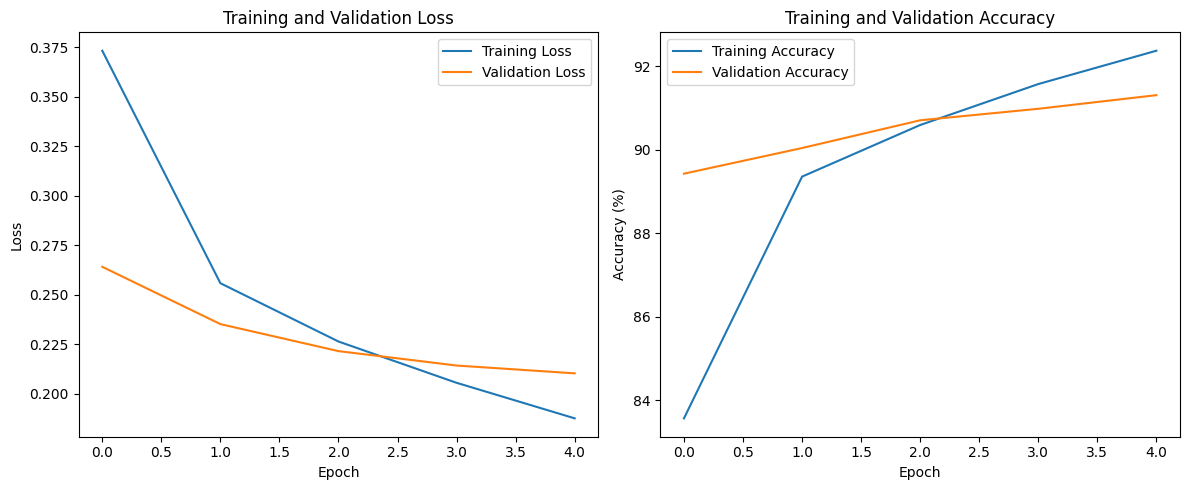

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def test_model(model, test_loader, clip_model, device):
    """
    Test the model on the test dataset and return metrics
    """
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    criterion = nn.CrossEntropyLoss()

    print("\n=== Testing Model ===")
    progress_bar = tqdm(test_loader, desc="Testing")

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, texts, labels) in enumerate(progress_bar):
            images, texts, labels = images.to(device), texts.to(device), labels.to(device)

            image_features = clip_model.encode_image(images).float()
            text_features = clip_model.encode_text(texts).float()

            outputs = model(image_features, text_features)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            batch_correct = (predicted == labels).sum().item()
            batch_total = labels.size(0)
            batch_accuracy = 100 * batch_correct / batch_total

            correct += batch_correct
            total += batch_total

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{batch_accuracy:.2f}%")

            print(f"Batch {batch_idx+1}: Loss = {loss.item():.4f}, Accuracy = {batch_accuracy:.2f}%")

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print("\n=== Test Results ===")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_predictions))

    print("\n=== Confusion Matrix ===")
    cm = confusion_matrix(all_labels, all_predictions)
    print(cm)

    return avg_test_loss, test_accuracy, all_predictions, all_labels

print("\nEvaluating on test set...")
test_loss, test_acc, predictions, true_labels = test_model(model, test_loader, clip_model, device)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'test_loss': test_loss,
    'test_accuracy': test_acc
}, 'fake_news_classifier.pth')

print("\nModel saved successfully!")

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

Generating ROC curve...

=== Generating ROC Curve Data ===


Processing: 100%|██████████| 32/32 [05:29<00:00, 10.31s/it]


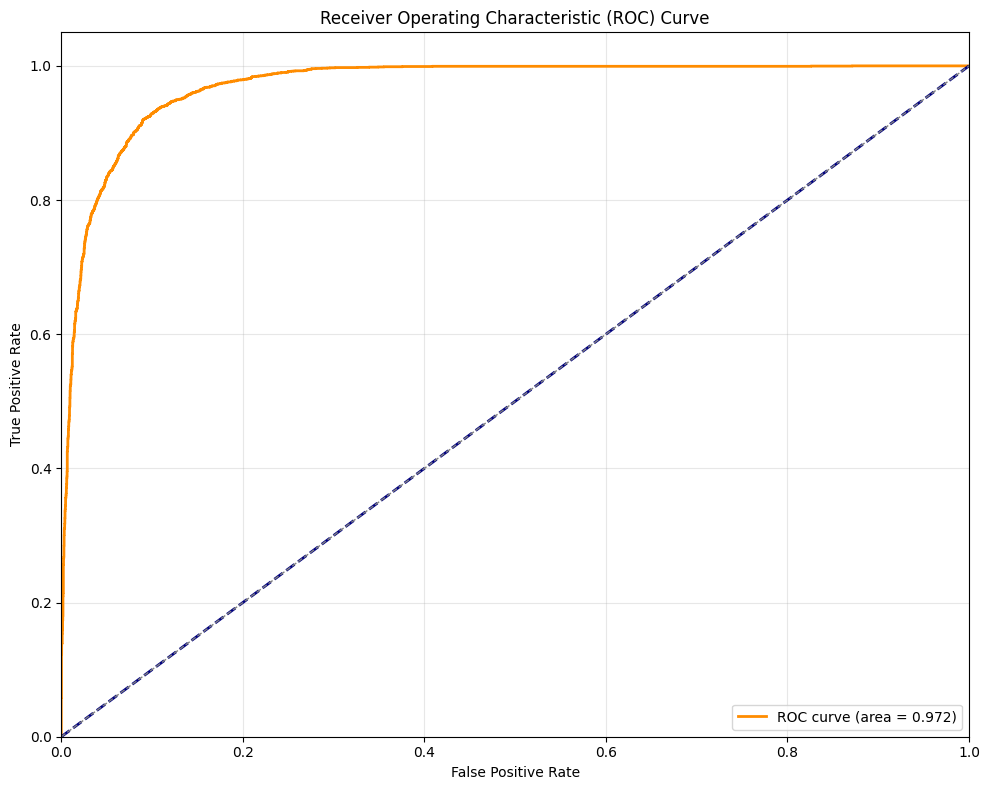


=== ROC AUC Scores ===
ROC AUC: 0.9715


In [ ]:
def generate_roc_curve(model, test_loader, clip_model, device):
    """
    Generate ROC curve data for the model on the test dataset
    """
    model.eval()

    all_labels = []
    all_probs = []

    print("\n=== Generating ROC Curve Data ===")
    progress_bar = tqdm(test_loader, desc="Processing")

    with torch.no_grad():
        for images, texts, labels in progress_bar:
            images, texts, labels = images.to(device), texts.to(device), labels.to(device)

            image_features = clip_model.encode_image(images).float()
            text_features = clip_model.encode_text(texts).float()

            outputs = model(image_features, text_features)
            probabilities = torch.softmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    return all_labels, all_probs


def plot_roc_curve(true_labels, predicted_probs):
    """
    Plot ROC curve and calculate AUC for binary and multiclass classification
    """
    if len(true_labels.shape) > 1 and true_labels.shape[1] > 1:
        true_labels = np.argmax(true_labels, axis=1)

    num_classes = predicted_probs.shape[1]

    plt.figure(figsize=(10, 8))

    if num_classes == 2:
        fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    else:
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), predicted_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2,
                     label=f'Class {i} (area = {roc_auc[i]:.3f})')

        y_test_bin = label_binarize(true_labels, classes=list(range(num_classes)))
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), predicted_probs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
                 label=f'Micro-average (area = {roc_auc["micro"]:.3f})')

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

        mean_tpr = np.zeros_like(all_fpr)
        for i in range(num_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= num_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', linewidth=4,
                 label=f'Macro-average (area = {roc_auc["macro"]:.3f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('roc_curve.png', dpi=300)
    plt.show()

    return roc_auc

print("Generating ROC curve...")
true_labels, pred_probs = generate_roc_curve(model, test_loader, clip_model, device)
roc_auc_values = plot_roc_curve(true_labels, pred_probs)

print("\n=== ROC AUC Scores ===")
if isinstance(roc_auc_values, dict):
    for key, value in roc_auc_values.items():
        if key not in ["micro", "macro"]:
            print(f"Class {key}: {value:.4f}")
    print(f"Micro-average: {roc_auc_values['micro']:.4f}")
    print(f"Macro-average: {roc_auc_values['macro']:.4f}")
else:
    print(f"ROC AUC: {roc_auc_values:.4f}")

In [ ]:
torch.save(model.state_dict(), "clip_fakenews_classifier.pth")
print(" Model saved.")

 Model saved.


In [ ]:
from google.colab import files
files.download("clip_fakenews_classifier.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FakeNewsClassifier().to(device)
model.load_state_dict(torch.load("/content/clip_fakenews_classifier.pth"))
model.eval()

FakeNewsClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=512, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
import gradio as gr

def predict_from_gradio(text, image):
    model.eval()

    try:
        image_input = preprocess(image).unsqueeze(0).to(device)
    except:
        image_input = preprocess(Image.new("RGB", (224, 224), (255, 255, 255))).unsqueeze(0).to(device)

    text_input = clip.tokenize([text]).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(image_input).float()
        text_features = clip_model.encode_text(text_input).float()
        outputs = model(image_features, text_features)
        _, predicted = torch.max(outputs, 1)

    label = predicted.item()
    return "Fake News" if label == 0 else "Real News"

In [ ]:
interface = gr.Interface(
    fn=predict_from_gradio,
    inputs=[
        gr.Textbox(label="News Headline / Description", placeholder="Enter the news content here..."),
        gr.Image(type="pil", label="Associated Image", sources=["upload", "clipboard"])
    ],
    outputs=gr.Textbox(label="Result"),
    title="📰 Fake News Detection",
    description="This app uses OpenAI's CLIP model to detect fake news based on text + image."
)

interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f132d1ec215799f3a4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
